In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from RSRTxReadBin.RTxReadBin import RTxReadBin

# Signal Processing
from scipy.fft import fft, fftfreq, fftshift
from scipy.fft import rfft, rfftfreq
from scipy.signal import stft


## Learning 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle


In [5]:
## get fmax helper function
def get_f_max(t, my, cutoff = 200e6, zeropad = False, no_dc = True):

    zero_pad_N = 100000

    dt = t[1]-t[0]
    
    N = len(t)
    if zeropad:
        # FFT code
        extra = np.zeros((zero_pad_N))
        mye = np.concatenate((my,extra))
        freq = rfft(mye-np.mean(mye))
        f = rfftfreq(N+zero_pad_N, dt)
    else:
        # FFT code
        freq = rfft(my-np.mean(my))
        f = rfftfreq(N, dt)
    #plt.plot(f,freq)
    
    idx = [i for i,v in enumerate(f) if v > cutoff]

    freq = freq[idx]
    f = f[idx]

    f_max = f[np.argmax(np.abs(freq))]

    #if f_max < 2e9:
    #    plt.plot(f[:50],freq[:50])
    return f_max

## Classifier class and plotting functions
class speechClassifierLab():
    def __init__(self, data_folder, feature_space = 20, cutoff = 200e6, processing = True, ch=0):
        ## Ch=0 == MTJ, Ch=1 == ARB
        files = []
        for f in os.listdir(data_folder):
            if f.endswith("Wfm.bin") and (f.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))):
                files.append(f)
                
        ### Generate smaller dataset for testing ###
        #files = files[::2]
        
        self.feature_space = feature_space
        self.features = np.zeros((len(files), feature_space))
        self.classes = []
                
      
        for n, file in tqdm(enumerate(files), total=len(files)):
            wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
            wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch]))] # Take only first half of the data to remove most of empty part
            t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
            #append class from filename
            self.classes.append(int(file[0]))
        
            for i,(ti,wfmi) in enumerate(zip(np.array_split(t,feature_space), np.array_split(wfm_data,feature_space))):
                self.features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
        
    def clf(self, layers = (10,10)):
        
        # Create a train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        crossval = kf.split(X_train, y_train)

        # Create an MLPClassifier    
        clf = MLPClassifier(hidden_layer_sizes=layers, max_iter=100000, random_state=42,activation="tanh")
        
        # Train the model
        scores = cross_val_score(clf, X_train, y_train, cv=crossval)

        # Make predictions
        predictions = cross_val_predict(clf, X_test, y_test, cv=3)

        # Print accuracy
        test_acc = np.mean(predictions == y_test)
        print("Accuracy on test set:\t\t", test_acc)
        print("Accuracy on training set:\t", scores.mean())
        return test_acc, scores.mean()
    
    def PCA_plot(self, save=False, savepath = "pcs.pdf"):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.features)
        
        colors = ["tab:blue", "tab:orange"]
        # Plot the 2D representation
        #c=list(map(str, self.classes)), label=list(map(str, self.classes)), cmap=matplotlib.colors.ListedColormap(colors)
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=self.classes)
        plt.title(f'2D Projection of {self.feature_space}D Data using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig("pca.pdf")
        plt.legend(*scatter.legend_elements())
        if save:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()


    def tSNE(self, savefig = False, savepath = "tsne.pdf"):
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(self.features)
        scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=self.classes)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(*scatter.legend_elements())
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
    
    def confmat(self, savefig = False, savepath = "confmat.pdf", struct = (10,10)):
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=struct, max_iter=100000, random_state=42,activation="tanh")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        plt.matshow(cm)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return

## Master of all sweeps
This goes through combinations of feature_space and cutoff and save them to pickle files. The pickle files hold the class instance, so it should be good to go

In [40]:
wfm_path = "./waveforms_r6p8_fast/"
classi = speechClassifierLab(wfm_path, feature_space=50, cutoff=40e6, ch=1)
#dump class instance to pickle for later use 
with open(f'Pickles/{wfm_path}/features{50}cutoff{40e6}_arb.pkl', 'wb') as f:
    pickle.dump(classi, f)

100%|██████████| 2995/2995 [17:26<00:00,  2.86it/s]


In [1]:
cutoffs= [40e6, 80e6, 120e6]

wfm = ["./waveforms_r1p9_fast/", "./waveforms_r2p3_fast/", "./waveforms_r6p7_fast/", "./waveforms_r6p8_fast/", "./waveforms_r6p9_fast/"]

## ----------- For MTJS ----------- ##
for w in tqdm(wfm):
    wfm_path = w
    feat = 50
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=0)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)
            
    feat = 20
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=0)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)
            
    feat = 64
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=0)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)

## ----------- For ARBS ----------- ##

cutoffs= [0e6, 40e6, 80e6]

for w in tqdm(wfm):
    wfm_path = w
    feat = 50
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=1)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)
            
    feat = 20
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=1)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)
            
    feat = 64
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=1)
        #dump class instance to pickle for later use 
        with open(f'Pickles_new/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)

NameError: name 'tqdm' is not defined

In [41]:
# pickles can be loaded with
feature = 50
cutoff = 40e6 # MHz
with open(f'Pickles/waveforms_r6p8_fast/features{feature}cutoff{cutoff}_arb.pkl', 'rb') as f:
    pickled_classi = pickle.load(f)

Accuracy on test set:		 0.13666666666666666
Accuracy on training set:	 0.15881417363019043
[[0.125      0.025      0.125      0.075      0.175      0.025
  0.05       0.15       0.075      0.175     ]
 [0.         0.11428571 0.17142857 0.17142857 0.17142857 0.02857143
  0.17142857 0.05714286 0.08571429 0.02857143]
 [0.04761905 0.0952381  0.04761905 0.14285714 0.23809524 0.
  0.33333333 0.         0.04761905 0.04761905]
 [0.06451613 0.16129032 0.09677419 0.03225806 0.25806452 0.
  0.16129032 0.03225806 0.09677419 0.09677419]
 [0.06666667 0.1        0.1        0.13333333 0.2        0.06666667
  0.13333333 0.06666667 0.06666667 0.06666667]
 [0.         0.07407407 0.         0.         0.25925926 0.14814815
  0.07407407 0.03703704 0.18518519 0.22222222]
 [0.         0.         0.08695652 0.04347826 0.26086957 0.04347826
  0.30434783 0.04347826 0.         0.2173913 ]
 [0.06896552 0.06896552 0.13793103 0.         0.20689655 0.03448276
  0.20689655 0.03448276 0.10344828 0.13793103]
 [0.096774

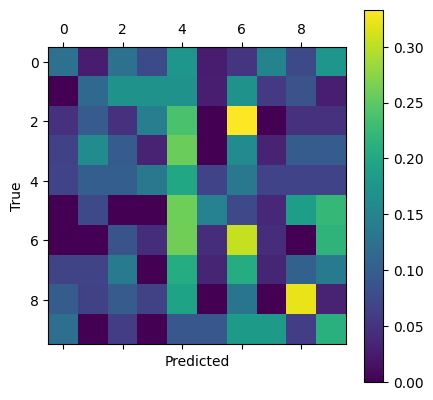

In [44]:
pickled_classi.clf(layers=(1000))
pickled_classi.confmat(struct=(1000))

In [62]:
structure = [(10), (20), (40), (80), (10,10), (20,20), (30,10)]

pickle_files = os.listdir("Pickles/waveforms_r6p8_fast/")

outputs = np.zeros((len(pickle_files),len(structure)))
for i, pickle_file in enumerate(pickle_files):
    with open("Pickles/waveforms_r6p8_fast/" + pickle_file, 'rb') as f:
        print(pickle_file)
        classi = pickle.load(f)
        for j, s in enumerate(structure):
            test, train = (classi.clf(layers=s))
            outputs[i,j] = test

features100cutoff100000000.0.pkl
Accuracy on test set:		 0.10333333333333333
Accuracy on training set:	 0.11205884951769392
Accuracy on test set:		 0.11
Accuracy on training set:	 0.13321367551011476
Accuracy on test set:		 0.15666666666666668
Accuracy on training set:	 0.13469308883168876
Accuracy on test set:		 0.12333333333333334
Accuracy on training set:	 0.14879644379261625
Accuracy on test set:		 0.11666666666666667
Accuracy on training set:	 0.12170331961686376
Accuracy on test set:		 0.13666666666666666
Accuracy on training set:	 0.15992404329482648
Accuracy on test set:		 0.17
Accuracy on training set:	 0.13804086533498824
features100cutoff150000000.0.pkl
Accuracy on test set:		 0.10666666666666667
Accuracy on training set:	 0.10241520521440552
Accuracy on test set:		 0.10666666666666667
Accuracy on training set:	 0.13284949952640607
Accuracy on test set:		 0.12
Accuracy on training set:	 0.13210132845783443
Accuracy on test set:		 0.15333333333333332
Accuracy on training set:

In [64]:
np.unravel_index(np.argmax(outputs), outputs.shape), outputs[np.unravel_index(np.argmax(outputs), outputs.shape)], pickle_files[np.unravel_index(np.argmax(outputs), outputs.shape)[0]]


((17, 3), 0.21666666666666667, 'features20cutoff40000000.0.pkl')

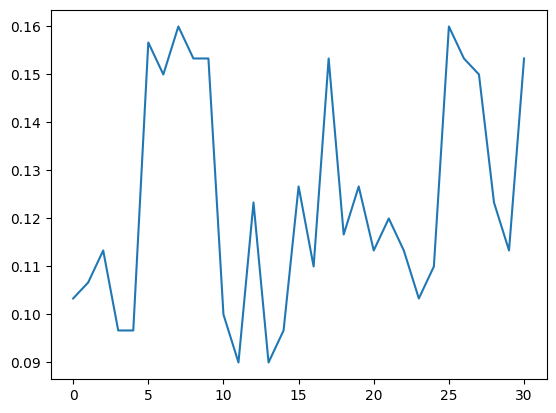

In [65]:
#outputs_505050 = outputs
plt.plot(np.array(outputs)[:,0])

ConversionError: Failed to convert value(s) to axis units: ['features100cutoff100000000.0.pkl', 'features100cutoff150000000.0.pkl', 'features100cutoff40000000.0.pkl', 'features100cutoff60000000.0.pkl', 'features100cutoff80000000.0.pkl', 'features10cutoff100000000.0.pkl', 'features10cutoff150000000.0.pkl', 'features10cutoff40000000.0.pkl', 'features10cutoff60000000.0.pkl', 'features10cutoff80000000.0.pkl', 'features200cutoff100000000.0.pkl', 'features200cutoff150000000.0.pkl', 'features200cutoff40000000.0.pkl', 'features200cutoff60000000.0.pkl', 'features200cutoff80000000.0.pkl', 'features20cutoff100000000.0.pkl', 'features20cutoff150000000.0.pkl', 'features20cutoff40000000.0.pkl', 'features20cutoff60000000.0.pkl', 'features20cutoff80000000.0.pkl', 'features500cutoff100000000.0.pkl', 'features500cutoff150000000.0.pkl', 'features500cutoff40000000.0.pkl', 'features500cutoff60000000.0.pkl', 'features500cutoff80000000.0.pkl', 'features50cutoff100000000.0.pkl', 'features50cutoff150000000.0.pkl', 'features50cutoff40000000.0.pkl', 'features50cutoff60000000.0.pkl', 'features50cutoff80000000.0.pkl']

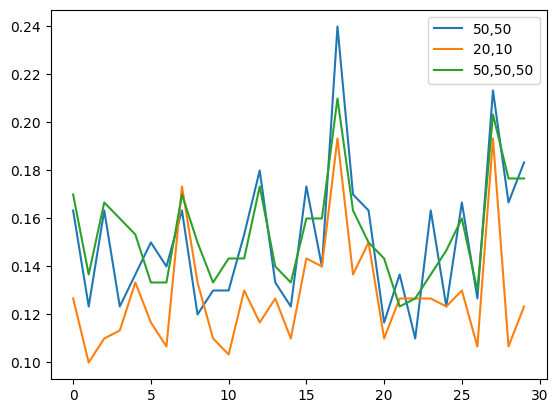

In [38]:
plt.plot(np.array(outputs_5050)[:,0], label="50,50")
plt.plot(np.array(outputs_2010)[:,0], label="20,10")
plt.plot(np.array(outputs_505050)[:,0], label="50,50,50")
plt.legend()
plt.xticks(pickle_files)

### On MTJ

In [3]:
path = "./waveforms_r2p3_fast/"

In [4]:
classi = speechClassifierLab(path, feature_space=500, cutoff=80e6, ch=0)

  0%|          | 0/2995 [00:00<?, ?it/s]

100%|██████████| 2995/2995 [22:27<00:00,  2.22it/s]


In [18]:
feat = 500
co = 80e6
with open(f'Pickles/{wfm_path}/features{feat}cutoff{int(co*1e-6)}.pkl', 'wb') as f:
    pickle.dump(classi_pickled, f)

In [6]:
lay = (20)#(200,500,500, 200)

classi.clf(layers=lay)

Accuracy on test set:		 0.12333333333333334
Accuracy on training set:	 0.09313078211953725


(0.12333333333333334, 0.09313078211953725)

In [8]:
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(classi, f)

In [14]:
with open('pickle_test.pkl', 'rb') as f:
    classi_pickled = pickle.load(f)

In [15]:
classi_pickled.features

array([[8.12397841e+08, 7.99899413e+08, 7.62404128e+08, ...,
        8.25205683e+08, 8.37708799e+08, 8.37708799e+08],
       [8.12397841e+08, 8.12397841e+08, 8.24896269e+08, ...,
        8.12702566e+08, 8.12702566e+08, 8.12702566e+08],
       [8.12397841e+08, 8.12397841e+08, 8.12397841e+08, ...,
        8.12702566e+08, 8.12702566e+08, 8.00199450e+08],
       ...,
       [7.99899413e+08, 7.99899413e+08, 7.99899413e+08, ...,
        8.12702566e+08, 8.25205683e+08, 8.12702566e+08],
       [8.12397841e+08, 8.12397841e+08, 8.12397841e+08, ...,
        7.75193217e+08, 8.12702566e+08, 7.62690100e+08],
       [7.87400984e+08, 8.12397841e+08, 7.99899413e+08, ...,
        8.25205683e+08, 8.12702566e+08, 8.00199450e+08]])

[[0.2        0.         0.05       0.075      0.         0.15
  0.         0.         0.         0.525     ]
 [0.25714286 0.         0.14285714 0.02857143 0.         0.22857143
  0.         0.         0.         0.34285714]
 [0.38095238 0.         0.14285714 0.04761905 0.         0.19047619
  0.04761905 0.         0.         0.19047619]
 [0.41935484 0.         0.06451613 0.06451613 0.         0.12903226
  0.         0.         0.         0.32258065]
 [0.2        0.         0.3        0.03333333 0.         0.1
  0.         0.         0.         0.36666667]
 [0.2962963  0.         0.07407407 0.11111111 0.         0.25925926
  0.         0.         0.03703704 0.22222222]
 [0.26086957 0.         0.04347826 0.08695652 0.         0.2173913
  0.         0.         0.04347826 0.34782609]
 [0.10344828 0.03448276 0.20689655 0.06896552 0.         0.20689655
  0.         0.         0.03448276 0.34482759]
 [0.16129032 0.03225806 0.19354839 0.         0.         0.25806452
  0.         0.         0.

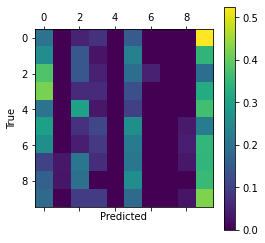

In [27]:
classi.confmat(struct=lay)

(0.0, 10.0)

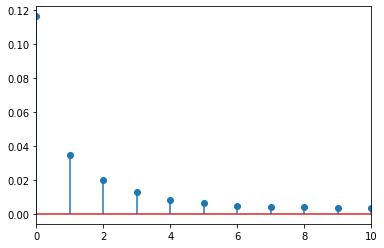

In [40]:
p_c_a = PCA()

p_c_a.fit(classi.features)
plt.stem(p_c_a.explained_variance_ratio_)
plt.xlim([0,10])

In [55]:
res = classi.clf(layers=(10))

Accuracy on test set:		 0.13333333333333333
Accuracy on training set:	 0.14174497276112286


### On ARB

In [56]:
classiarb = speechClassifierLab(path, feature_space=20, cutoff=100e6, ch=1)

  0%|          | 0/2995 [00:00<?, ?it/s]

100%|██████████| 2995/2995 [10:16<00:00,  4.86it/s]


In [58]:
resarb = classiarb.clf(layers=(10))

Accuracy on test set:		 0.09333333333333334
Accuracy on training set:	 0.1436026005963898


## Binary classification multisweep

In [12]:
## Classifier class and plotting functions
class speechClassifierBinary():
    def __init__(self, data_folder, feature_space = 20, cutoff = 100e6, processing = True, ch=0):
        ## Ch=0 == MTJ, Ch=1 == ARB
        files = []
        for f in os.listdir(data_folder):
            if f.endswith("Wfm.bin") and (f.startswith(("0", "1"))):
                files.append(f)
                
        ### Generate smaller dataset for testing ###
        #files = files[::2]
        
        self.feature_space = feature_space
        self.features = np.zeros((len(files), feature_space))
        self.classes = []
                
      
        for n, file in tqdm(enumerate(files), total=len(files)):
            wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
            wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch])/2)] # Take only first half of the data to remove most of empty part
            t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
            #append class from filename
            self.classes.append(int(file[0]))
        
            for i,(ti,wfmi) in enumerate(zip(np.array_split(t,feature_space), np.array_split(wfm_data,feature_space))):
                self.features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
        
    def clf(self, layers = (10,10)):
        
        # Create a train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.20, random_state=42)
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        crossval = kf.split(X_train, y_train)

        # Create an MLPClassifier    
        clf = MLPClassifier(hidden_layer_sizes=layers, max_iter=100000, random_state=42,activation="tanh")
        
        # Train the model
        scores = cross_val_score(clf, X_train, y_train, cv=crossval)

        # Make predictions
        predictions = cross_val_predict(clf, X_test, y_test, cv=3)

        # Print accuracy
        test_acc = np.mean(predictions == y_test)
        print("Accuracy on test set:\t\t", test_acc)
        print("Accuracy on training set:\t", scores.mean())
        return test_acc, scores.mean()
    
    def PCA_plot(self, save=False, savepath = "pcs.pdf"):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.features)
        
        colors = ["tab:blue", "tab:orange"]
        # Plot the 2D representation
        #c=list(map(str, self.classes)), label=list(map(str, self.classes)), cmap=matplotlib.colors.ListedColormap(colors)
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=self.classes)
        plt.title(f'2D Projection of {self.feature_space}D Data using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig("pca.pdf")
        plt.legend(*scatter.legend_elements())
        if save:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()


    def tSNE(self, savefig = False, savepath = "tsne.pdf"):
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(self.features)
        scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=self.classes)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(*scatter.legend_elements())
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
    
    def confmat(self, savefig = False, savepath = "confmat.pdf", struct = (10,10)):
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=struct, max_iter=100000, random_state=42,activation="tanh")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        plt.matshow(cm, cmap="inferno", vmin=0)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
        

In [14]:
# Plot single CM
path = "./waveforms_r2p3_fast/"
lassi = speechClassifierBinary(path, feature_space=15, cutoff=40000000, ch=0)


  0%|          | 0/540 [00:00<?, ?it/s]

100%|██████████| 540/540 [01:23<00:00,  6.45it/s]


Accuracy on test set:		 0.7777777777777778
Accuracy on training set:	 0.7106481481481483
[[0.69230769 0.30769231]
 [0.21428571 0.78571429]]
figure saved


C:\Users\olive\AppData\Local\Temp\ipykernel_7652\3332423414.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


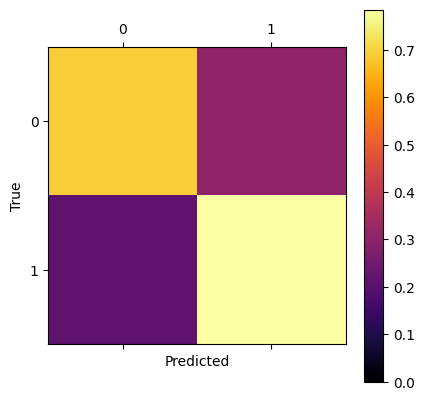

In [17]:
lassi.clf(layers=(20,10))
savepath = "../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/binary_confmat.pdf"
lassi.confmat(struct=(20,10), savefig=True, savepath=savepath)

  0%|          | 0/540 [00:00<?, ?it/s]

100%|██████████| 540/540 [01:00<00:00,  8.89it/s]


For feature space:  15  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6805555555555557
[[0.73076923 0.26923077]
 [0.32142857 0.67857143]]


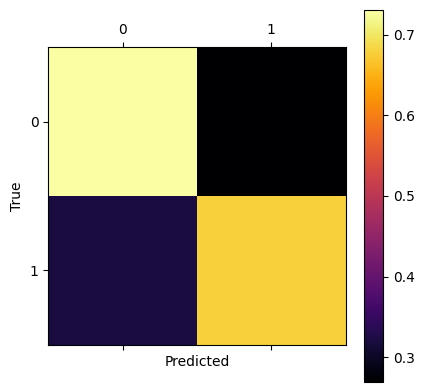

For feature space:  15  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6828703703703703
[[0.76923077 0.23076923]
 [0.25       0.75      ]]


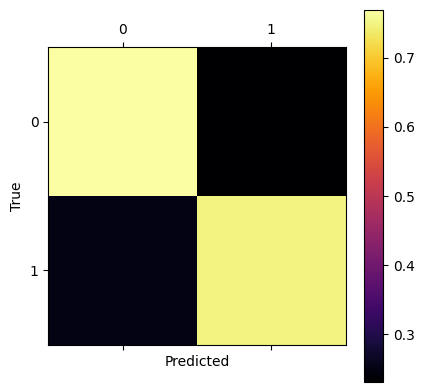

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.7222222222222223
[[0.65384615 0.34615385]
 [0.28571429 0.71428571]]


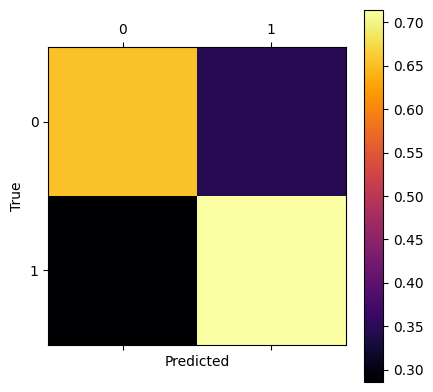

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6064814814814815
[[0.80769231 0.19230769]
 [0.39285714 0.60714286]]


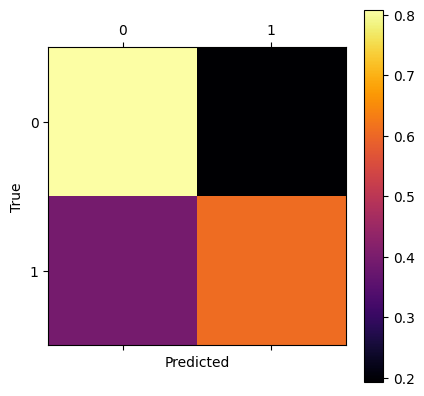

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6342592592592592
[[0.80769231 0.19230769]
 [0.53571429 0.46428571]]


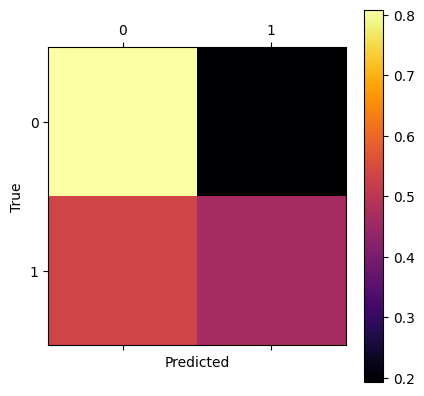

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.7222222222222222
Accuracy on training set:	 0.7337962962962963
[[0.69230769 0.30769231]
 [0.28571429 0.71428571]]


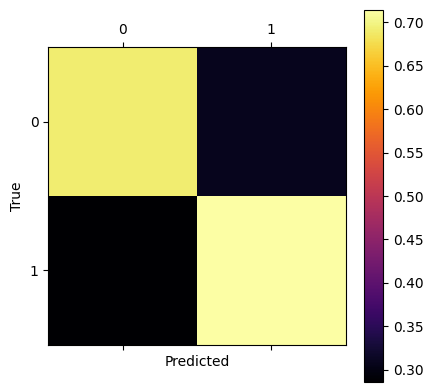

100%|██████████| 540/540 [01:04<00:00,  8.40it/s]


For feature space:  15  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5925925925925926
[[0.76923077 0.23076923]
 [0.28571429 0.71428571]]


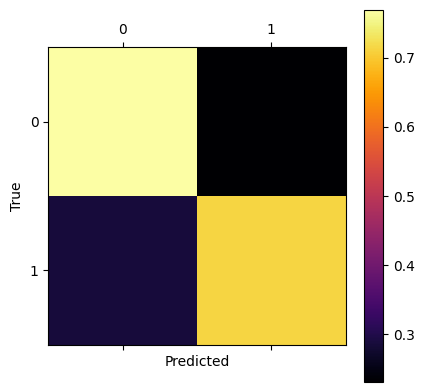

For feature space:  15  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.7083333333333334
[[0.73076923 0.26923077]
 [0.28571429 0.71428571]]


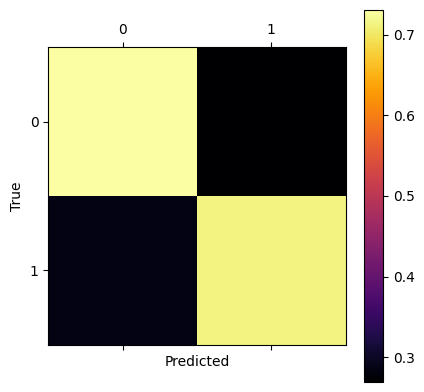

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.7175925925925926
[[0.73076923 0.26923077]
 [0.17857143 0.82142857]]


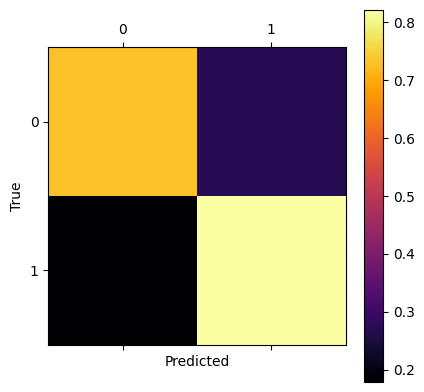

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.6157407407407408
[[0.69230769 0.30769231]
 [0.35714286 0.64285714]]


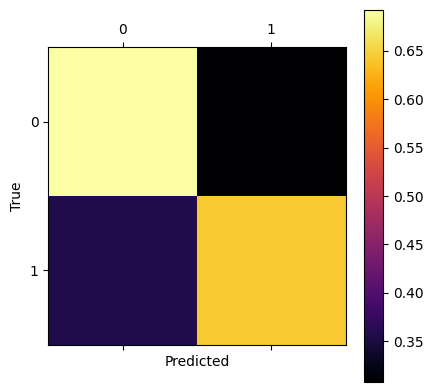

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.6134259259259259
[[0.73076923 0.26923077]
 [0.57142857 0.42857143]]


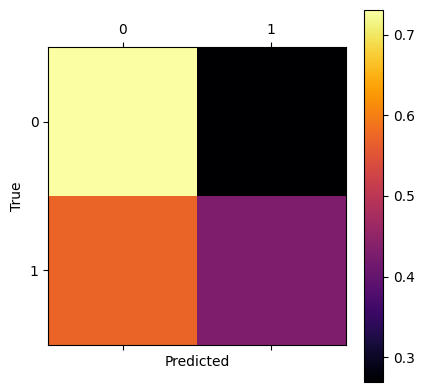

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.7222222222222222
Accuracy on training set:	 0.7314814814814814
[[0.61538462 0.38461538]
 [0.21428571 0.78571429]]


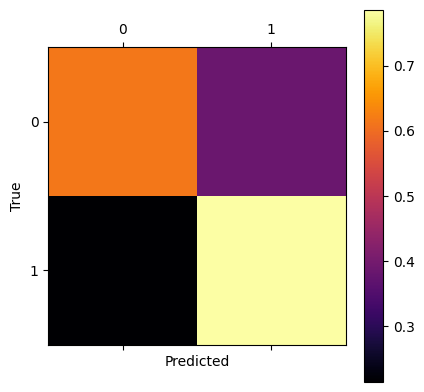

100%|██████████| 540/540 [01:04<00:00,  8.33it/s]


For feature space:  15  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5949074074074074
[[0.65384615 0.34615385]
 [0.35714286 0.64285714]]


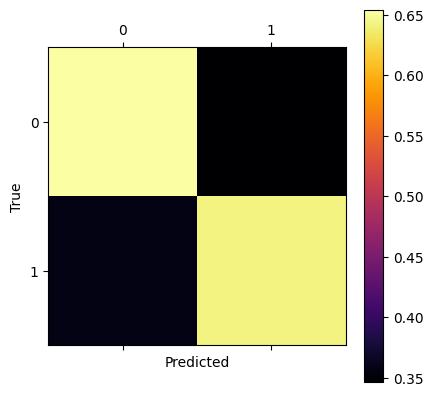

For feature space:  15  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.6944444444444443
[[0.73076923 0.26923077]
 [0.21428571 0.78571429]]


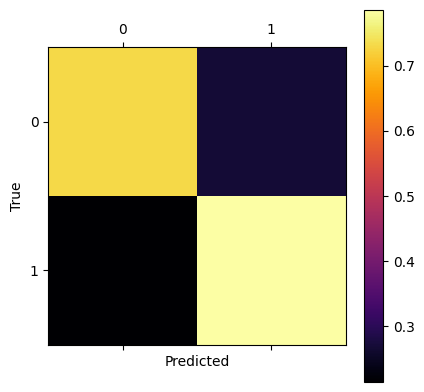

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6527777777777778
[[0.73076923 0.26923077]
 [0.25       0.75      ]]


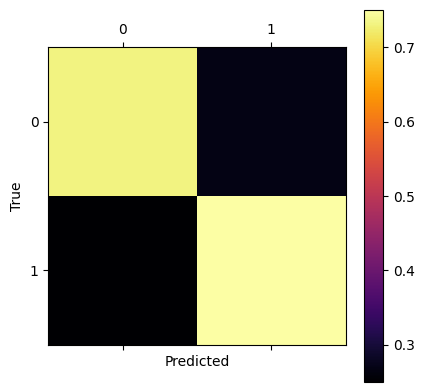

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5879629629629629
[[0.73076923 0.26923077]
 [0.32142857 0.67857143]]


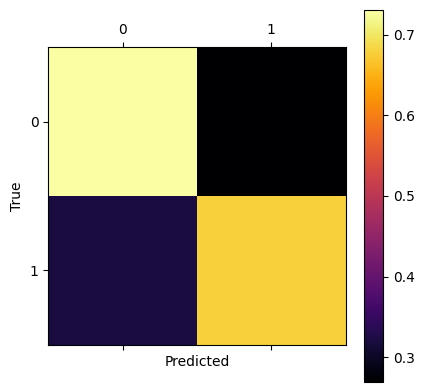

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5856481481481481
[[0.69230769 0.30769231]
 [0.53571429 0.46428571]]


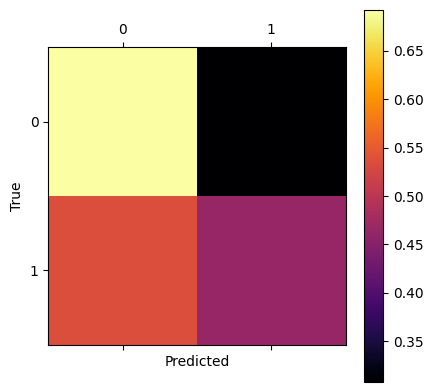

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6689814814814815
[[0.76923077 0.23076923]
 [0.35714286 0.64285714]]


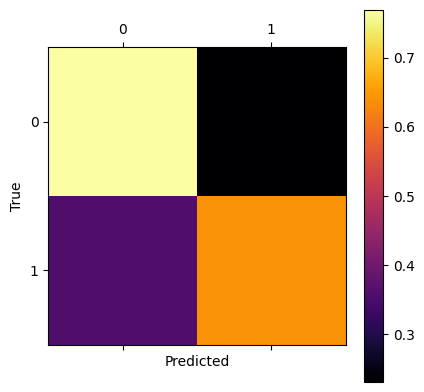

100%|██████████| 540/540 [00:47<00:00, 11.36it/s]


For feature space:  20  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6643518518518519
[[0.69230769 0.30769231]
 [0.25       0.75      ]]


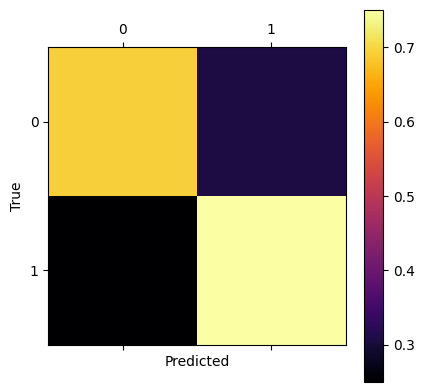

For feature space:  20  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.7129629629629629
Accuracy on training set:	 0.6990740740740741
[[0.65384615 0.34615385]
 [0.32142857 0.67857143]]


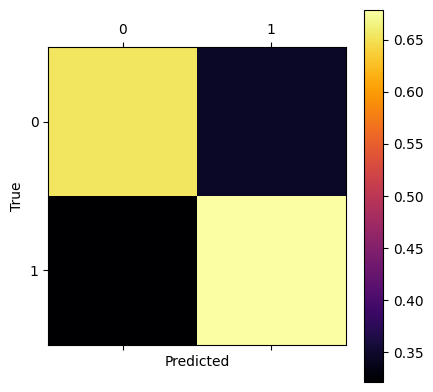

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6944444444444443
[[0.69230769 0.30769231]
 [0.39285714 0.60714286]]


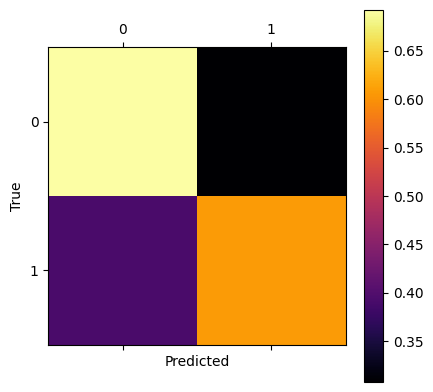

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.7037037037037037
Accuracy on training set:	 0.6689814814814814
[[0.76923077 0.23076923]
 [0.25       0.75      ]]


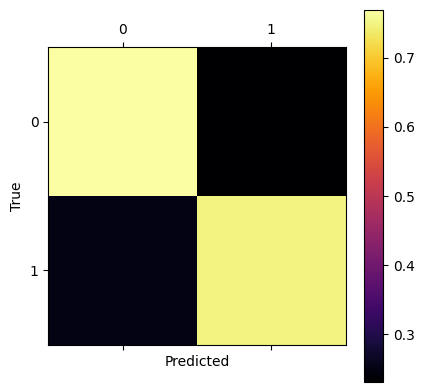

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.7106481481481483
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


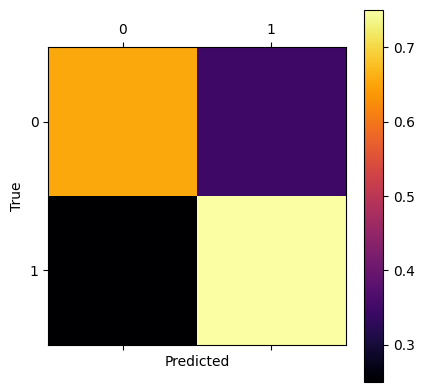

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.7199074074074074
[[0.69230769 0.30769231]
 [0.35714286 0.64285714]]


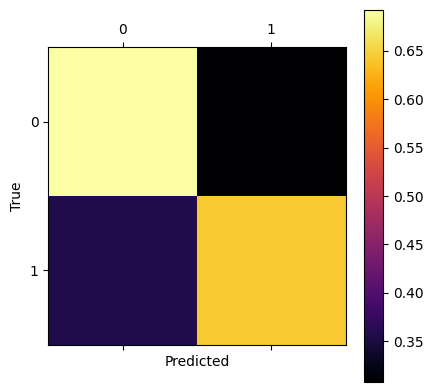

100%|██████████| 540/540 [00:46<00:00, 11.67it/s]


For feature space:  20  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.638888888888889
[[0.69230769 0.30769231]
 [0.17857143 0.82142857]]


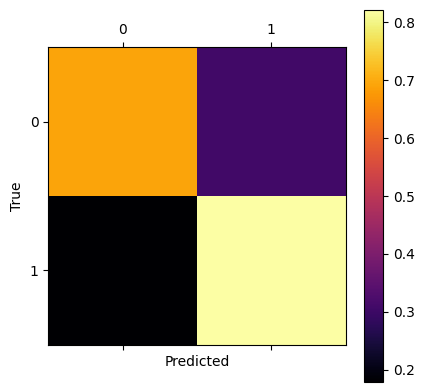

For feature space:  20  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.6782407407407408
[[0.65384615 0.34615385]
 [0.35714286 0.64285714]]


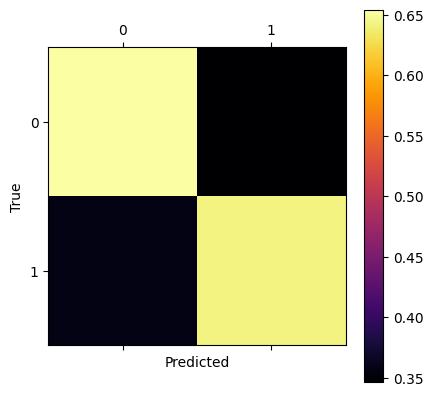

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.7037037037037037
[[0.53846154 0.46153846]
 [0.32142857 0.67857143]]


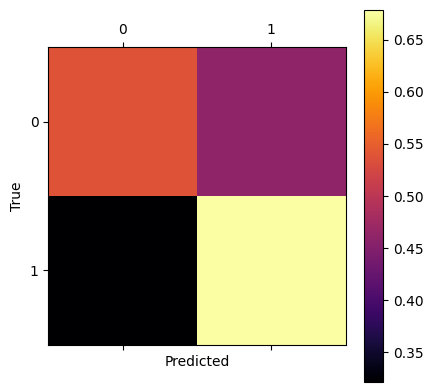

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.6504629629629629
[[0.65384615 0.34615385]
 [0.17857143 0.82142857]]


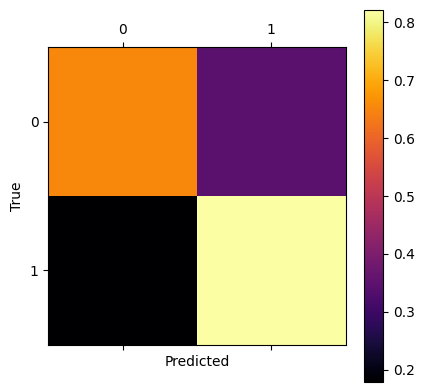

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.6574074074074074
[[0.61538462 0.38461538]
 [0.25       0.75      ]]


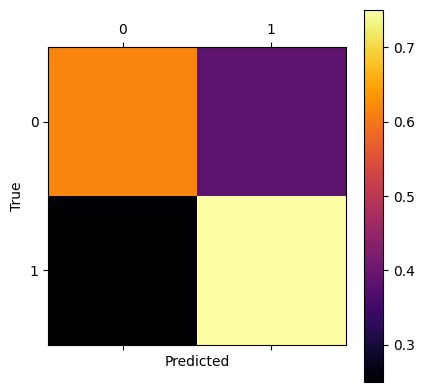

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6967592592592592
[[0.61538462 0.38461538]
 [0.32142857 0.67857143]]


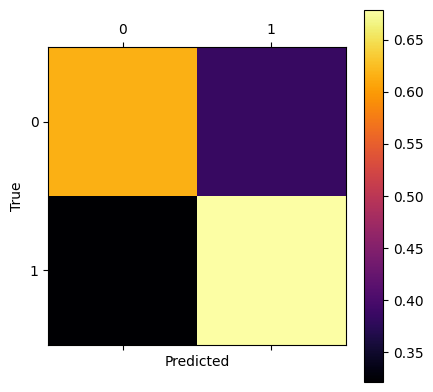

100%|██████████| 540/540 [00:46<00:00, 11.70it/s]


For feature space:  20  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6134259259259259
[[0.57692308 0.42307692]
 [0.17857143 0.82142857]]


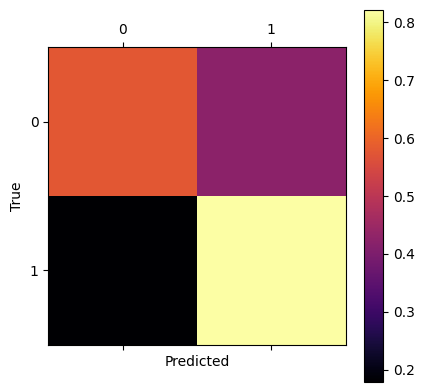

For feature space:  20  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.6944444444444445
[[0.69230769 0.30769231]
 [0.32142857 0.67857143]]


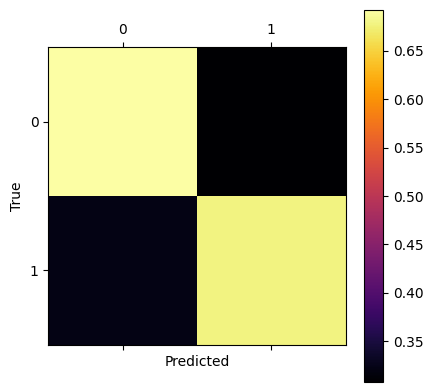

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.7222222222222222
Accuracy on training set:	 0.7083333333333334
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


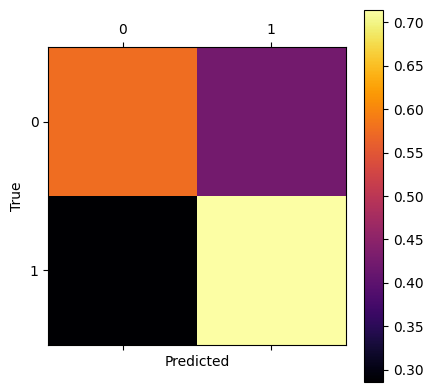

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6574074074074074
[[0.73076923 0.26923077]
 [0.17857143 0.82142857]]


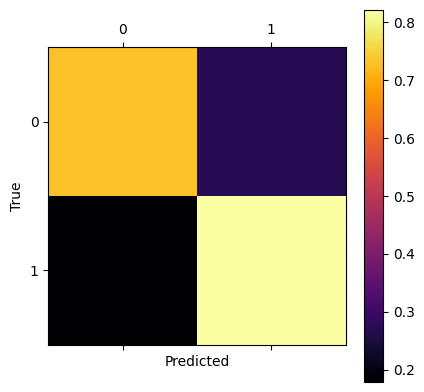

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6481481481481483
[[0.65384615 0.34615385]
 [0.17857143 0.82142857]]


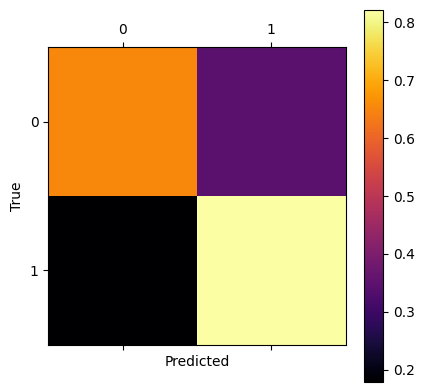

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6990740740740741
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


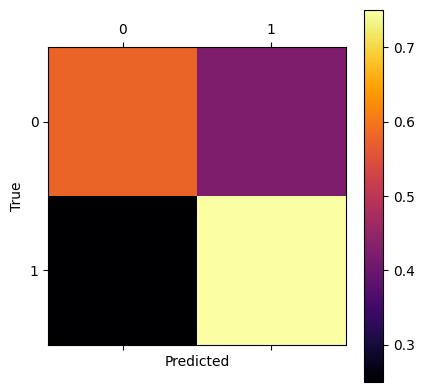

100%|██████████| 540/540 [00:49<00:00, 10.99it/s]


For feature space:  30  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.6574074074074074
[[0.53846154 0.46153846]
 [0.28571429 0.71428571]]


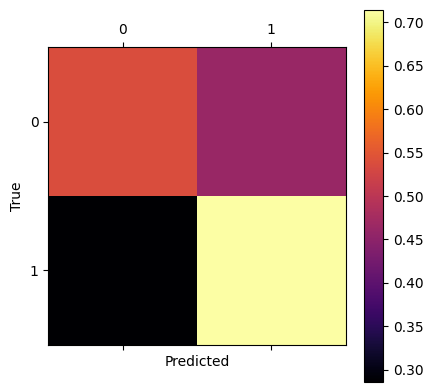

For feature space:  30  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6643518518518519
[[0.80769231 0.19230769]
 [0.17857143 0.82142857]]


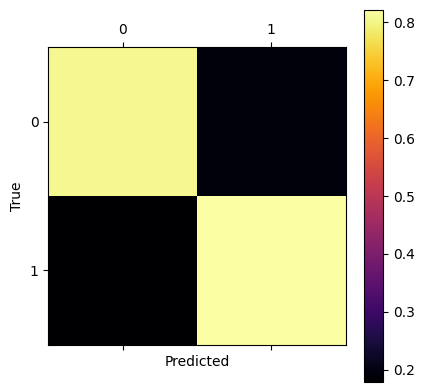

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6458333333333334
[[0.69230769 0.30769231]
 [0.25       0.75      ]]


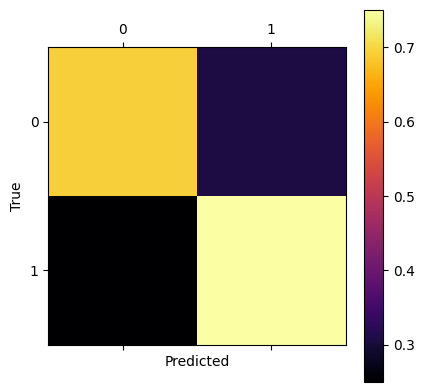

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6504629629629629
[[0.57692308 0.42307692]
 [0.35714286 0.64285714]]


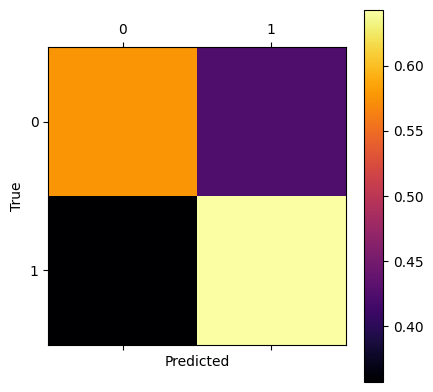

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6527777777777778
[[0.57692308 0.42307692]
 [0.39285714 0.60714286]]


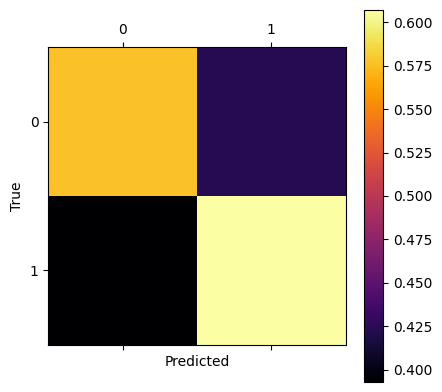

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6504629629629629
[[0.61538462 0.38461538]
 [0.32142857 0.67857143]]


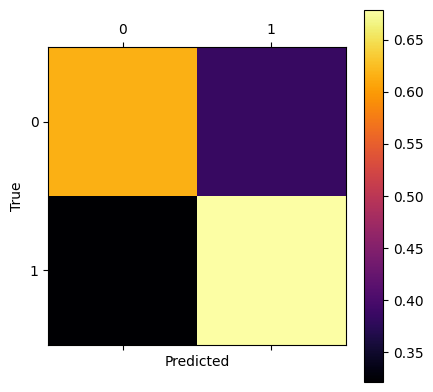

100%|██████████| 540/540 [00:49<00:00, 10.86it/s]


For feature space:  30  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6828703703703703
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


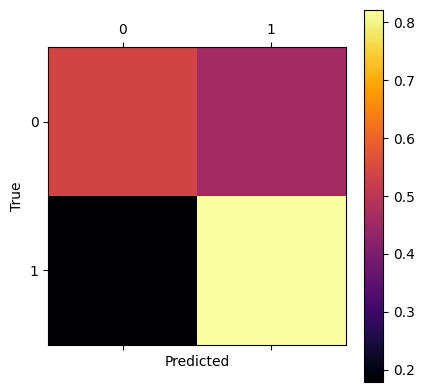

For feature space:  30  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6689814814814815
[[0.73076923 0.26923077]
 [0.17857143 0.82142857]]


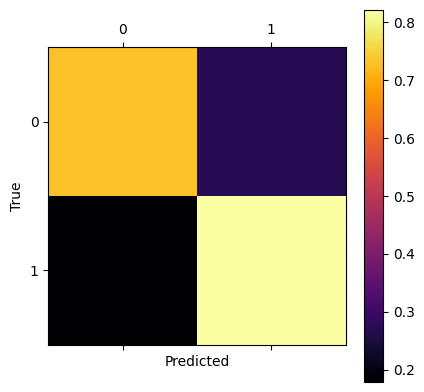

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6597222222222222
[[0.5        0.5       ]
 [0.21428571 0.78571429]]


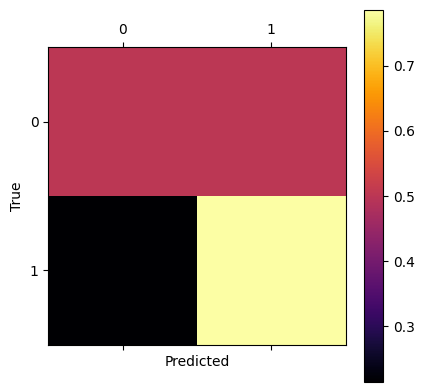

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6666666666666666
[[0.69230769 0.30769231]
 [0.25       0.75      ]]


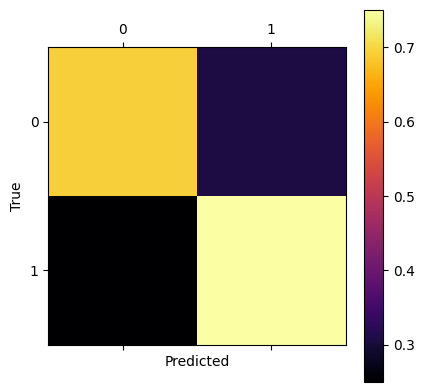

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6689814814814815
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


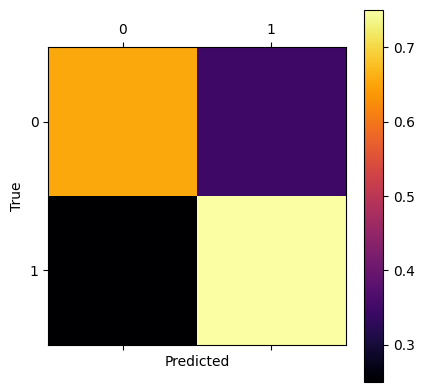

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.6458333333333334
[[0.57692308 0.42307692]
 [0.21428571 0.78571429]]


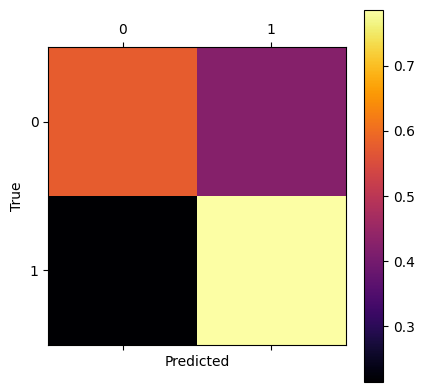

100%|██████████| 540/540 [00:50<00:00, 10.72it/s]


For feature space:  30  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.7222222222222222
Accuracy on training set:	 0.6736111111111112
[[0.46153846 0.53846154]
 [0.25       0.75      ]]


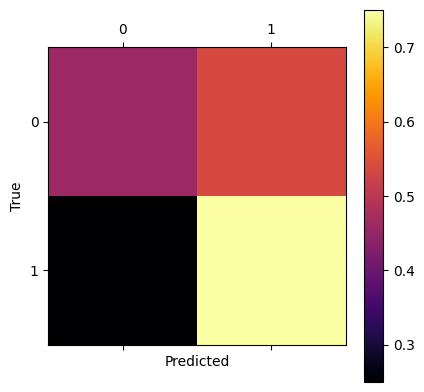

For feature space:  30  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.673611111111111
[[0.65384615 0.34615385]
 [0.17857143 0.82142857]]


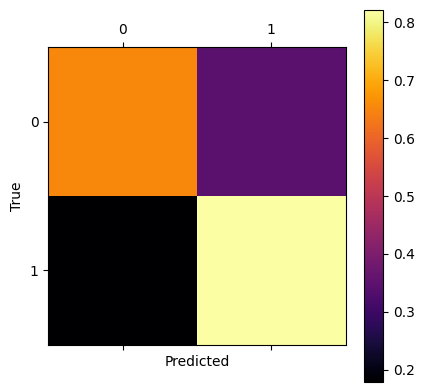

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6527777777777778
[[0.53846154 0.46153846]
 [0.28571429 0.71428571]]


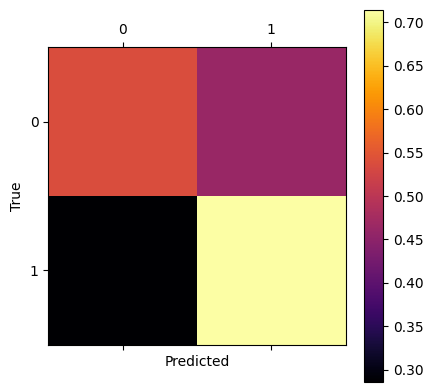

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6805555555555555
[[0.61538462 0.38461538]
 [0.25       0.75      ]]


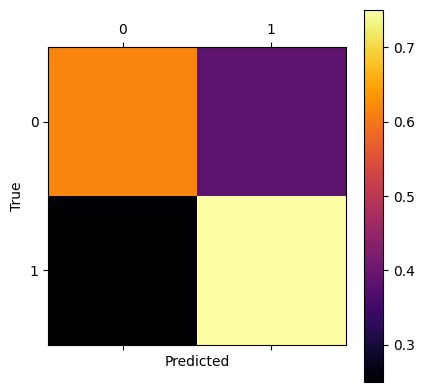

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6597222222222222
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


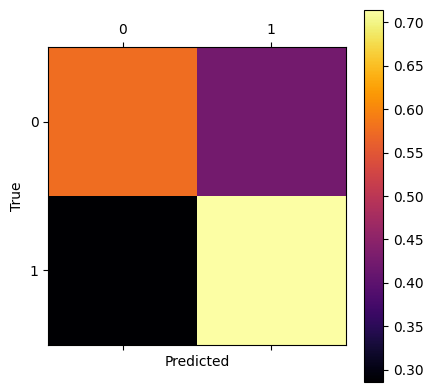

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.6620370370370371
[[0.57692308 0.42307692]
 [0.17857143 0.82142857]]


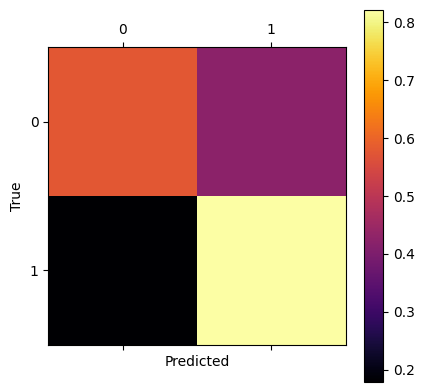

100%|██████████| 540/540 [00:47<00:00, 11.40it/s]


For feature space:  50  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.6550925925925927
[[0.61538462 0.38461538]
 [0.35714286 0.64285714]]


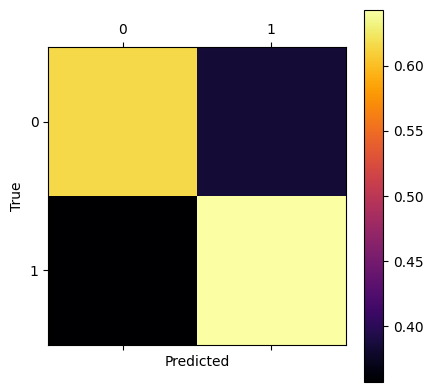

For feature space:  50  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.48148148148148145
Accuracy on training set:	 0.6689814814814815
[[0.69230769 0.30769231]
 [0.32142857 0.67857143]]


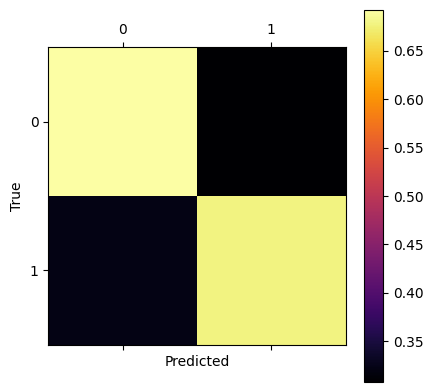

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.75
Accuracy on training set:	 0.6782407407407408
[[0.76923077 0.23076923]
 [0.32142857 0.67857143]]


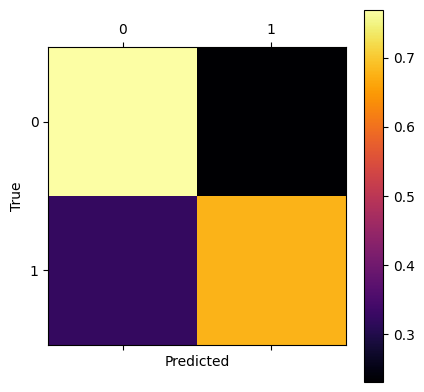

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6041666666666666
[[0.46153846 0.53846154]
 [0.17857143 0.82142857]]


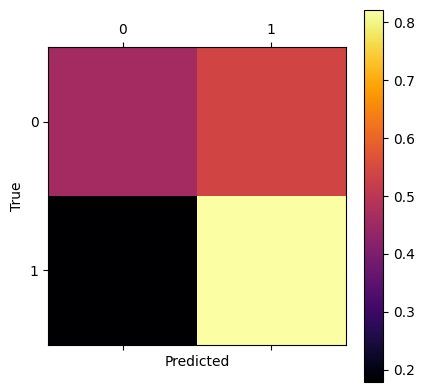

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.5694444444444444
[[0.88461538 0.11538462]
 [0.78571429 0.21428571]]


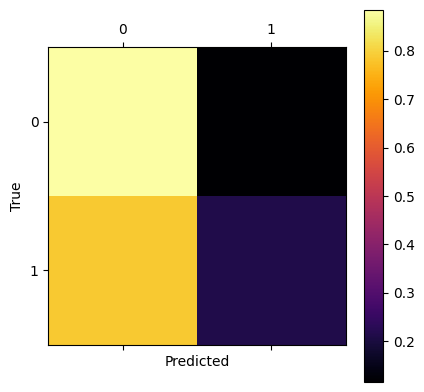

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.7129629629629629
Accuracy on training set:	 0.6828703703703703
[[0.73076923 0.26923077]
 [0.32142857 0.67857143]]


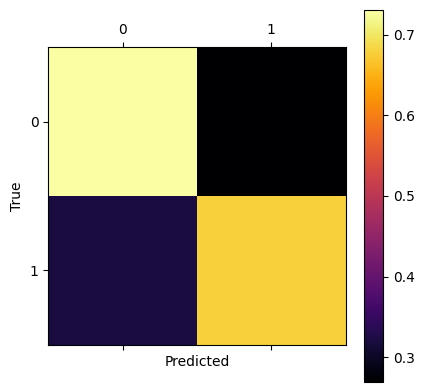

100%|██████████| 540/540 [00:51<00:00, 10.43it/s]


For feature space:  50  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.6203703703703703
[[0.69230769 0.30769231]
 [0.53571429 0.46428571]]


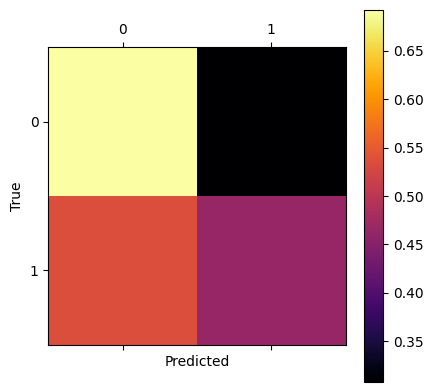

For feature space:  50  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.6990740740740741
[[0.69230769 0.30769231]
 [0.28571429 0.71428571]]


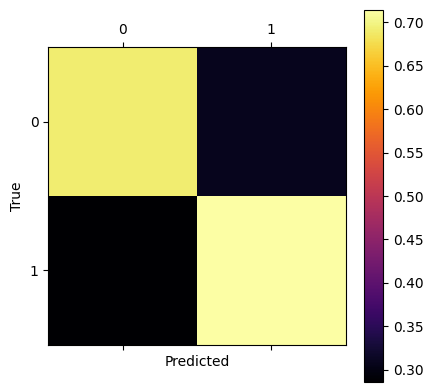

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6782407407407408
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


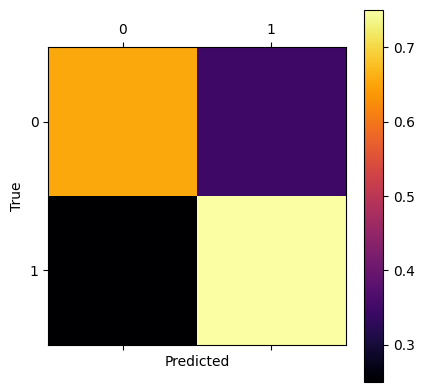

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.5555555555555555
[[0.84615385 0.15384615]
 [0.78571429 0.21428571]]


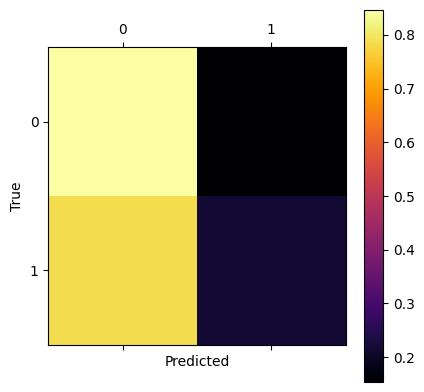

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5625
[[0.46153846 0.53846154]
 [0.21428571 0.78571429]]


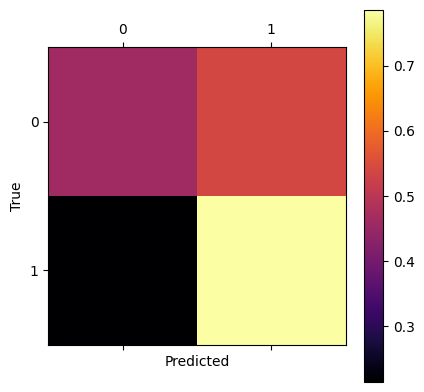

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.7407407407407407
Accuracy on training set:	 0.6921296296296297
[[0.65384615 0.34615385]
 [0.35714286 0.64285714]]


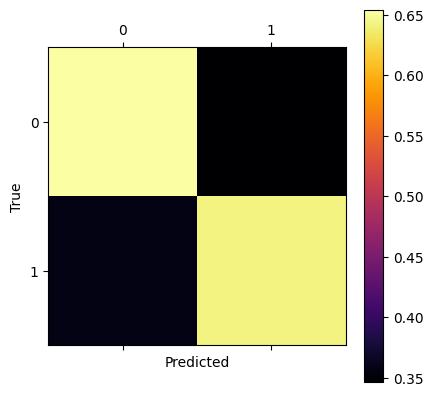

100%|██████████| 540/540 [00:50<00:00, 10.72it/s]


For feature space:  50  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.48148148148148145
Accuracy on training set:	 0.6388888888888888
[[0.61538462 0.38461538]
 [0.32142857 0.67857143]]


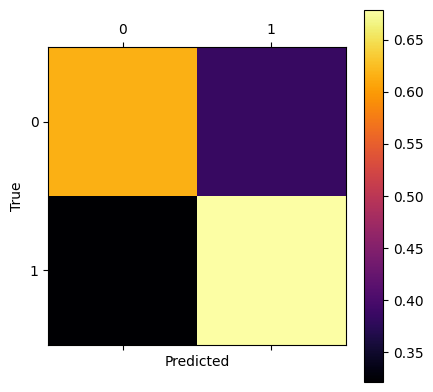

For feature space:  50  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.6597222222222222
[[0.65384615 0.34615385]
 [0.28571429 0.71428571]]


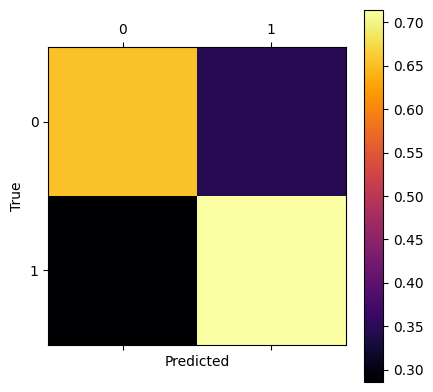

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.7314814814814815
Accuracy on training set:	 0.7083333333333334
[[0.65384615 0.34615385]
 [0.32142857 0.67857143]]


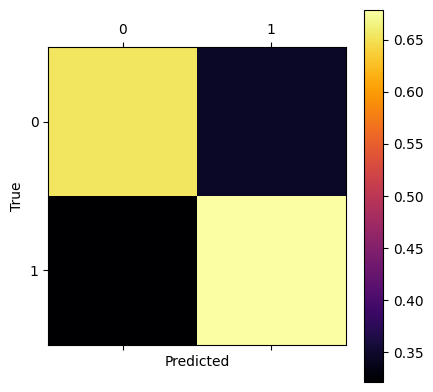

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.5439814814814815
[[0.80769231 0.19230769]
 [0.64285714 0.35714286]]


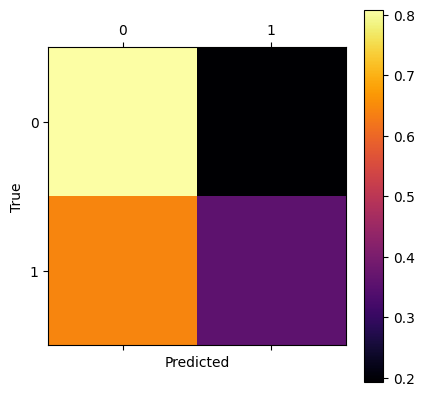

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.525462962962963
[[0.88461538 0.11538462]
 [0.75       0.25      ]]


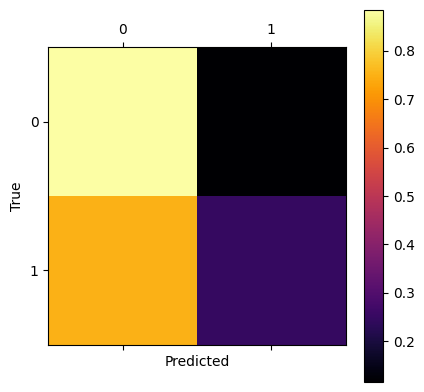

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10, 10)
Accuracy on test set:		 0.7129629629629629
Accuracy on training set:	 0.6967592592592592
[[0.65384615 0.34615385]
 [0.39285714 0.60714286]]


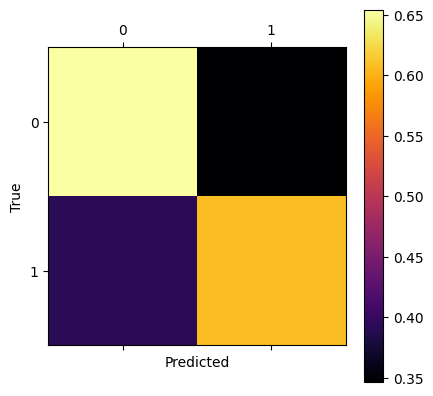

In [78]:
features = [15,20,30,50]
cutoff = [40e6, 80e6, 120e6]
structure = [(30,), (40,), (20,10), (10,10,10), (10,10,5,5), (20,10,10) ]
acc = np.zeros((len(features), len(cutoff), len(structure)))
for i, f in enumerate(features):
    for j, c in enumerate(cutoff):
        lassi = speechClassifierBinary("./waveforms_r6p9_fast/", feature_space=f, cutoff=c, ch=0)
        for k, s in enumerate(structure):
            print("For feature space: ", f, " and cutoff: ", c, " and structure: ", s)
            acc[i,j, k], _ = lassi.clf(layers=s)
            lassi.confmat(struct=s)

In [84]:
# Find the 5 highest accuracies
acc_temp = acc.copy()
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])

(3, 0, 2) 0.75 50 40000000.0 (20, 10)
(3, 1, 5) 0.7407407407407407 50 80000000.0 (20, 10, 10)
(3, 2, 2) 0.7314814814814815 50 120000000.0 (20, 10)
(0, 0, 5) 0.7222222222222222 15 40000000.0 (20, 10, 10)
(0, 1, 5) 0.7222222222222222 15 80000000.0 (20, 10, 10)


100%|██████████| 540/540 [01:34<00:00,  5.69it/s]


For feature space:  15  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6435185185185185
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


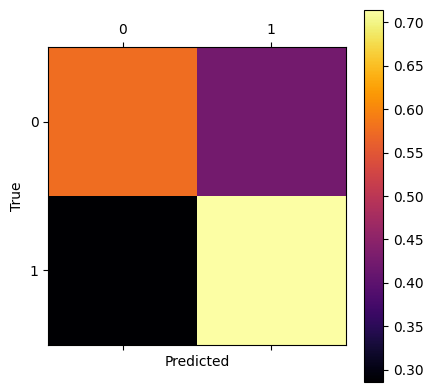

For feature space:  15  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.6018518518518517
[[0.5        0.5       ]
 [0.21428571 0.78571429]]


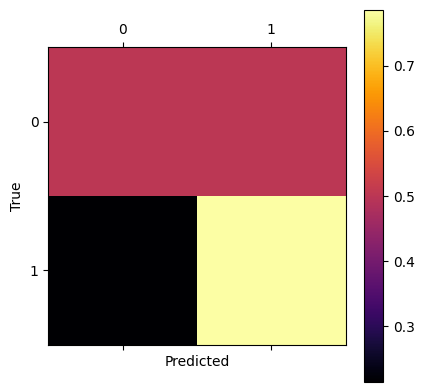

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6712962962962963
[[0.69230769 0.30769231]
 [0.25       0.75      ]]


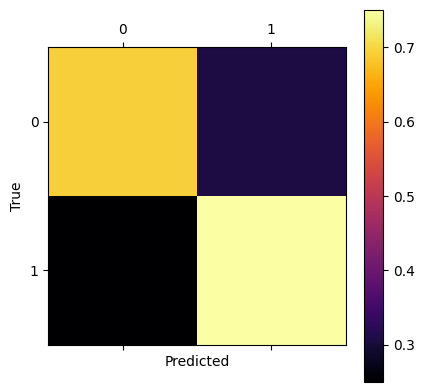

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5648148148148148
[[0.65384615 0.34615385]
 [0.35714286 0.64285714]]


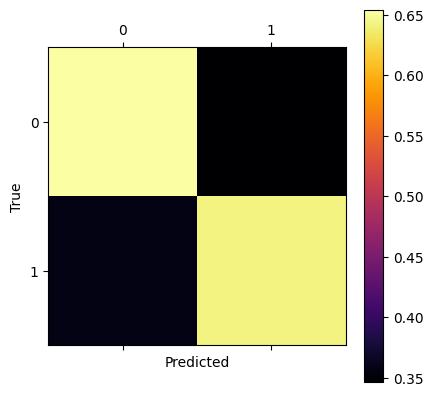

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5393518518518519
[[0.57692308 0.42307692]
 [0.39285714 0.60714286]]


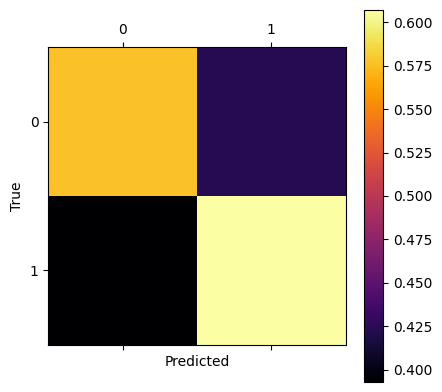

100%|██████████| 540/540 [01:29<00:00,  6.01it/s]


For feature space:  15  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.5879629629629629
[[0.57692308 0.42307692]
 [0.35714286 0.64285714]]


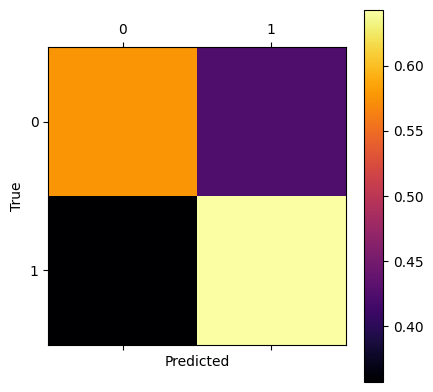

For feature space:  15  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.4930555555555555
[[0.73076923 0.26923077]
 [0.57142857 0.42857143]]


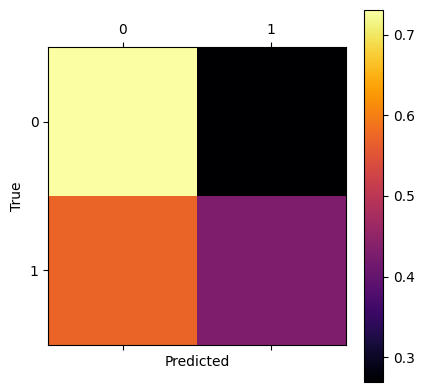

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.625
[[0.65384615 0.34615385]
 [0.21428571 0.78571429]]


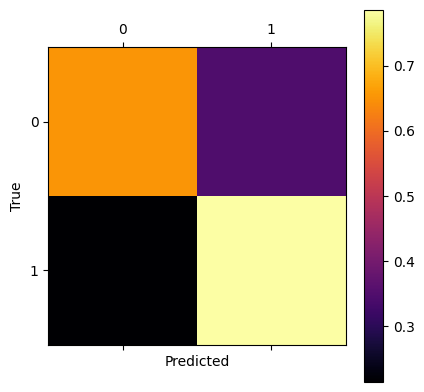

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.5879629629629629
[[0.61538462 0.38461538]
 [0.35714286 0.64285714]]


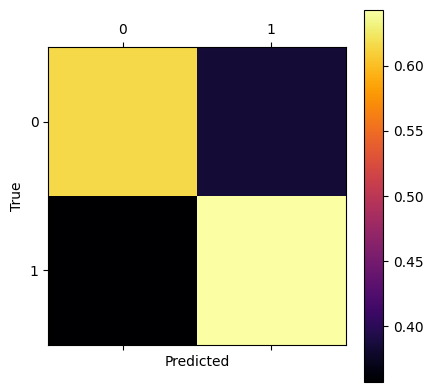

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6041666666666666
[[0.61538462 0.38461538]
 [0.39285714 0.60714286]]


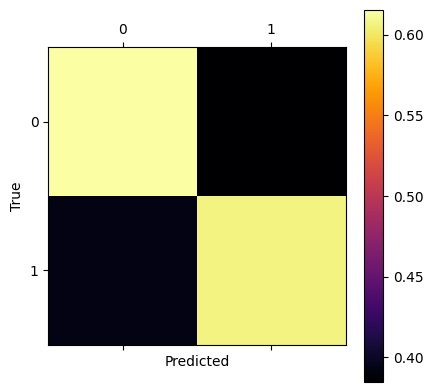

100%|██████████| 540/540 [01:29<00:00,  6.04it/s]


For feature space:  15  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.5671296296296297
[[0.5        0.5       ]
 [0.39285714 0.60714286]]


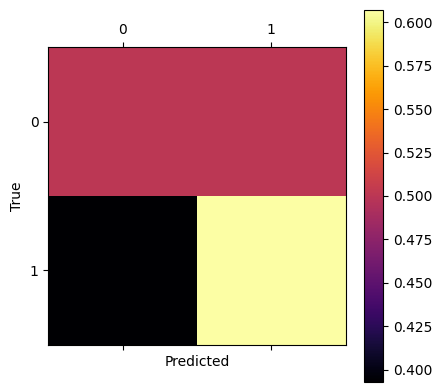

For feature space:  15  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5231481481481481
[[0.76923077 0.23076923]
 [0.53571429 0.46428571]]


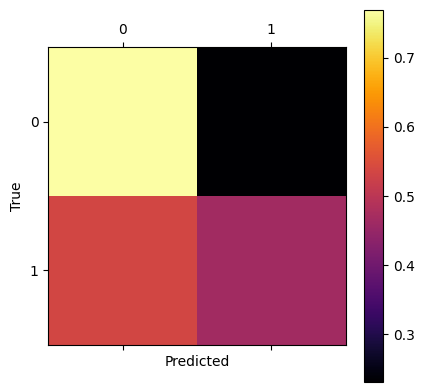

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6504629629629629
[[0.65384615 0.34615385]
 [0.17857143 0.82142857]]


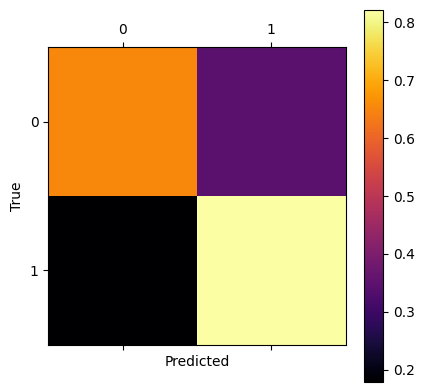

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.5694444444444445
[[0.53846154 0.46153846]
 [0.39285714 0.60714286]]


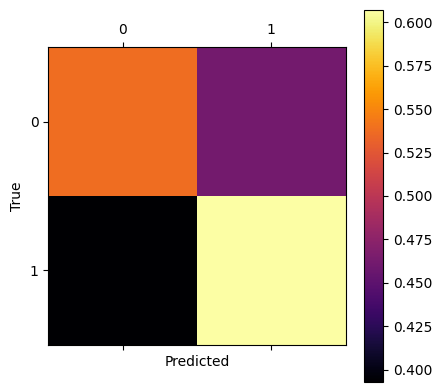

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.5810185185185185
[[0.61538462 0.38461538]
 [0.39285714 0.60714286]]


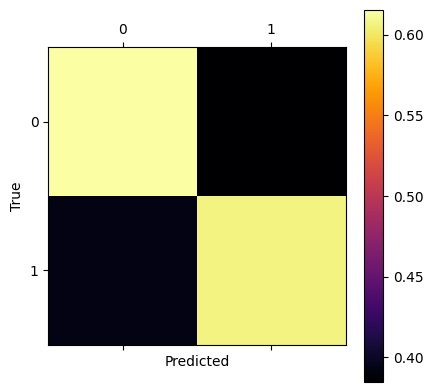

100%|██████████| 540/540 [01:19<00:00,  6.76it/s]


For feature space:  20  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.5902777777777778
[[0.61538462 0.38461538]
 [0.39285714 0.60714286]]


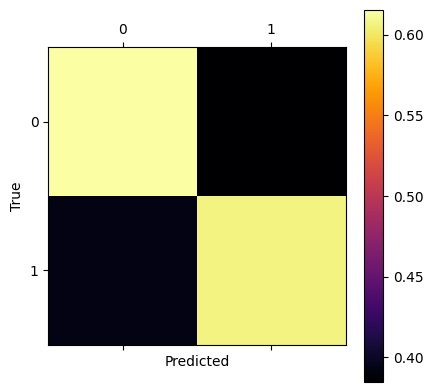

For feature space:  20  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6574074074074074
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


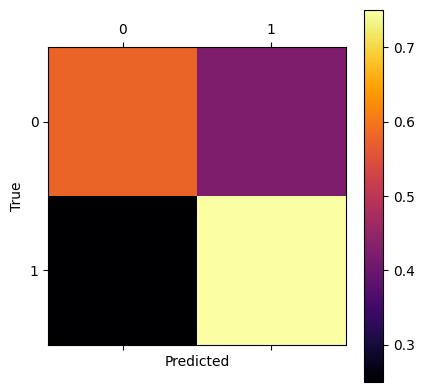

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6921296296296297
[[0.61538462 0.38461538]
 [0.28571429 0.71428571]]


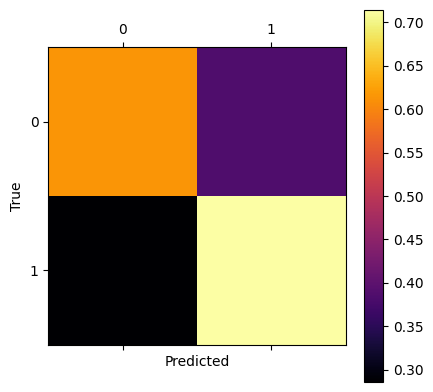

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6388888888888888
[[0.53846154 0.46153846]
 [0.14285714 0.85714286]]


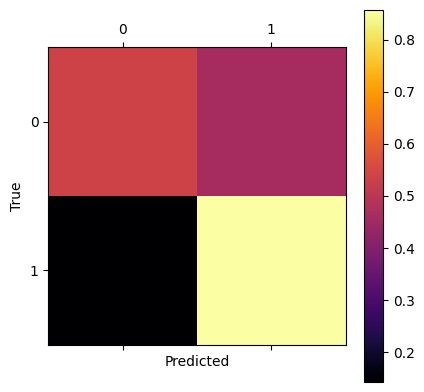

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.6597222222222222
[[0.46153846 0.53846154]
 [0.21428571 0.78571429]]


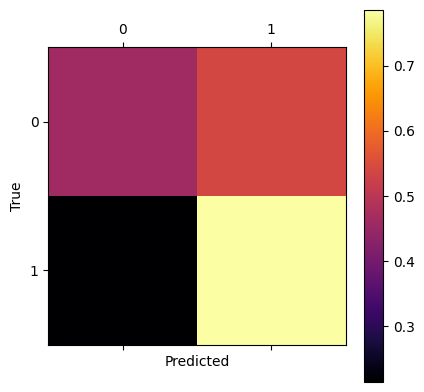

100%|██████████| 540/540 [01:19<00:00,  6.83it/s]


For feature space:  20  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.4976851851851852
[[0.57692308 0.42307692]
 [0.42857143 0.57142857]]


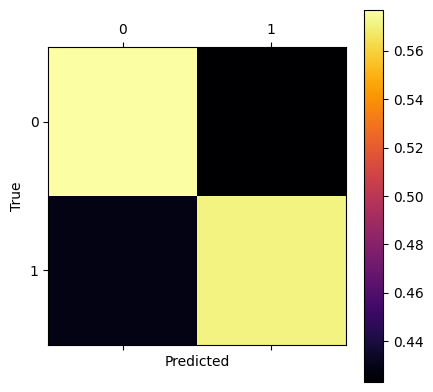

For feature space:  20  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6203703703703703
[[0.57692308 0.42307692]
 [0.21428571 0.78571429]]


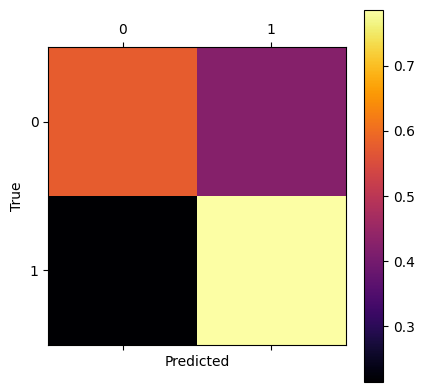

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6388888888888888
[[0.53846154 0.46153846]
 [0.25       0.75      ]]


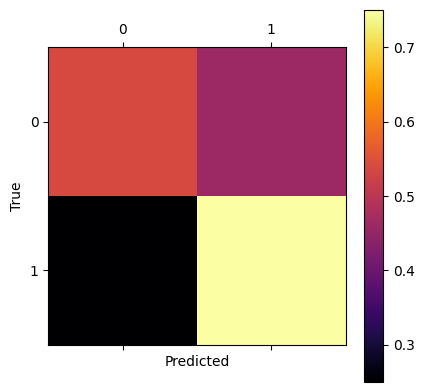

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.48148148148148145
Accuracy on training set:	 0.5787037037037037
[[0.38461538 0.61538462]
 [0.32142857 0.67857143]]


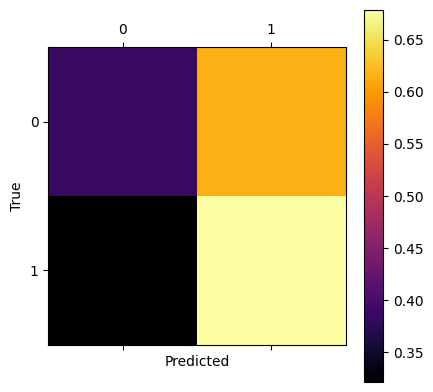

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.6134259259259259
[[0.42307692 0.57692308]
 [0.32142857 0.67857143]]


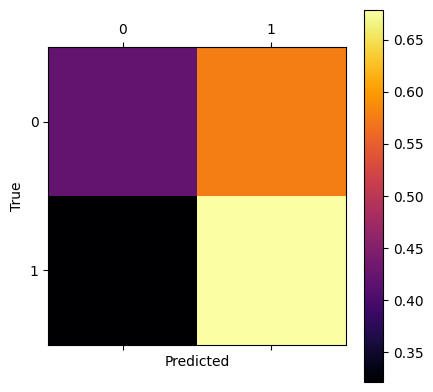

100%|██████████| 540/540 [01:21<00:00,  6.61it/s]


For feature space:  20  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.5231481481481481
[[0.80769231 0.19230769]
 [0.21428571 0.78571429]]


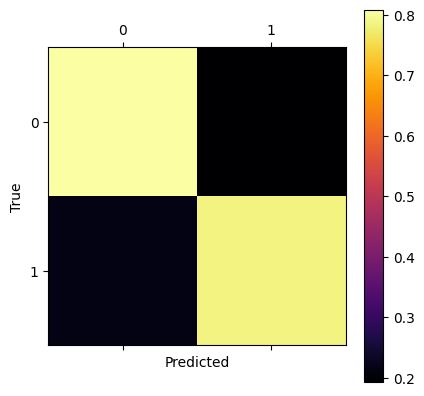

For feature space:  20  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6087962962962963
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


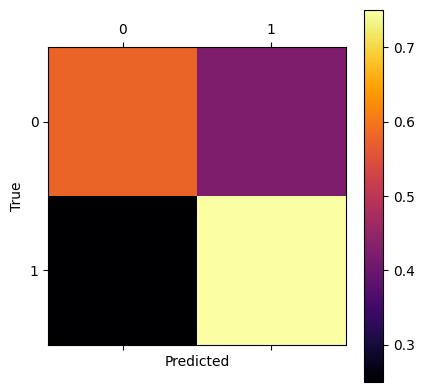

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.664351851851852
[[0.69230769 0.30769231]
 [0.17857143 0.82142857]]


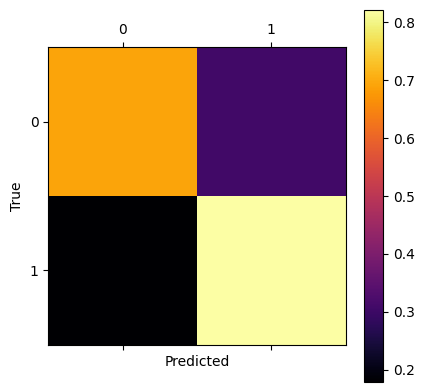

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.576388888888889
[[0.5        0.5       ]
 [0.28571429 0.71428571]]


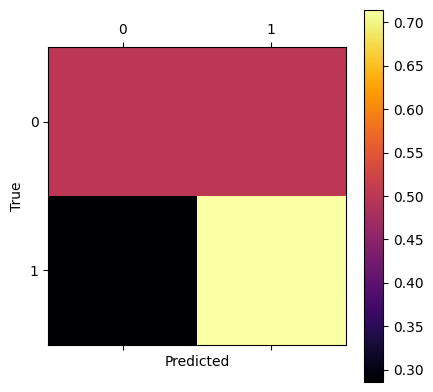

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.6134259259259259
[[0.46153846 0.53846154]
 [0.28571429 0.71428571]]


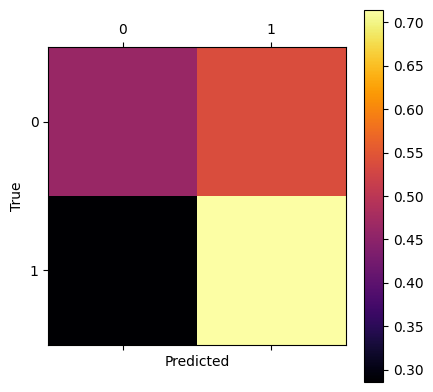

100%|██████████| 540/540 [01:18<00:00,  6.86it/s]


For feature space:  30  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.6620370370370371
[[0.57692308 0.42307692]
 [0.21428571 0.78571429]]


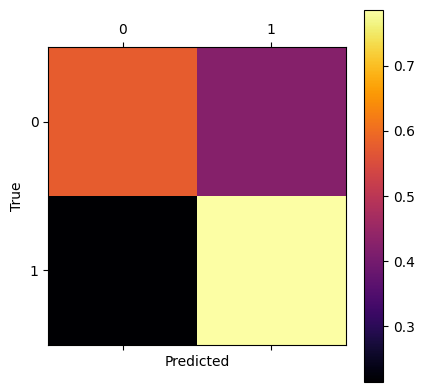

For feature space:  30  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6134259259259259
[[0.73076923 0.26923077]
 [0.25       0.75      ]]


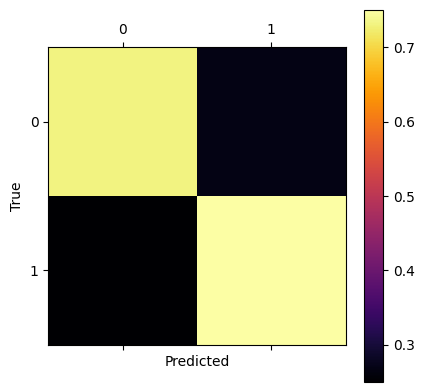

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.6620370370370371
[[0.57692308 0.42307692]
 [0.14285714 0.85714286]]


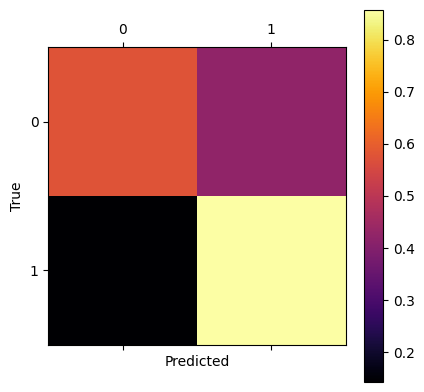

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6712962962962963
[[0.61538462 0.38461538]
 [0.25       0.75      ]]


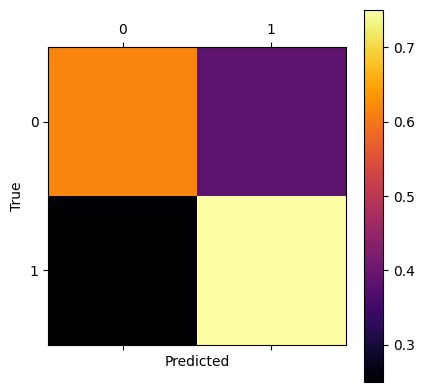

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6620370370370371
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


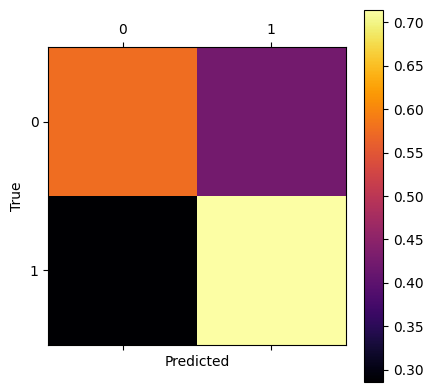

100%|██████████| 540/540 [01:19<00:00,  6.78it/s]


For feature space:  30  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.5995370370370371
[[0.53846154 0.46153846]
 [0.5        0.5       ]]


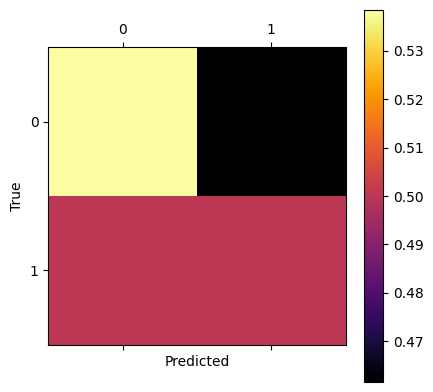

For feature space:  30  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.5879629629629629
[[0.69230769 0.30769231]
 [0.35714286 0.64285714]]


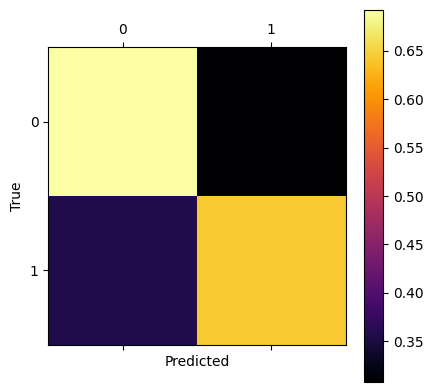

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.6134259259259259
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


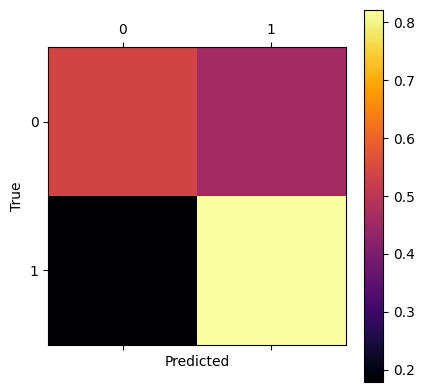

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6527777777777778
[[0.53846154 0.46153846]
 [0.28571429 0.71428571]]


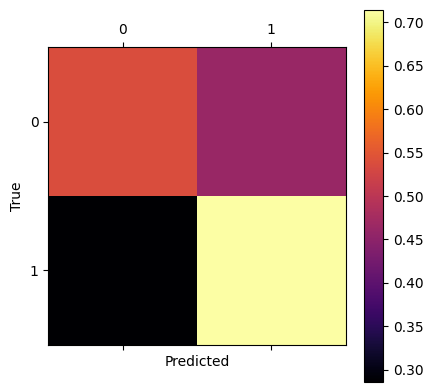

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.6504629629629629
[[0.53846154 0.46153846]
 [0.28571429 0.71428571]]


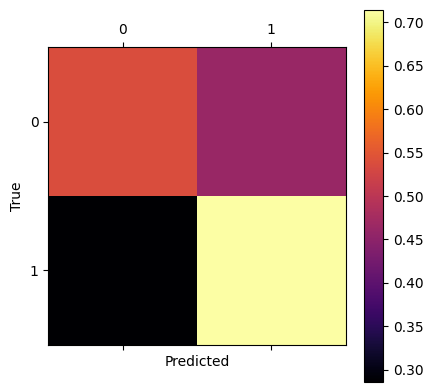

100%|██████████| 540/540 [01:19<00:00,  6.79it/s]


For feature space:  30  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.6203703703703703
[[0.61538462 0.38461538]
 [0.5        0.5       ]]


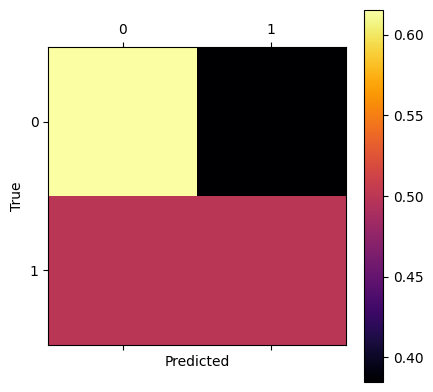

For feature space:  30  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6041666666666666
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


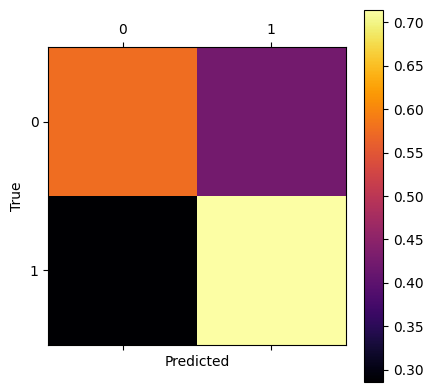

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6157407407407408
[[0.5        0.5       ]
 [0.14285714 0.85714286]]


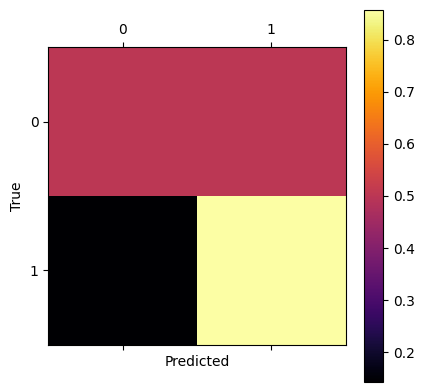

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6504629629629629
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


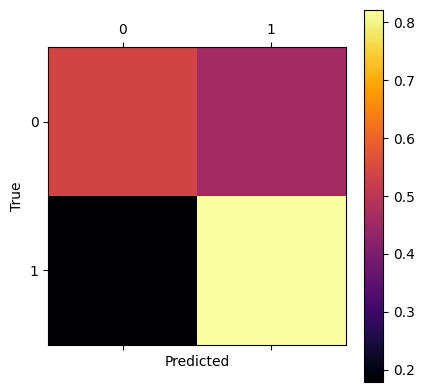

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.6504629629629629
[[0.46153846 0.53846154]
 [0.14285714 0.85714286]]


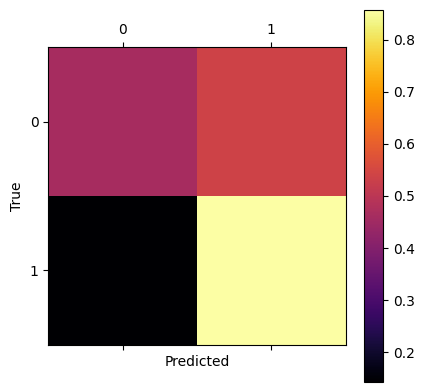

100%|██████████| 540/540 [01:16<00:00,  7.06it/s]


For feature space:  50  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.6296296296296297
[[0.46153846 0.53846154]
 [0.25       0.75      ]]


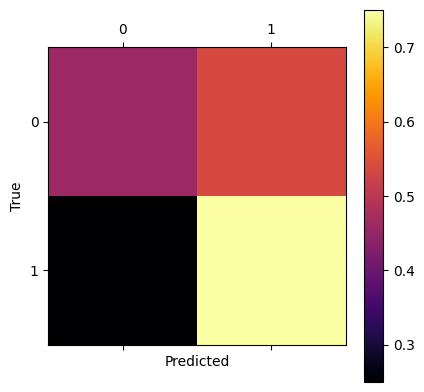

For feature space:  50  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.6388888888888888
[[0.76923077 0.23076923]
 [0.35714286 0.64285714]]


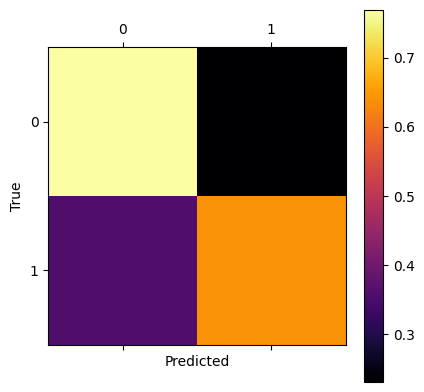

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.7199074074074074
[[0.69230769 0.30769231]
 [0.25       0.75      ]]


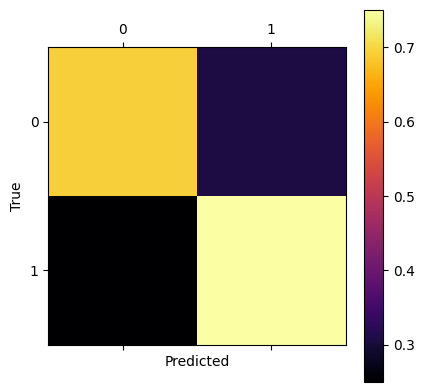

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5023148148148149
[[0.96153846 0.03846154]
 [0.78571429 0.21428571]]


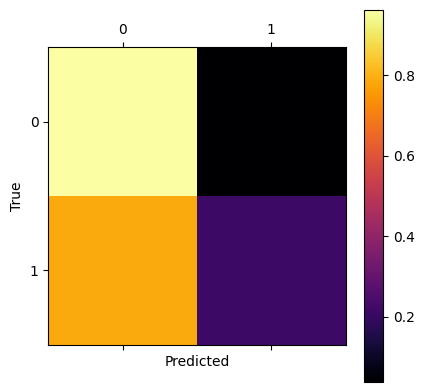

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.4976851851851852
[[0.96153846 0.03846154]
 [0.78571429 0.21428571]]


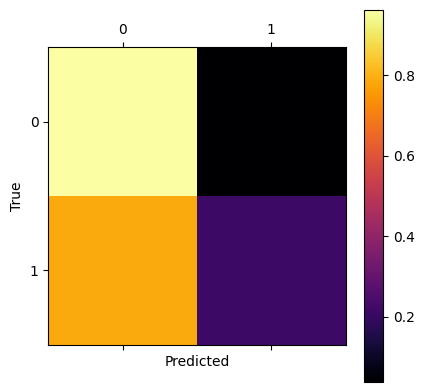

100%|██████████| 540/540 [01:18<00:00,  6.89it/s]


For feature space:  50  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5532407407407407
[[0.53846154 0.46153846]
 [0.32142857 0.67857143]]


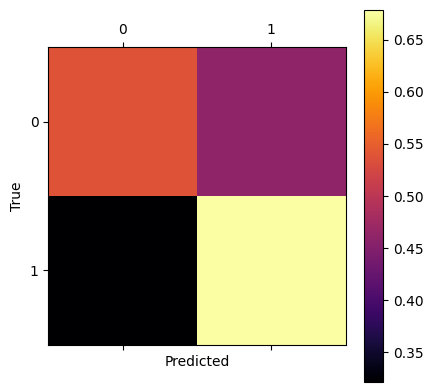

For feature space:  50  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.5509259259259259
[[0.5        0.5       ]
 [0.46428571 0.53571429]]


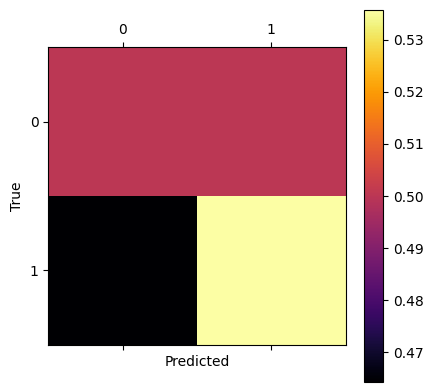

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6875
[[0.53846154 0.46153846]
 [0.14285714 0.85714286]]


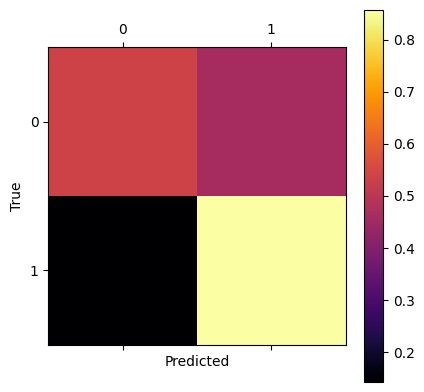

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.513888888888889
[[0.84615385 0.15384615]
 [0.71428571 0.28571429]]


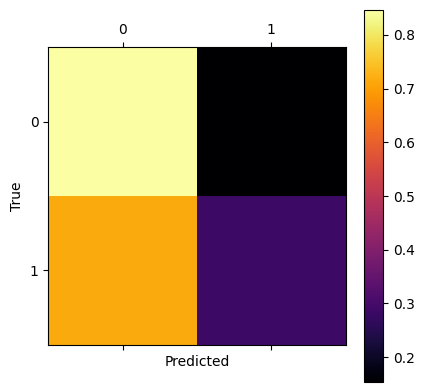

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5462962962962964
[[0.84615385 0.15384615]
 [0.75       0.25      ]]


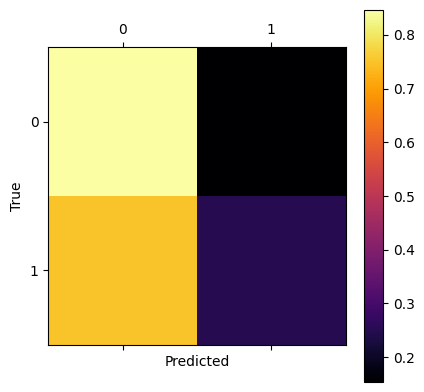

100%|██████████| 540/540 [01:16<00:00,  7.04it/s]


For feature space:  50  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.5902777777777778
[[0.5        0.5       ]
 [0.14285714 0.85714286]]


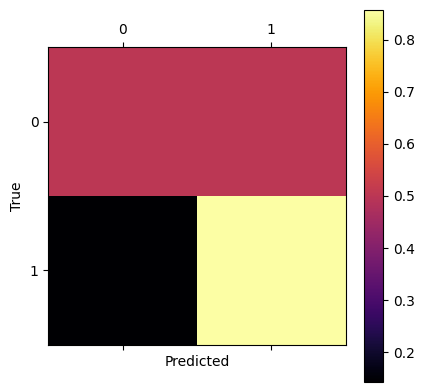

For feature space:  50  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.5625
[[0.73076923 0.26923077]
 [0.32142857 0.67857143]]


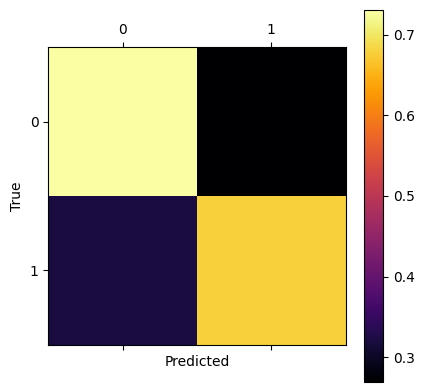

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.6643518518518519
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


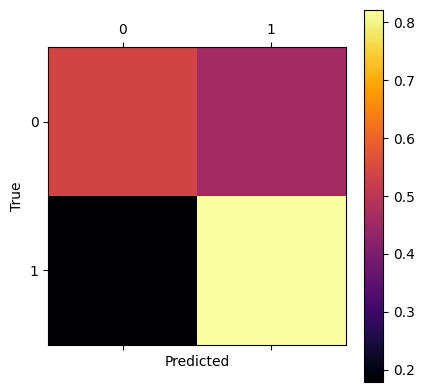

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5902777777777778
[[0.76923077 0.23076923]
 [0.71428571 0.28571429]]


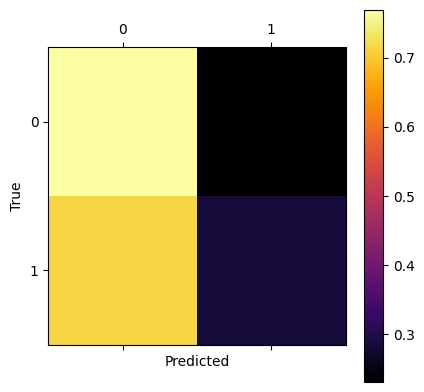

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5555555555555555
[[0.88461538 0.11538462]
 [0.78571429 0.21428571]]


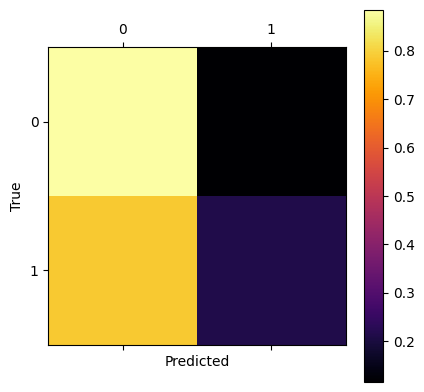

In [85]:
features = [15,20,30,50]
cutoff = [40e6, 80e6, 120e6]
structure = [(30,), (40,), (20,10), (10,10,10), (10,10,5,5) ]
acc = np.zeros((len(features), len(cutoff), len(structure)))
for i, f in enumerate(features):
    for j, c in enumerate(cutoff):
        lassi = speechClassifierBinary("./waveforms_r6p8_fast/", feature_space=f, cutoff=c, ch=0)
        for k, s in enumerate(structure):
            print("For feature space: ", f, " and cutoff: ", c, " and structure: ", s)
            acc[i,j, k], _ = lassi.clf(layers=s)
            lassi.confmat(struct=s)

In [86]:
# Find the 5 highest accuracies
acc_temp = acc.copy()
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])

(0, 0, 2) 0.6944444444444444 15 40000000.0 (20, 10)
(2, 0, 1) 0.6944444444444444 30 40000000.0 (40,)
(2, 1, 4) 0.6944444444444444 30 80000000.0 (10, 10, 5, 5)
(1, 2, 2) 0.6851851851851852 20 120000000.0 (20, 10)
(0, 1, 4) 0.6759259259259259 15 80000000.0 (10, 10, 5, 5)


100%|██████████| 540/540 [01:14<00:00,  7.25it/s]


For feature space:  15  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.7037037037037037
Accuracy on training set:	 0.6203703703703703
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


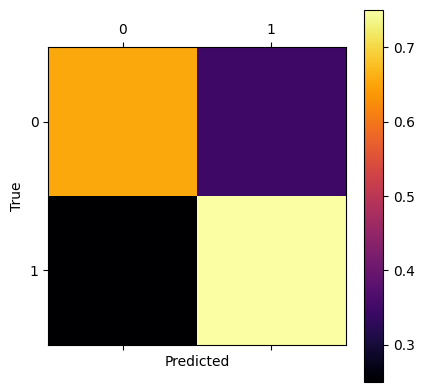

For feature space:  15  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.5740740740740741
[[0.65384615 0.34615385]
 [0.39285714 0.60714286]]


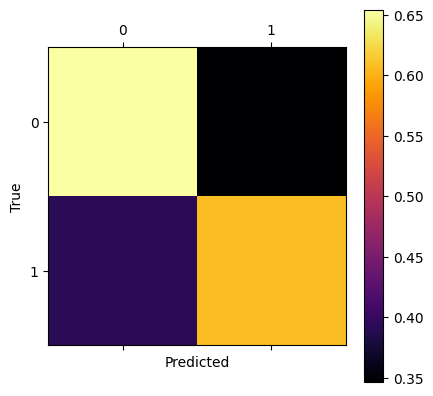

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.7685185185185185
Accuracy on training set:	 0.6759259259259259
[[0.73076923 0.26923077]
 [0.21428571 0.78571429]]


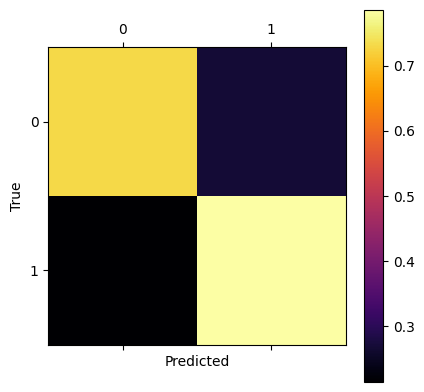

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.5277777777777778
[[0.73076923 0.26923077]
 [0.39285714 0.60714286]]


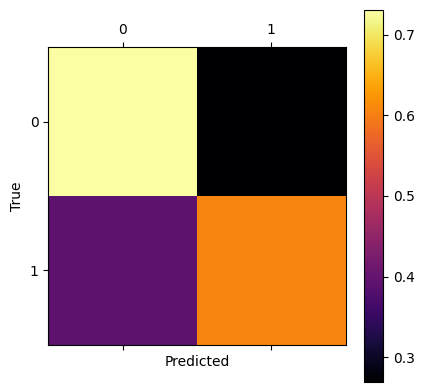

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.5046296296296297
[[0.73076923 0.26923077]
 [0.42857143 0.57142857]]


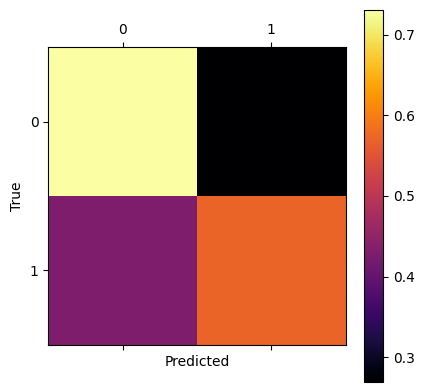

100%|██████████| 540/540 [00:55<00:00,  9.65it/s]


For feature space:  15  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5625
[[0.34615385 0.65384615]
 [0.32142857 0.67857143]]


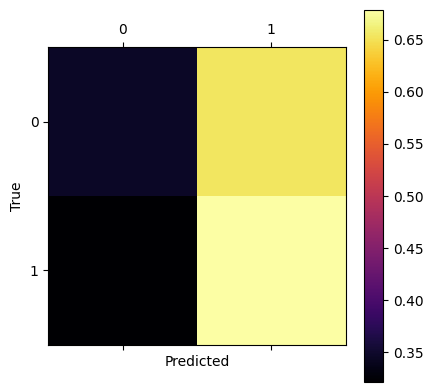

For feature space:  15  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.48148148148148145
Accuracy on training set:	 0.40972222222222215
[[0.5        0.5       ]
 [0.46428571 0.53571429]]


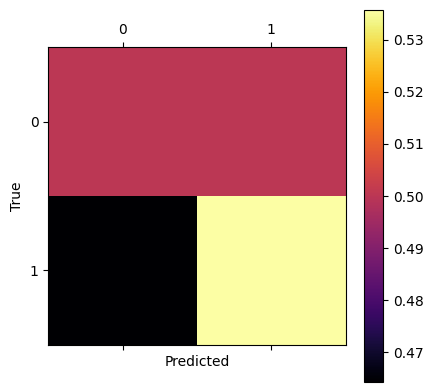

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6041666666666666
[[0.76923077 0.23076923]
 [0.5        0.5       ]]


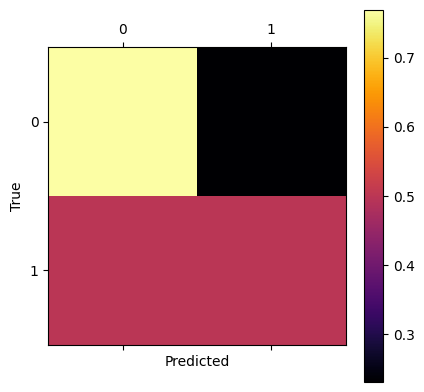

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.488425925925926
[[0.42307692 0.57692308]
 [0.25       0.75      ]]


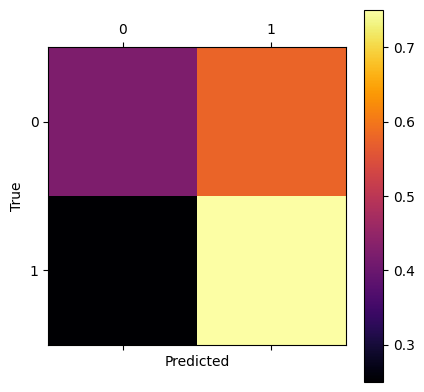

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.47222222222222227
[[0.73076923 0.26923077]
 [0.57142857 0.42857143]]


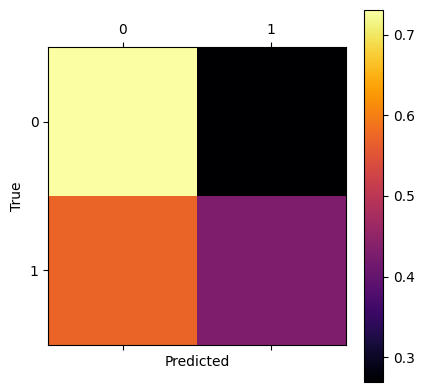

100%|██████████| 540/540 [00:55<00:00,  9.76it/s]


For feature space:  15  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.5648148148148148
[[0.46153846 0.53846154]
 [0.46428571 0.53571429]]


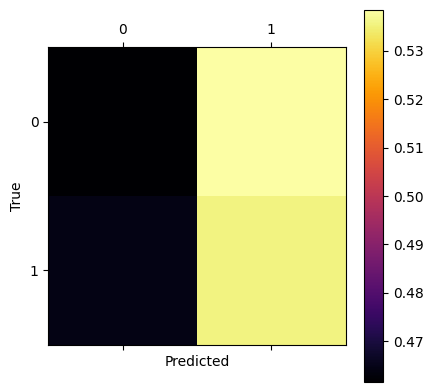

For feature space:  15  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.40509259259259256
[[0.5        0.5       ]
 [0.39285714 0.60714286]]


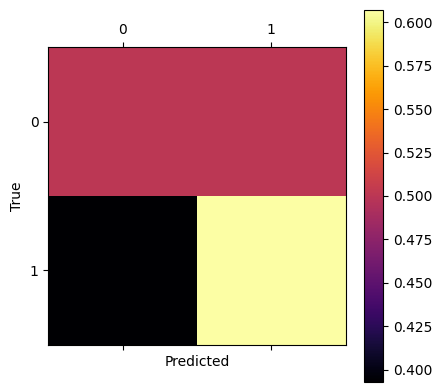

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.5347222222222222
[[0.76923077 0.23076923]
 [0.5        0.5       ]]


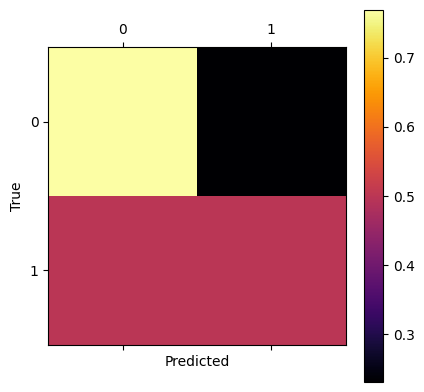

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.46759259259259256
[[0.69230769 0.30769231]
 [0.5        0.5       ]]


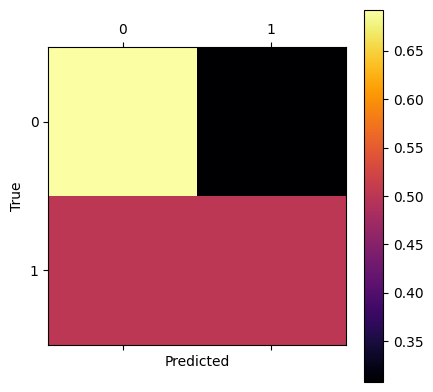

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.5
[[0.65384615 0.34615385]
 [0.53571429 0.46428571]]


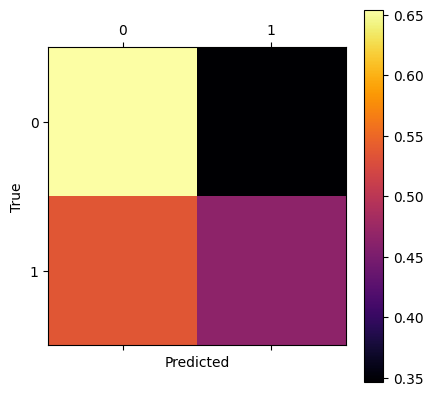

100%|██████████| 540/540 [00:44<00:00, 12.06it/s]


For feature space:  20  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.611111111111111
[[0.73076923 0.26923077]
 [0.42857143 0.57142857]]


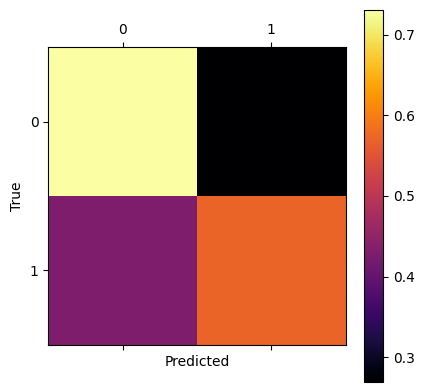

For feature space:  20  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.6435185185185186
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


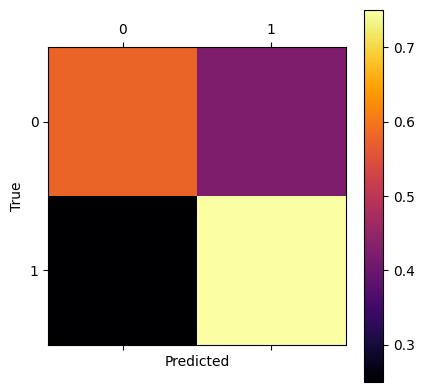

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6944444444444443
[[0.65384615 0.34615385]
 [0.21428571 0.78571429]]


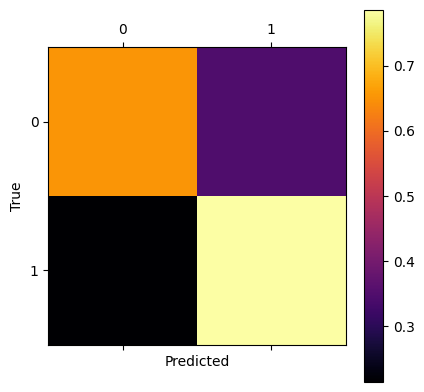

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.648148148148148
[[0.57692308 0.42307692]
 [0.39285714 0.60714286]]


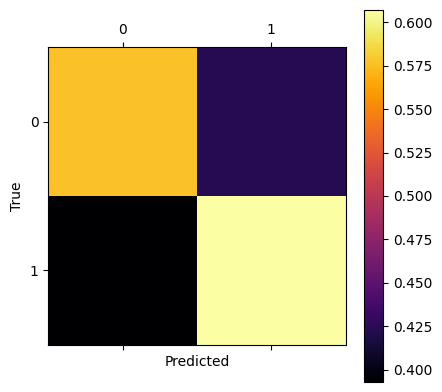

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.6481481481481481
[[0.61538462 0.38461538]
 [0.42857143 0.57142857]]


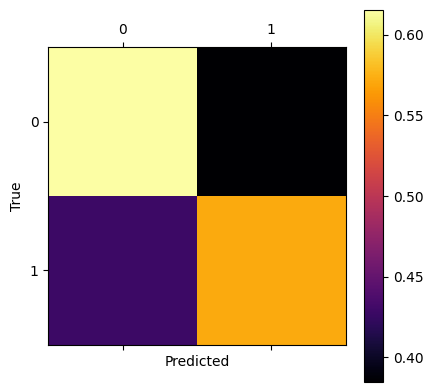

100%|██████████| 540/540 [00:45<00:00, 11.84it/s]


For feature space:  20  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.5277777777777778
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


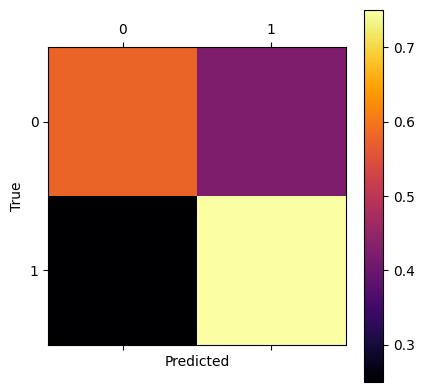

For feature space:  20  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5138888888888888
[[0.65384615 0.34615385]
 [0.5        0.5       ]]


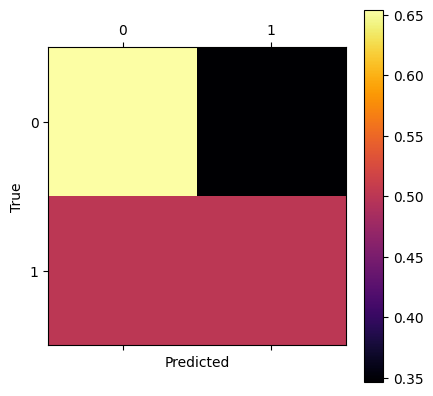

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.5902777777777777
[[0.42307692 0.57692308]
 [0.25       0.75      ]]


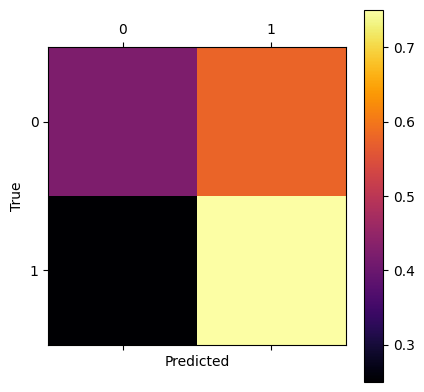

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5810185185185185
[[0.5        0.5       ]
 [0.32142857 0.67857143]]


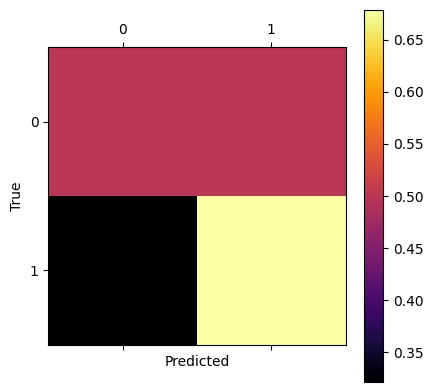

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.5648148148148148
[[0.5        0.5       ]
 [0.39285714 0.60714286]]


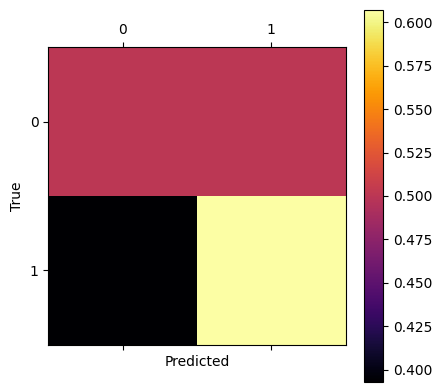

100%|██████████| 540/540 [00:46<00:00, 11.57it/s]


For feature space:  20  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5277777777777778
[[0.57692308 0.42307692]
 [0.42857143 0.57142857]]


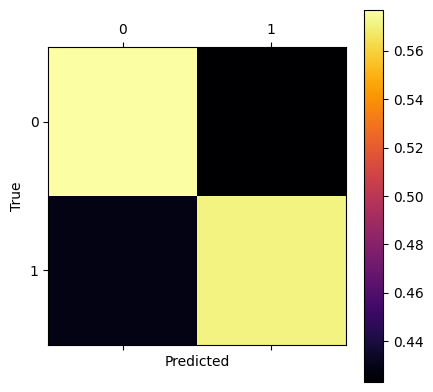

For feature space:  20  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.5254629629629629
[[0.80769231 0.19230769]
 [0.5        0.5       ]]


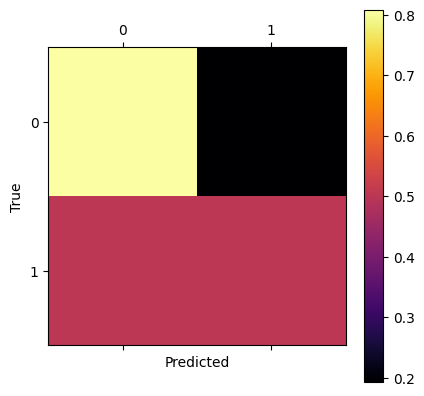

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5486111111111112
[[0.42307692 0.57692308]
 [0.21428571 0.78571429]]


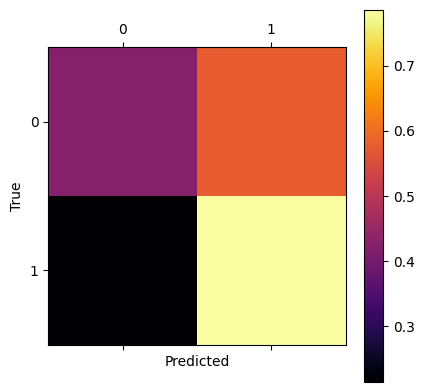

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.6064814814814815
[[0.42307692 0.57692308]
 [0.35714286 0.64285714]]


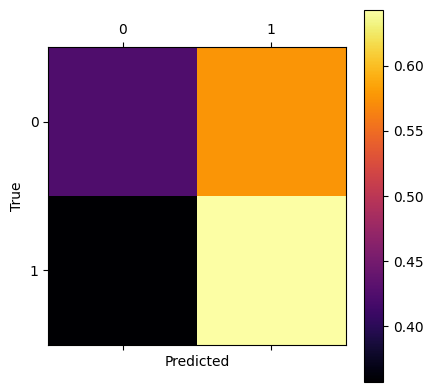

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5555555555555555
[[0.34615385 0.65384615]
 [0.28571429 0.71428571]]


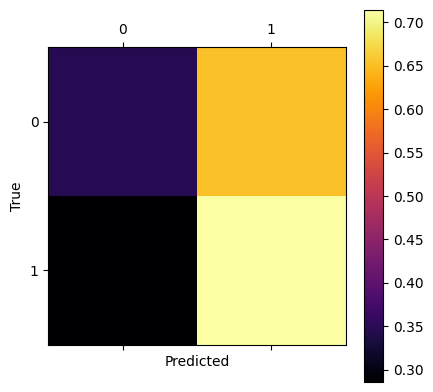

100%|██████████| 540/540 [00:48<00:00, 11.08it/s]


For feature space:  30  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.726851851851852
[[0.61538462 0.38461538]
 [0.17857143 0.82142857]]


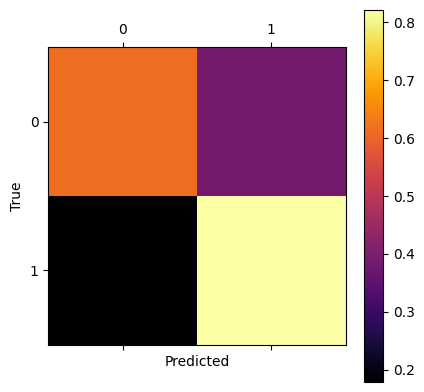

For feature space:  30  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.7129629629629629
Accuracy on training set:	 0.6666666666666666
[[0.76923077 0.23076923]
 [0.21428571 0.78571429]]


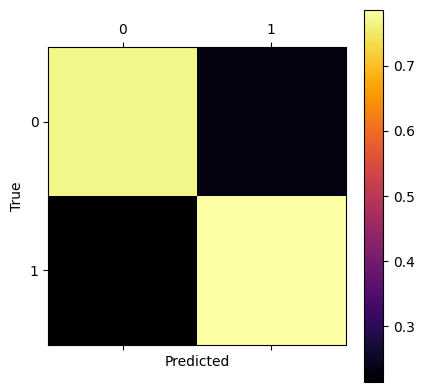

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6712962962962963
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


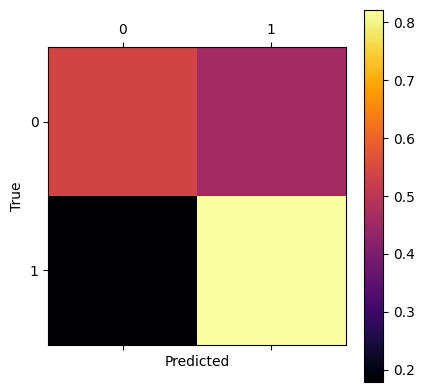

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.6921296296296297
[[0.61538462 0.38461538]
 [0.35714286 0.64285714]]


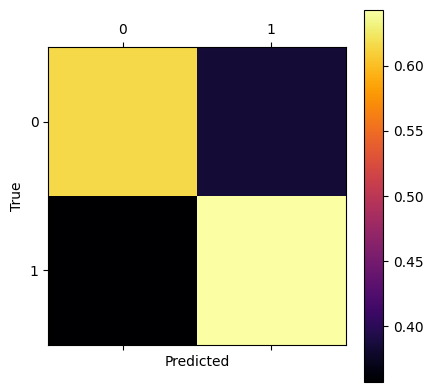

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6944444444444444
Accuracy on training set:	 0.7013888888888888
[[0.65384615 0.34615385]
 [0.32142857 0.67857143]]


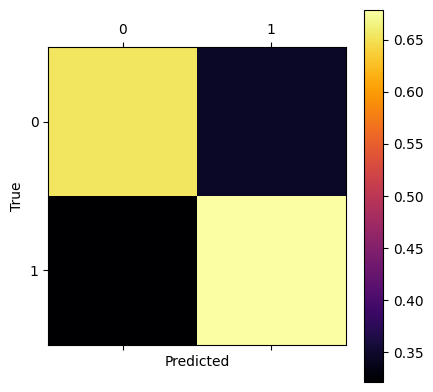

100%|██████████| 540/540 [00:48<00:00, 11.18it/s]


For feature space:  30  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.548611111111111
[[0.5        0.5       ]
 [0.42857143 0.57142857]]


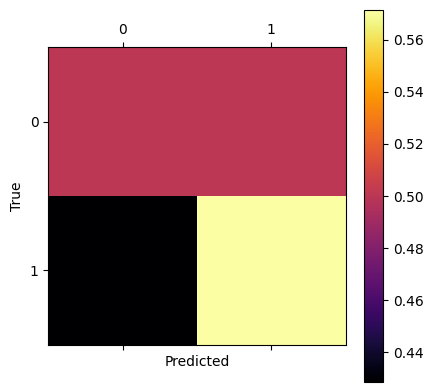

For feature space:  30  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.5648148148148148
[[0.65384615 0.34615385]
 [0.42857143 0.57142857]]


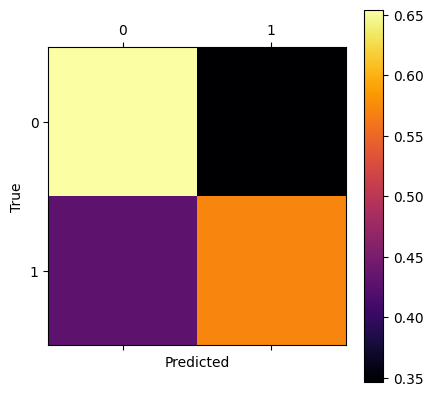

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.5092592592592593
[[0.42307692 0.57692308]
 [0.03571429 0.96428571]]


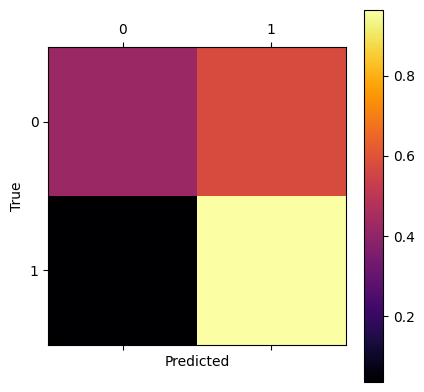

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.5601851851851852
[[0.42307692 0.57692308]
 [0.10714286 0.89285714]]


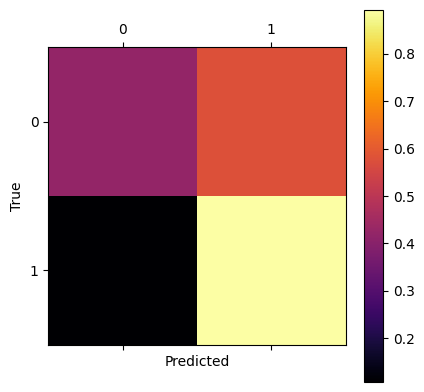

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.5925925925925926
[[0.42307692 0.57692308]
 [0.14285714 0.85714286]]


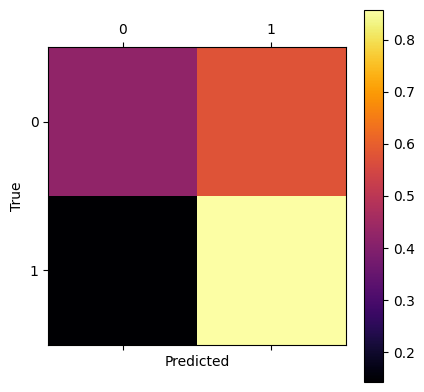

100%|██████████| 540/540 [01:01<00:00,  8.73it/s]


For feature space:  30  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.5231481481481483
[[0.53846154 0.46153846]
 [0.42857143 0.57142857]]


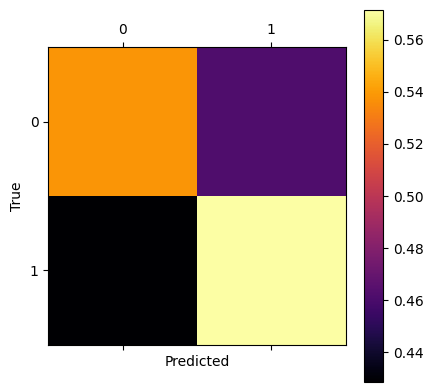

For feature space:  30  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5439814814814815
[[0.57692308 0.42307692]
 [0.53571429 0.46428571]]


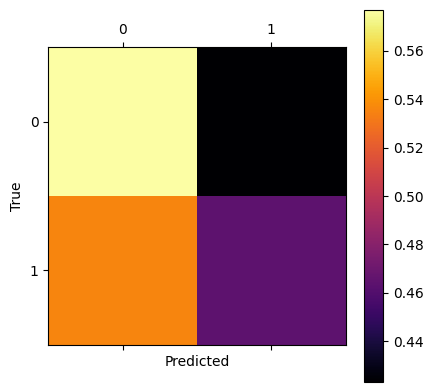

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.5324074074074074
[[0.46153846 0.53846154]
 [0.17857143 0.82142857]]


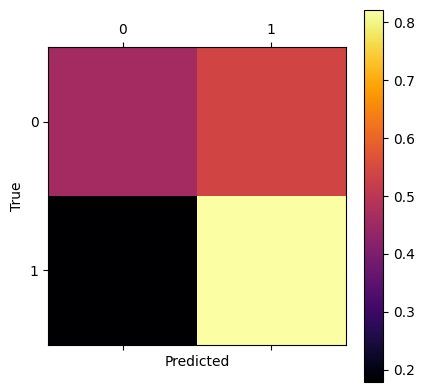

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6481481481481481
Accuracy on training set:	 0.5439814814814815
[[0.5        0.5       ]
 [0.32142857 0.67857143]]


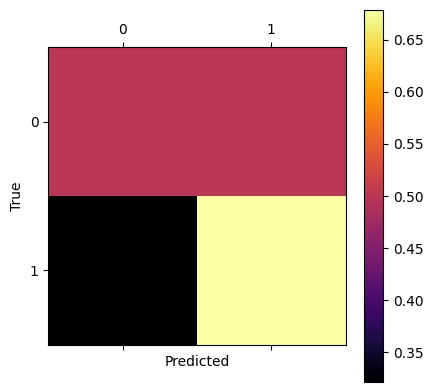

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.548611111111111
[[0.46153846 0.53846154]
 [0.25       0.75      ]]


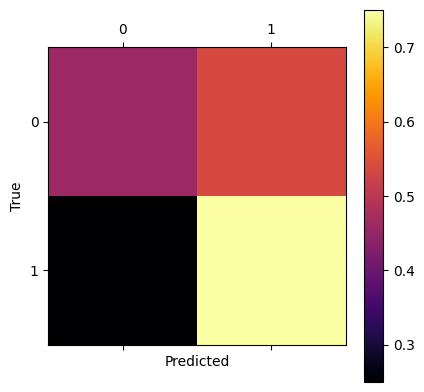

100%|██████████| 540/540 [01:01<00:00,  8.81it/s]


For feature space:  50  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5092592592592592
[[0.5  0.5 ]
 [0.25 0.75]]


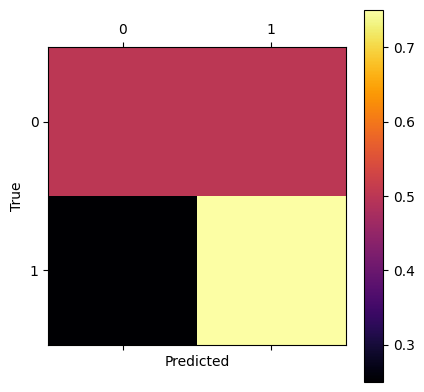

For feature space:  50  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.6018518518518519
[[0.57692308 0.42307692]
 [0.32142857 0.67857143]]


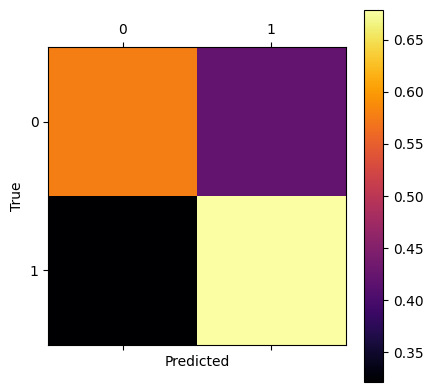

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6666666666666666
[[0.57692308 0.42307692]
 [0.32142857 0.67857143]]


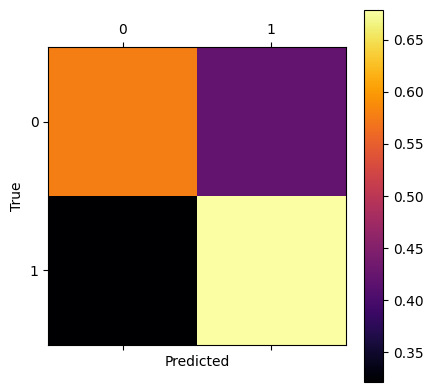

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.5347222222222223
[[0.84615385 0.15384615]
 [0.71428571 0.28571429]]


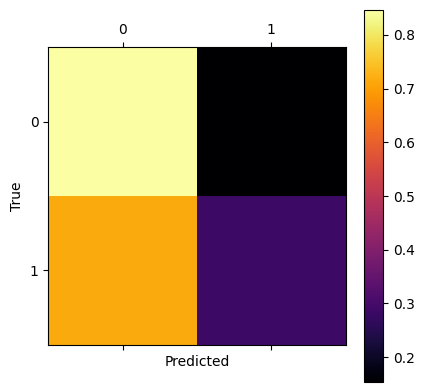

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.5277777777777778
[[0.88461538 0.11538462]
 [0.71428571 0.28571429]]


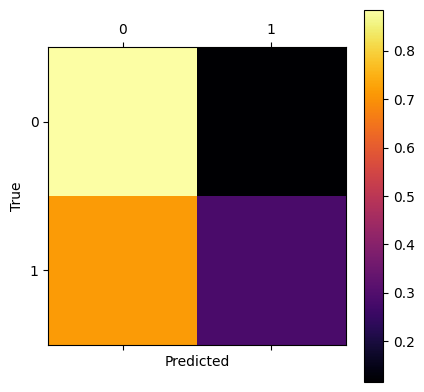

100%|██████████| 540/540 [00:45<00:00, 11.97it/s]


For feature space:  50  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.47453703703703703
[[0.38461538 0.61538462]
 [0.32142857 0.67857143]]


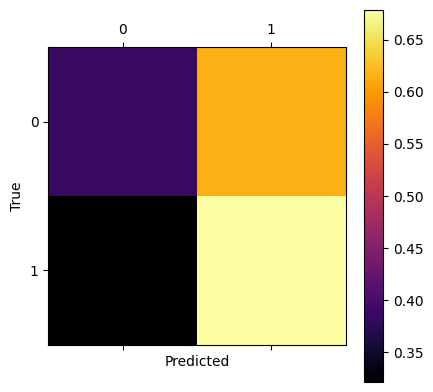

For feature space:  50  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.4074074074074074
Accuracy on training set:	 0.49074074074074076
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


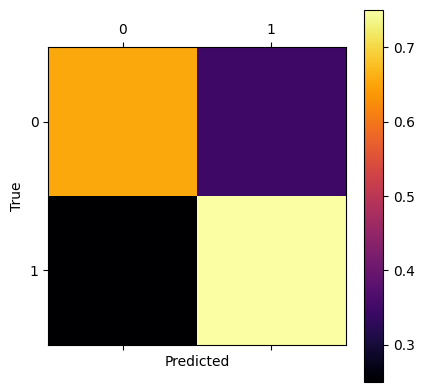

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.6342592592592592
[[0.46153846 0.53846154]
 [0.28571429 0.71428571]]


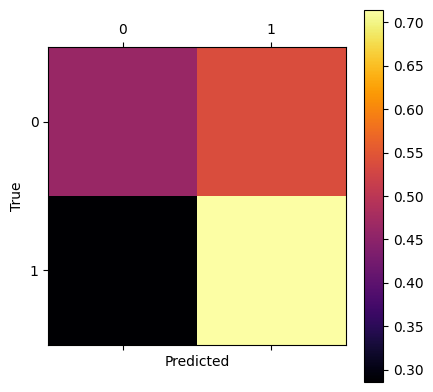

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.4837962962962963
[[1.         0.        ]
 [0.89285714 0.10714286]]


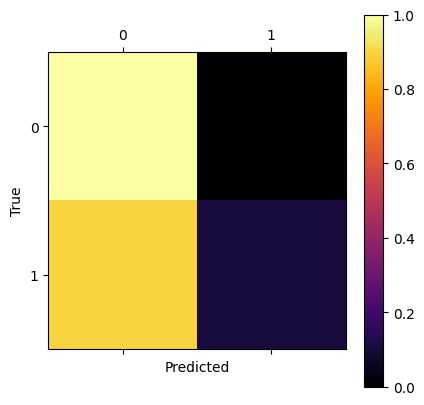

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.4791666666666667
[[0.26923077 0.73076923]
 [0.03571429 0.96428571]]


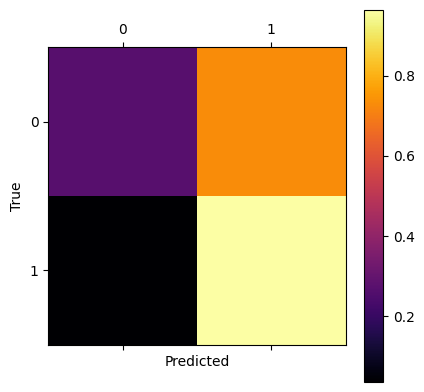

100%|██████████| 540/540 [00:45<00:00, 11.86it/s]


For feature space:  50  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.4953703703703704
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


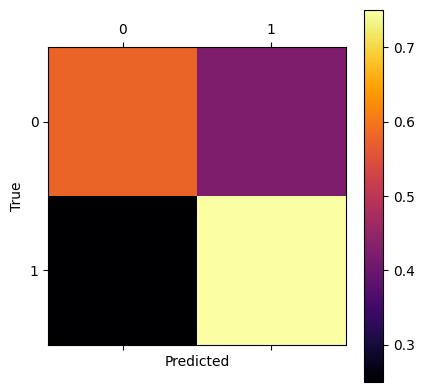

For feature space:  50  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.5393518518518519
[[0.57692308 0.42307692]
 [0.25       0.75      ]]


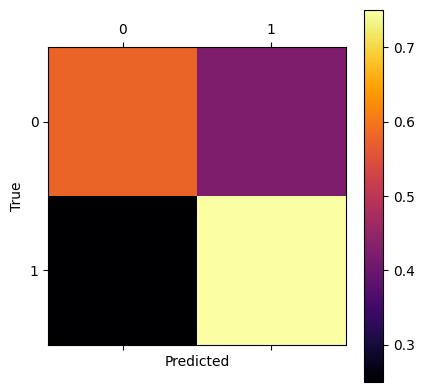

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5902777777777778
[[0.38461538 0.61538462]
 [0.28571429 0.71428571]]


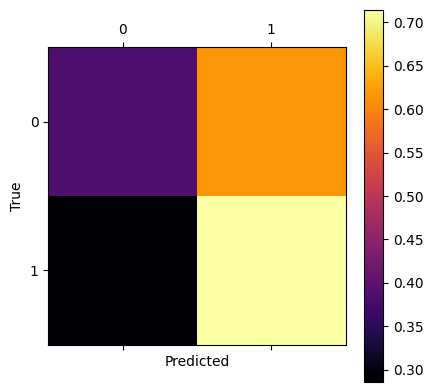

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.4861111111111111
[[0.88461538 0.11538462]
 [0.75       0.25      ]]


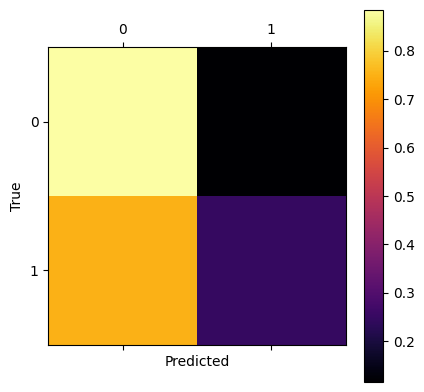

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5092592592592592
[[0.88461538 0.11538462]
 [0.75       0.25      ]]


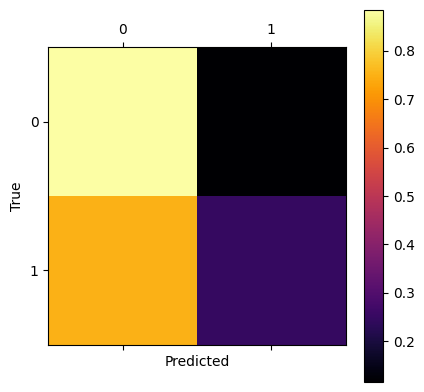

In [87]:
features = [15,20,30,50]
cutoff = [40e6, 80e6, 120e6]
structure = [(30,), (40,), (20,10), (10,10,10), (10,10,5,5) ]
acc = np.zeros((len(features), len(cutoff), len(structure)))
for i, f in enumerate(features):
    for j, c in enumerate(cutoff):
        lassi = speechClassifierBinary("./waveforms_r6p7_fast/", feature_space=f, cutoff=c, ch=0)
        for k, s in enumerate(structure):
            print("For feature space: ", f, " and cutoff: ", c, " and structure: ", s)
            acc[i,j, k], _ = lassi.clf(layers=s)
            lassi.confmat(struct=s)

In [88]:
# Find the 5 highest accuracies
acc_temp = acc.copy()
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])

(0, 0, 2) 0.7685185185185185 15 40000000.0 (20, 10)
(2, 0, 1) 0.7129629629629629 30 40000000.0 (40,)
(0, 0, 0) 0.7037037037037037 15 40000000.0 (30,)
(2, 0, 4) 0.6944444444444444 30 40000000.0 (10, 10, 5, 5)
(2, 0, 3) 0.6851851851851852 30 40000000.0 (10, 10, 10)


100%|██████████| 540/540 [01:46<00:00,  5.07it/s]


For feature space:  15  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6689814814814814
[[0.61538462 0.38461538]
 [0.17857143 0.82142857]]


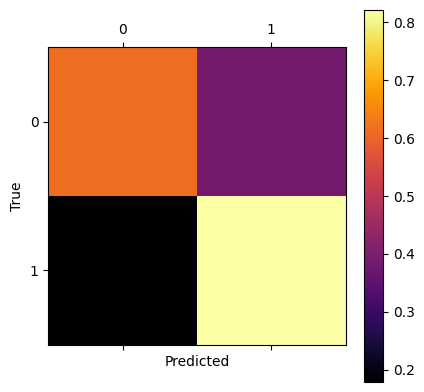

For feature space:  15  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.6087962962962963
[[0.65384615 0.34615385]
 [0.39285714 0.60714286]]


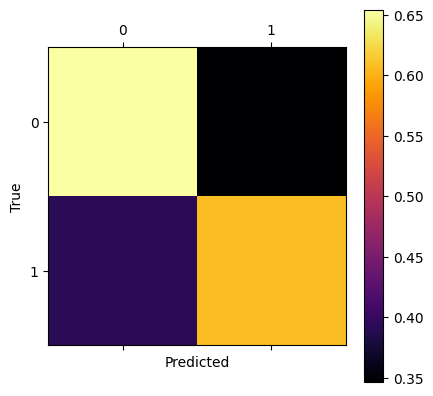

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.7777777777777778
Accuracy on training set:	 0.7106481481481483
[[0.69230769 0.30769231]
 [0.21428571 0.78571429]]


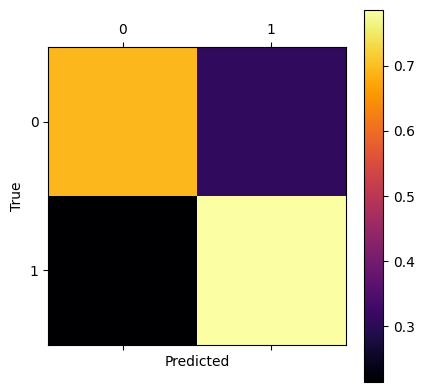

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6180555555555556
[[0.69230769 0.30769231]
 [0.53571429 0.46428571]]


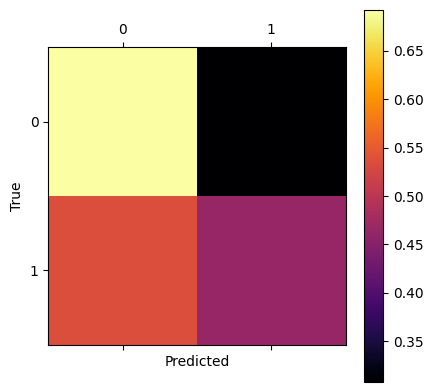

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6203703703703703
Accuracy on training set:	 0.5902777777777778
[[0.65384615 0.34615385]
 [0.5        0.5       ]]


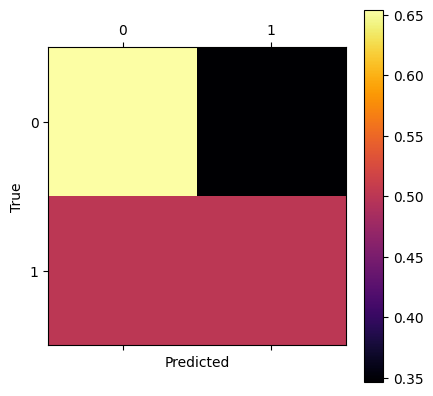

100%|██████████| 540/540 [01:24<00:00,  6.40it/s]


For feature space:  15  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5902777777777777
[[0.5        0.5       ]
 [0.46428571 0.53571429]]


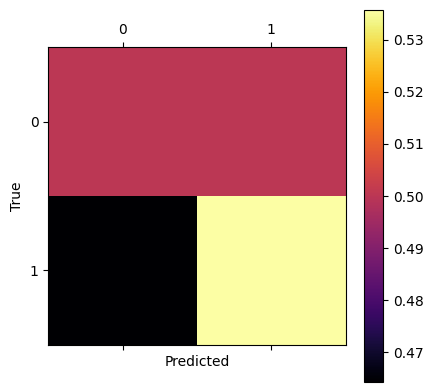

For feature space:  15  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.37962962962962965
Accuracy on training set:	 0.4236111111111111
[[0.73076923 0.26923077]
 [0.85714286 0.14285714]]


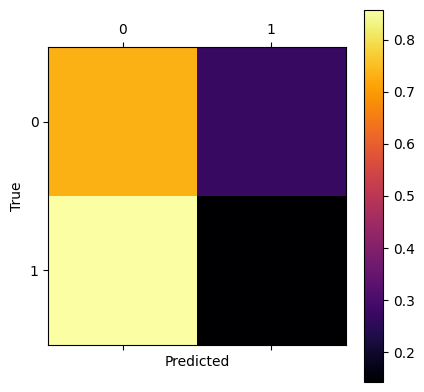

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.4837962962962963
[[0.15384615 0.84615385]
 [0.07142857 0.92857143]]


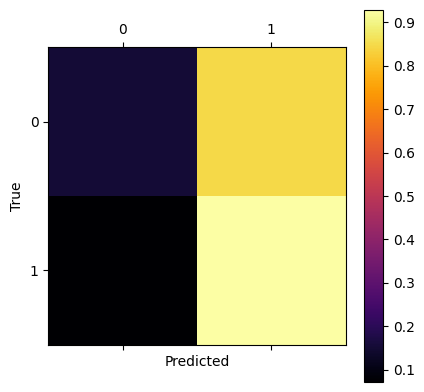

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.47222222222222215
[[0.19230769 0.80769231]
 [0.10714286 0.89285714]]


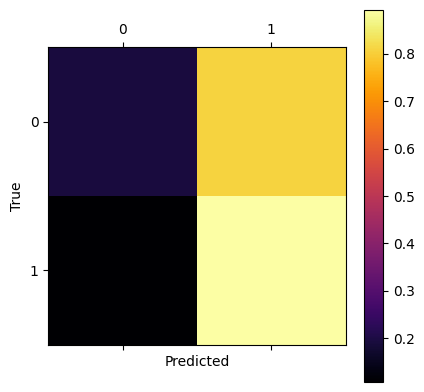

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.46990740740740744
[[0.26923077 0.73076923]
 [0.17857143 0.82142857]]


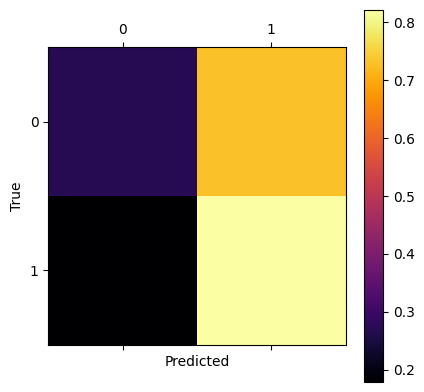

100%|██████████| 540/540 [01:24<00:00,  6.39it/s]


For feature space:  15  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5648148148148149
[[0.19230769 0.80769231]
 [0.25       0.75      ]]


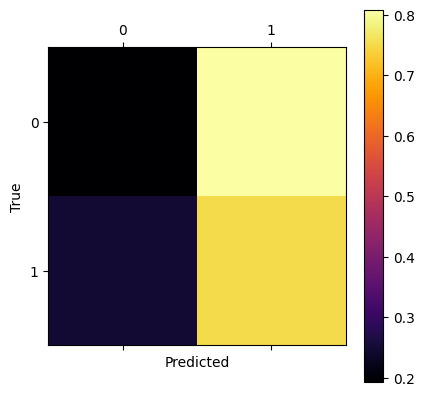

For feature space:  15  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.4259259259259259
[[0.92307692 0.07692308]
 [0.89285714 0.10714286]]


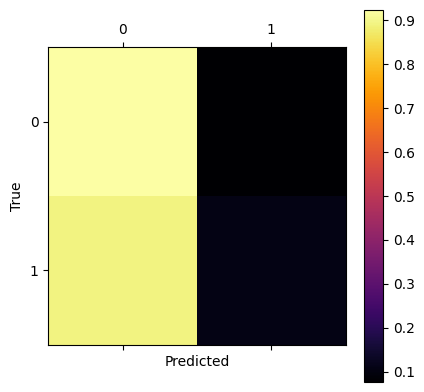

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.4282407407407407
[[0.96153846 0.03846154]
 [0.92857143 0.07142857]]


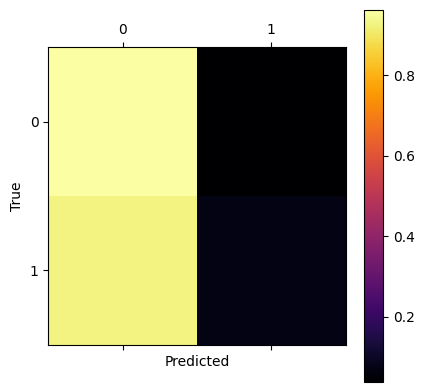

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.47453703703703703
[[0.42307692 0.57692308]
 [0.28571429 0.71428571]]


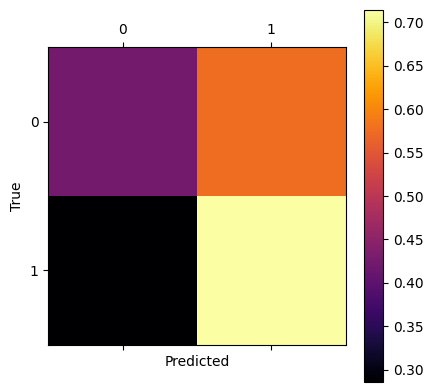

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.44675925925925924
[[0.5        0.5       ]
 [0.82142857 0.17857143]]


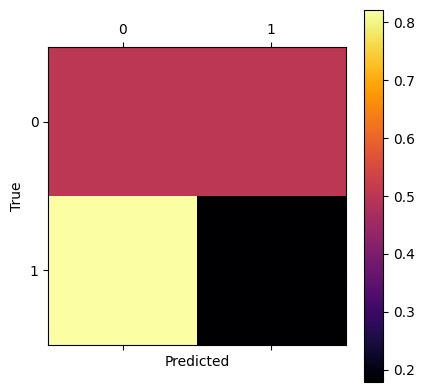

100%|██████████| 540/540 [01:18<00:00,  6.86it/s]


For feature space:  20  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.6203703703703703
[[0.61538462 0.38461538]
 [0.32142857 0.67857143]]


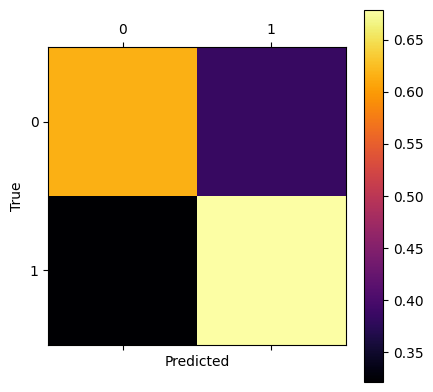

For feature space:  20  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.7407407407407407
Accuracy on training set:	 0.6805555555555557
[[0.73076923 0.26923077]
 [0.25       0.75      ]]


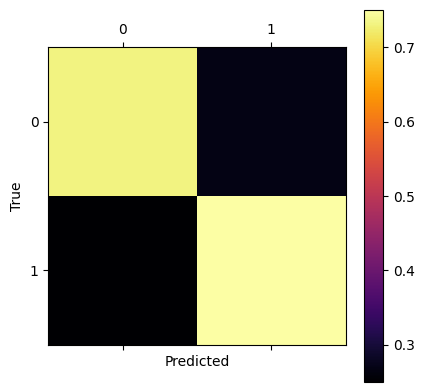

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.7407407407407407
Accuracy on training set:	 0.7152777777777778
[[0.69230769 0.30769231]
 [0.28571429 0.71428571]]


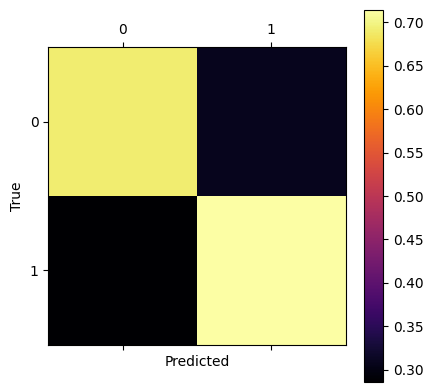

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.673611111111111
[[0.80769231 0.19230769]
 [0.42857143 0.57142857]]


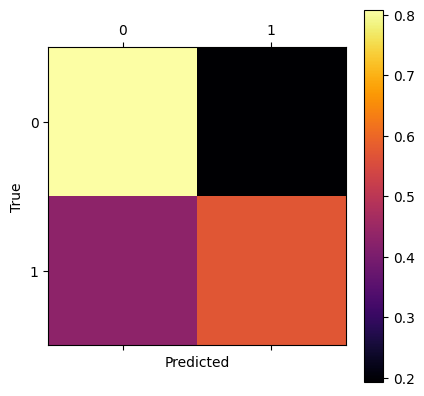

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6574074074074074
Accuracy on training set:	 0.662037037037037
[[0.76923077 0.23076923]
 [0.35714286 0.64285714]]


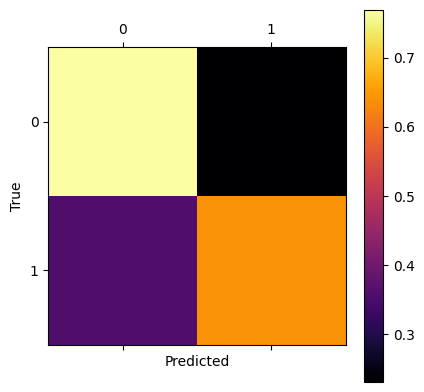

100%|██████████| 540/540 [01:18<00:00,  6.85it/s]


For feature space:  20  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.48148148148148145
Accuracy on training set:	 0.45601851851851855
[[0.73076923 0.26923077]
 [0.82142857 0.17857143]]


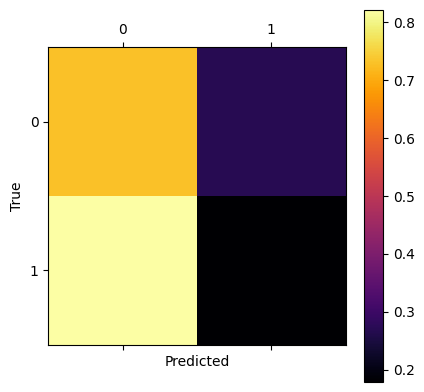

For feature space:  20  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.4236111111111111
[[0.19230769 0.80769231]
 [0.03571429 0.96428571]]


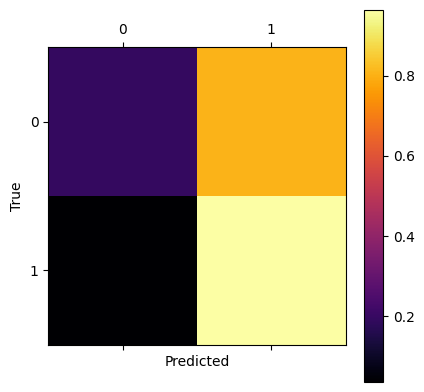

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.46064814814814814
[[0.19230769 0.80769231]
 [0.10714286 0.89285714]]


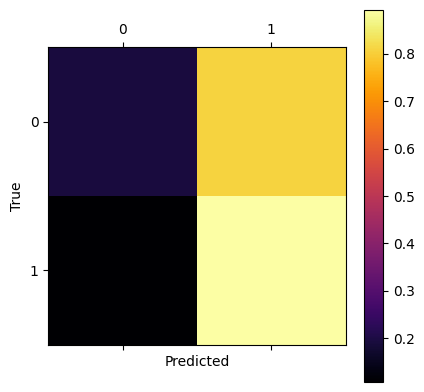

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.5601851851851852
[[0.11538462 0.88461538]
 [0.03571429 0.96428571]]


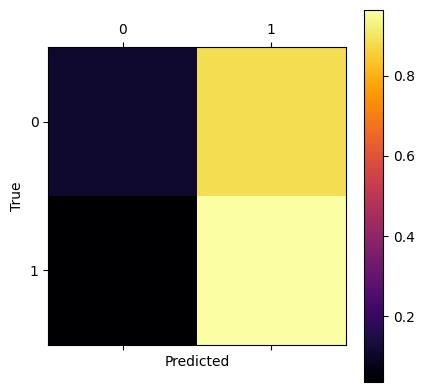

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.5439814814814815
[[0.11538462 0.88461538]
 [0.14285714 0.85714286]]


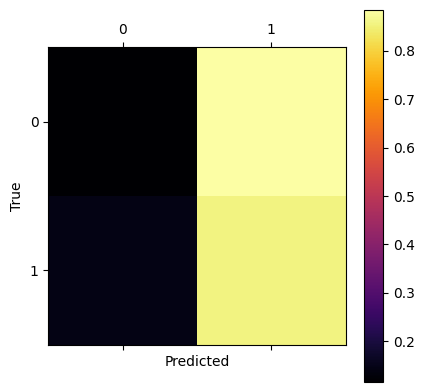

100%|██████████| 540/540 [01:18<00:00,  6.85it/s]


For feature space:  20  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.42592592592592593
Accuracy on training set:	 0.46990740740740744
[[0.30769231 0.69230769]
 [0.28571429 0.71428571]]


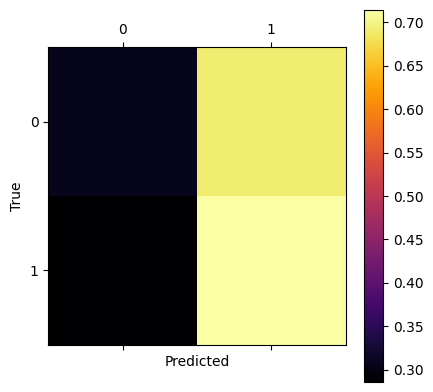

For feature space:  20  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.4305555555555555
[[0.96153846 0.03846154]
 [0.96428571 0.03571429]]


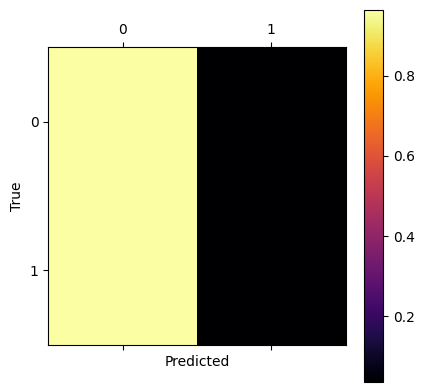

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.4490740740740741
[[0.76923077 0.23076923]
 [0.85714286 0.14285714]]


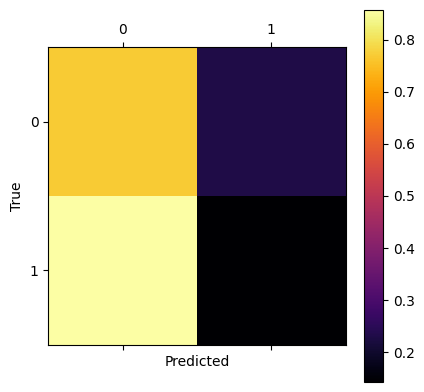

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.4328703703703704
[[0.96153846 0.03846154]
 [1.         0.        ]]


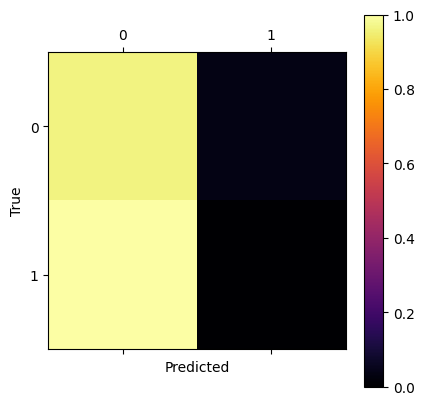

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.4537037037037037
[[0.11538462 0.88461538]
 [0.03571429 0.96428571]]


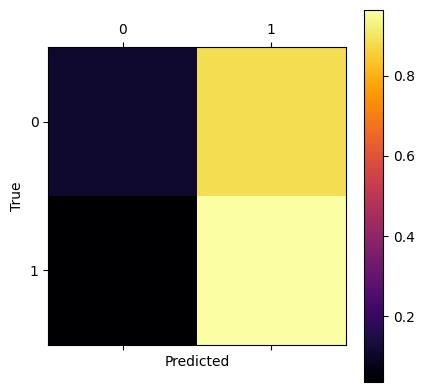

100%|██████████| 540/540 [01:17<00:00,  6.99it/s]


For feature space:  30  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.6041666666666666
[[0.57692308 0.42307692]
 [0.32142857 0.67857143]]


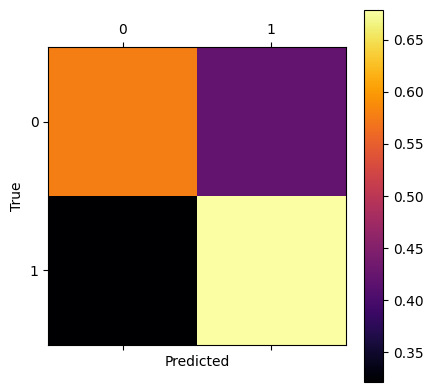

For feature space:  30  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.6481481481481483
[[0.61538462 0.38461538]
 [0.25       0.75      ]]


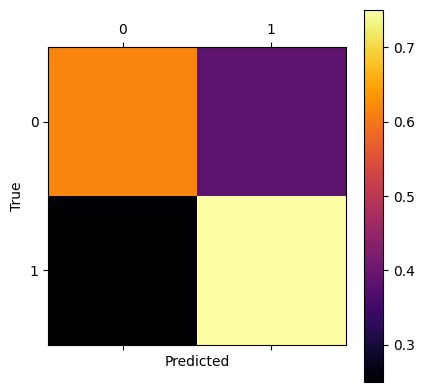

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6412037037037037
[[0.53846154 0.46153846]
 [0.14285714 0.85714286]]


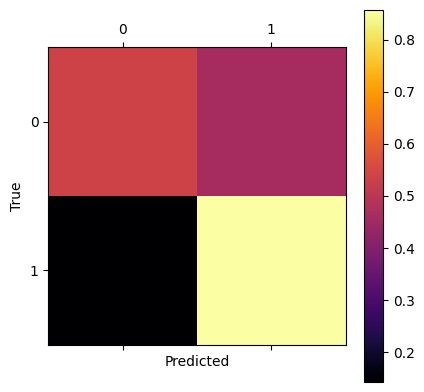

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.673611111111111
[[0.73076923 0.26923077]
 [0.28571429 0.71428571]]


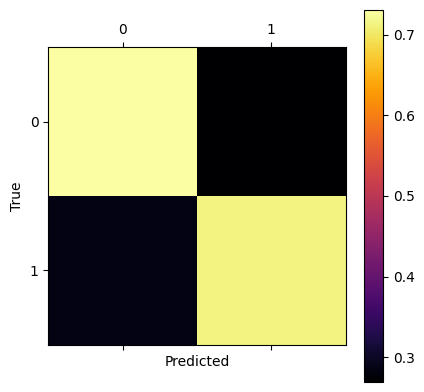

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.7037037037037037
[[0.73076923 0.26923077]
 [0.21428571 0.78571429]]


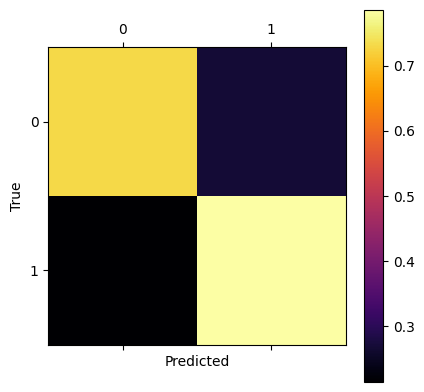

100%|██████████| 540/540 [01:16<00:00,  7.06it/s]


For feature space:  30  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.4444444444444444
Accuracy on training set:	 0.48148148148148145
[[0.19230769 0.80769231]
 [0.17857143 0.82142857]]


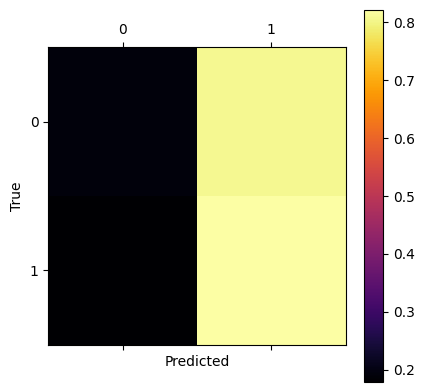

For feature space:  30  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5601851851851852
[[0.65384615 0.34615385]
 [0.75       0.25      ]]


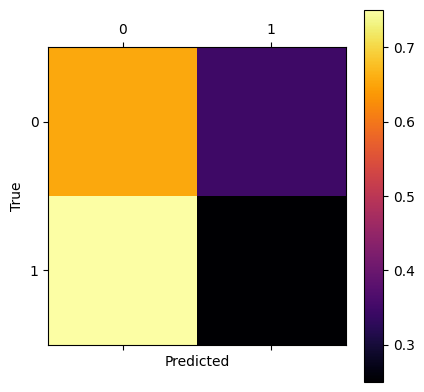

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.4328703703703704
[[0.73076923 0.26923077]
 [0.96428571 0.03571429]]


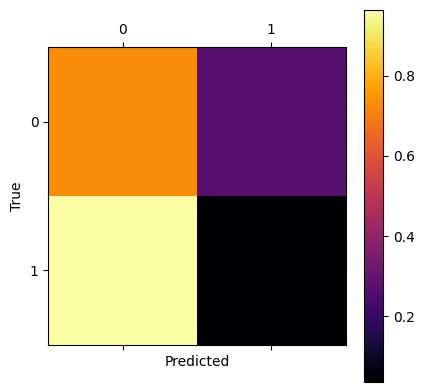

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.5671296296296297
[[0.61538462 0.38461538]
 [0.5        0.5       ]]


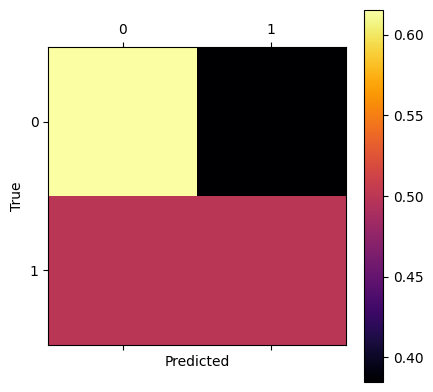

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.5717592592592592
[[0.23076923 0.76923077]
 [0.17857143 0.82142857]]


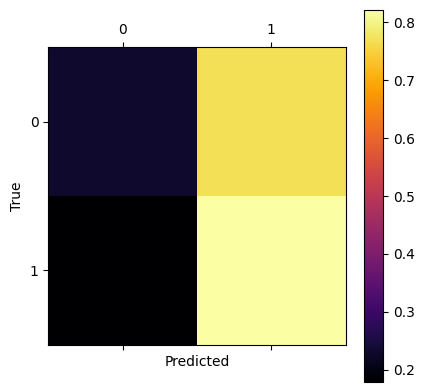

100%|██████████| 540/540 [01:17<00:00,  6.99it/s]


For feature space:  30  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.44675925925925924
[[0.07692308 0.92307692]
 [0.03571429 0.96428571]]


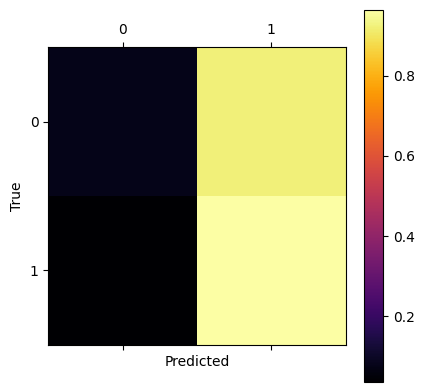

For feature space:  30  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.5393518518518519
[[0.23076923 0.76923077]
 [0.25       0.75      ]]


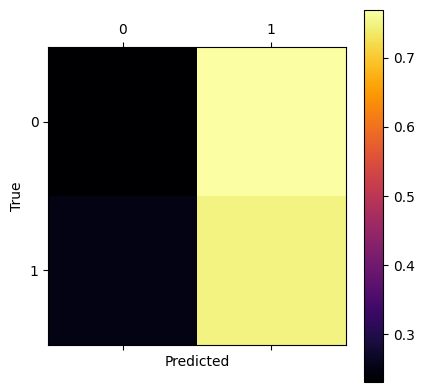

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.4375
[[0.88461538 0.11538462]
 [1.         0.        ]]


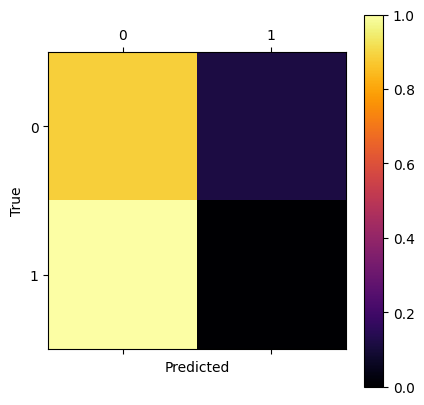

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.44675925925925924
[[0.         1.        ]
 [0.07142857 0.92857143]]


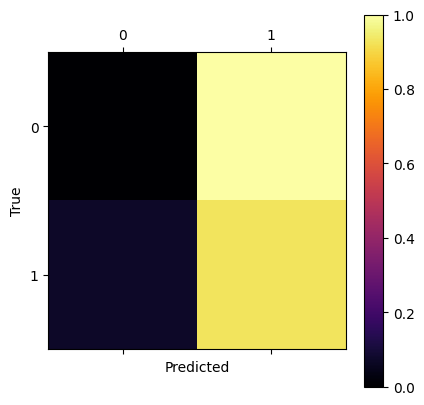

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.4444444444444445
[[0.         1.        ]
 [0.03571429 0.96428571]]


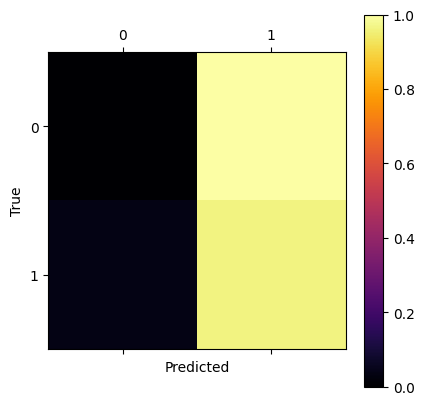

100%|██████████| 540/540 [01:17<00:00,  7.00it/s]


For feature space:  50  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.6064814814814815
[[0.57692308 0.42307692]
 [0.35714286 0.64285714]]


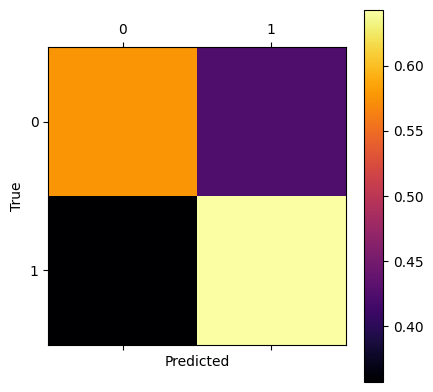

For feature space:  50  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.6273148148148148
[[0.73076923 0.26923077]
 [0.32142857 0.67857143]]


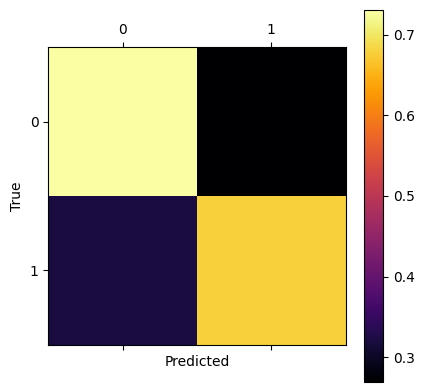

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.6967592592592592
[[0.61538462 0.38461538]
 [0.35714286 0.64285714]]


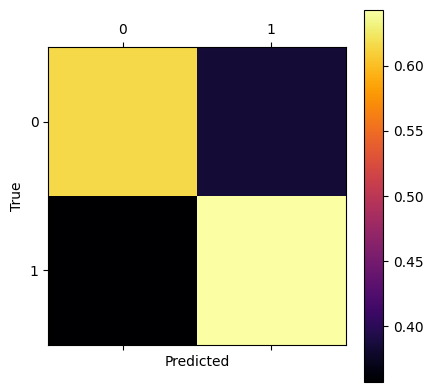

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.4976851851851852
[[0.30769231 0.69230769]
 [0.03571429 0.96428571]]


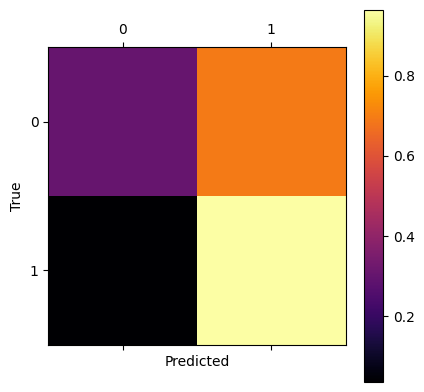

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.47685185185185186
[[0.80769231 0.19230769]
 [0.53571429 0.46428571]]


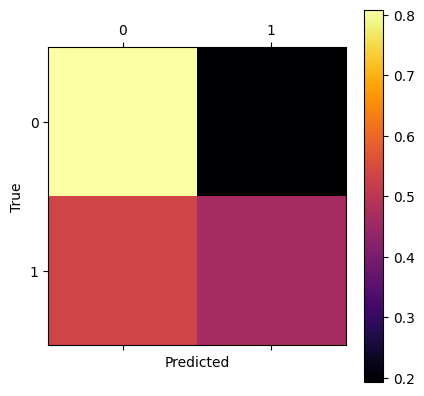

100%|██████████| 540/540 [01:15<00:00,  7.12it/s]


For feature space:  50  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.4583333333333333
[[0.53846154 0.46153846]
 [0.71428571 0.28571429]]


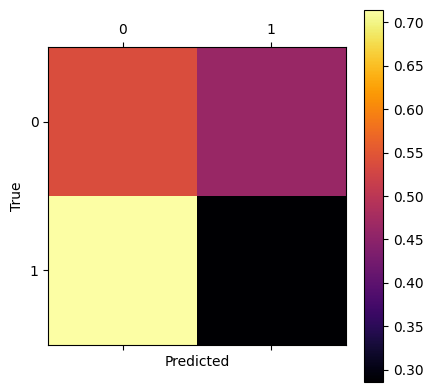

For feature space:  50  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.37037037037037035
Accuracy on training set:	 0.4467592592592593
[[0.46153846 0.53846154]
 [0.46428571 0.53571429]]


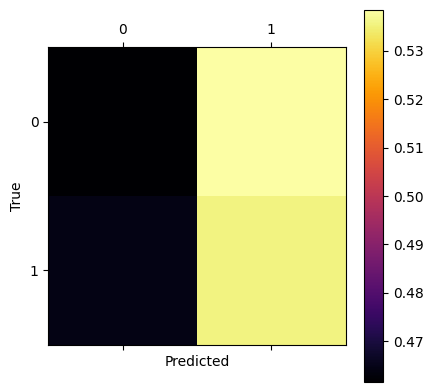

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5925925925925926
[[0.42307692 0.57692308]
 [0.14285714 0.85714286]]


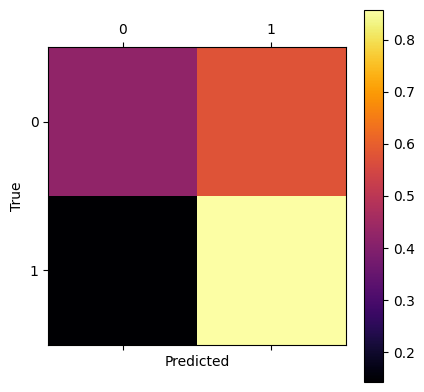

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.46527777777777785
[[0.73076923 0.26923077]
 [0.71428571 0.28571429]]


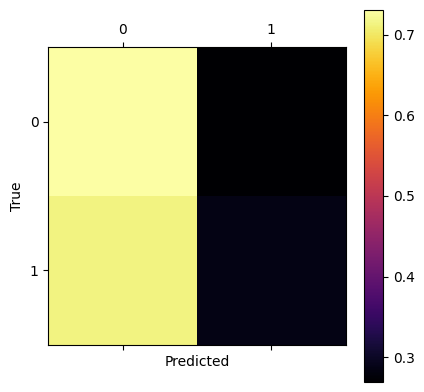

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.4375
[[0.84615385 0.15384615]
 [0.78571429 0.21428571]]


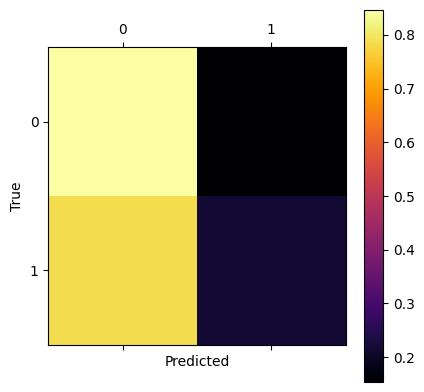

100%|██████████| 540/540 [01:15<00:00,  7.16it/s]


For feature space:  50  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.4537037037037037
[[0.80769231 0.19230769]
 [0.82142857 0.17857143]]


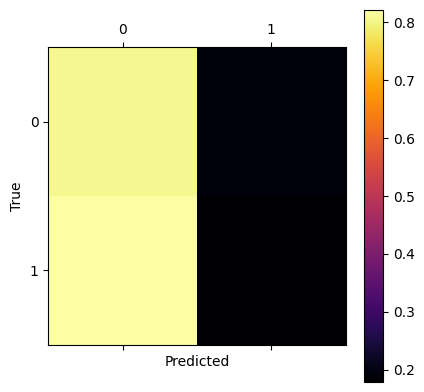

For feature space:  50  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.46296296296296297
Accuracy on training set:	 0.449074074074074
[[0.38461538 0.61538462]
 [0.21428571 0.78571429]]


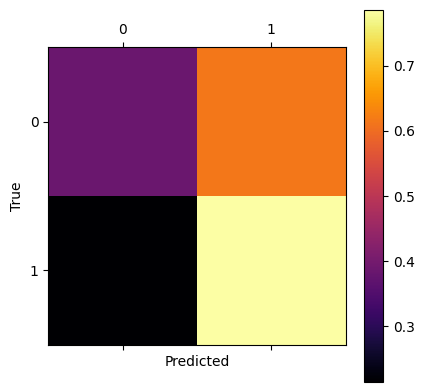

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.45601851851851855
[[0.07692308 0.92307692]
 [0.10714286 0.89285714]]


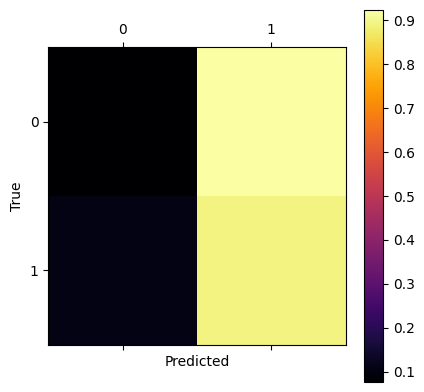

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.4537037037037037
[[0.88461538 0.11538462]
 [0.89285714 0.10714286]]


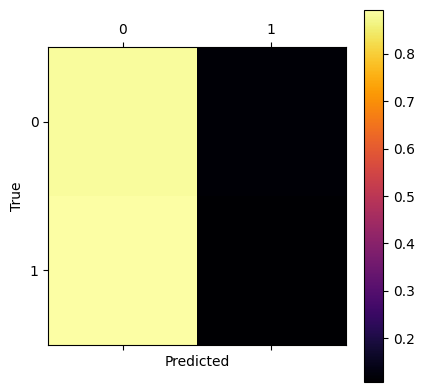

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.4305555555555555
[[0.92307692 0.07692308]
 [0.92857143 0.07142857]]


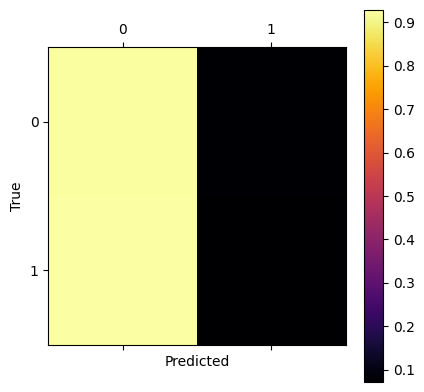

In [89]:
features = [15,20,30,50]
cutoff = [40e6, 80e6, 120e6]
structure = [(30,), (40,), (20,10), (10,10,10), (10,10,5,5) ]
acc = np.zeros((len(features), len(cutoff), len(structure)))
for i, f in enumerate(features):
    for j, c in enumerate(cutoff):
        lassi = speechClassifierBinary("./waveforms_r2p3_fast/", feature_space=f, cutoff=c, ch=0)
        for k, s in enumerate(structure):
            print("For feature space: ", f, " and cutoff: ", c, " and structure: ", s)
            acc[i,j, k], _ = lassi.clf(layers=s)
            lassi.confmat(struct=s)

In [90]:
# Find the 5 highest accuracies
acc_temp = acc.copy()
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])

(0, 0, 2) 0.7777777777777778 15 40000000.0 (20, 10)
(1, 0, 1) 0.7407407407407407 20 40000000.0 (40,)
(1, 0, 2) 0.7407407407407407 20 40000000.0 (20, 10)
(2, 0, 4) 0.6851851851851852 30 40000000.0 (10, 10, 5, 5)
(2, 0, 3) 0.6666666666666666 30 40000000.0 (10, 10, 10)


100%|██████████| 540/540 [01:49<00:00,  4.94it/s]


For feature space:  15  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.6574074074074074
[[0.65384615 0.34615385]
 [0.25       0.75      ]]


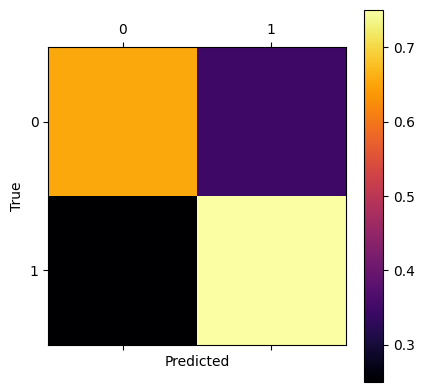

For feature space:  15  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.664351851851852
[[0.57692308 0.42307692]
 [0.28571429 0.71428571]]


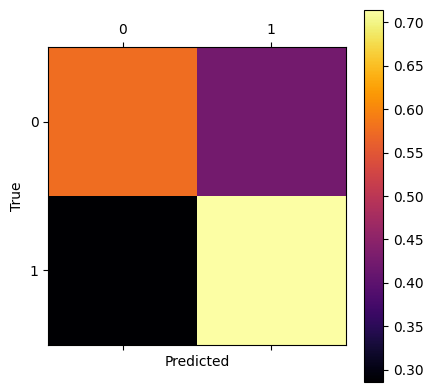

For feature space:  15  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.6712962962962963
[[0.73076923 0.26923077]
 [0.28571429 0.71428571]]


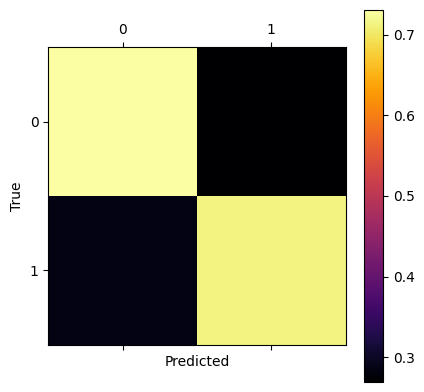

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6388888888888888
[[0.84615385 0.15384615]
 [0.21428571 0.78571429]]


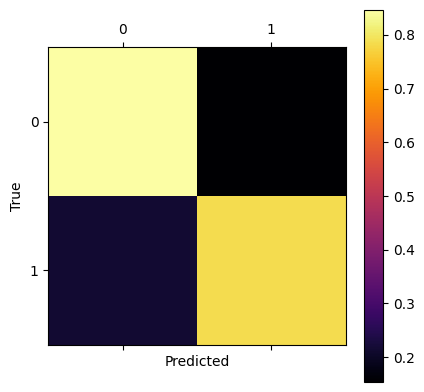

For feature space:  15  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6851851851851852
Accuracy on training set:	 0.6527777777777778
[[0.76923077 0.23076923]
 [0.17857143 0.82142857]]


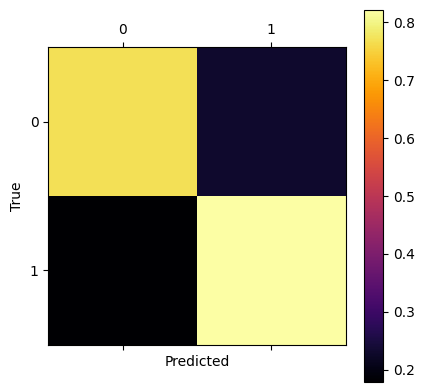

100%|██████████| 540/540 [01:24<00:00,  6.37it/s]


For feature space:  15  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.5625
[[0.5        0.5       ]
 [0.39285714 0.60714286]]


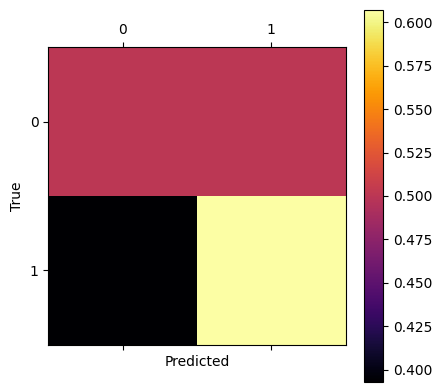

For feature space:  15  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.47685185185185186
[[0.5 0.5]
 [0.5 0.5]]


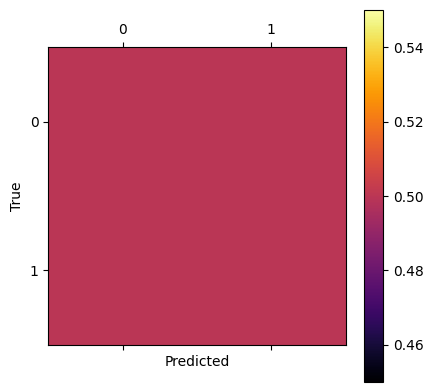

For feature space:  15  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5833333333333334
[[0.53846154 0.46153846]
 [0.5        0.5       ]]


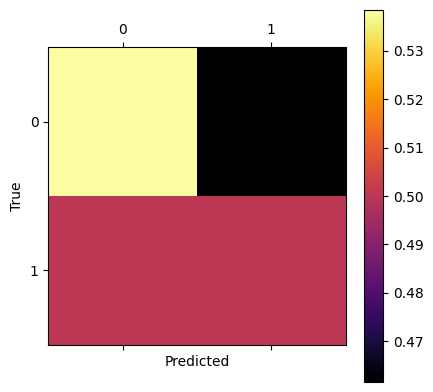

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.4074074074074074
Accuracy on training set:	 0.5532407407407408
[[0.61538462 0.38461538]
 [0.46428571 0.53571429]]


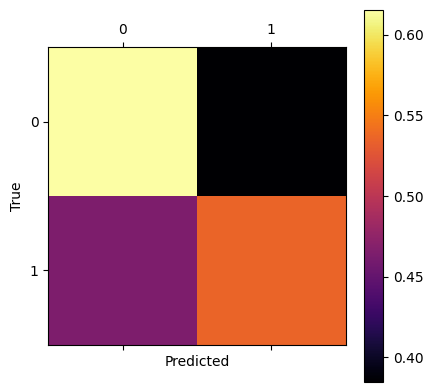

For feature space:  15  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.42592592592592593
Accuracy on training set:	 0.5532407407407408
[[0.5        0.5       ]
 [0.42857143 0.57142857]]


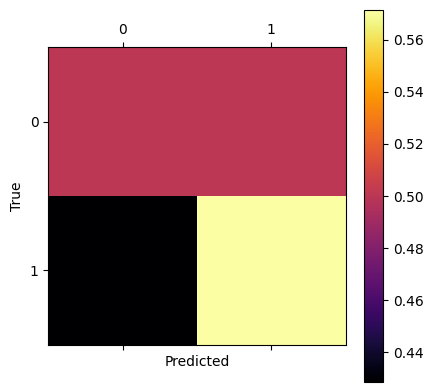

100%|██████████| 540/540 [01:24<00:00,  6.37it/s]


For feature space:  15  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.48611111111111116
[[0.61538462 0.38461538]
 [0.67857143 0.32142857]]


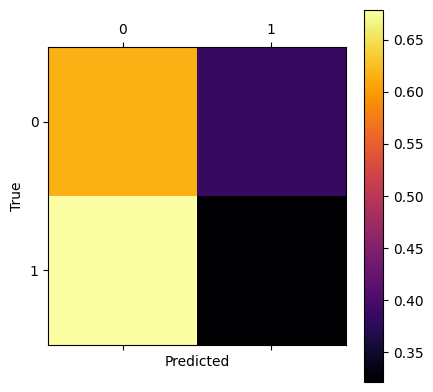

For feature space:  15  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.4467592592592593
[[0.84615385 0.15384615]
 [0.82142857 0.17857143]]


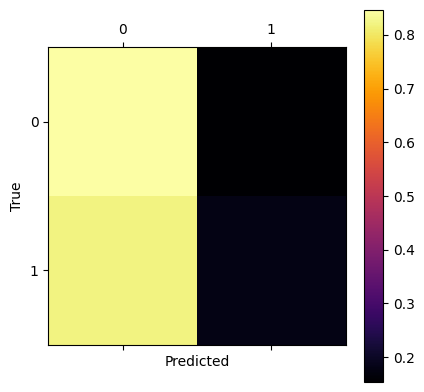

For feature space:  15  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.4490740740740741
[[0.80769231 0.19230769]
 [0.82142857 0.17857143]]


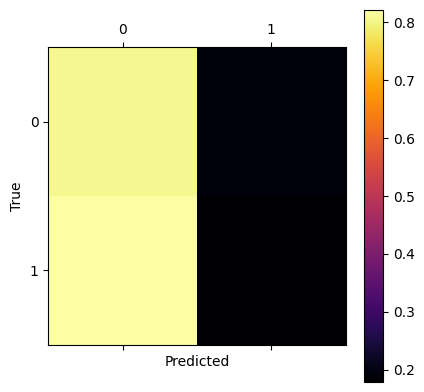

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.4513888888888889
[[0.76923077 0.23076923]
 [0.78571429 0.21428571]]


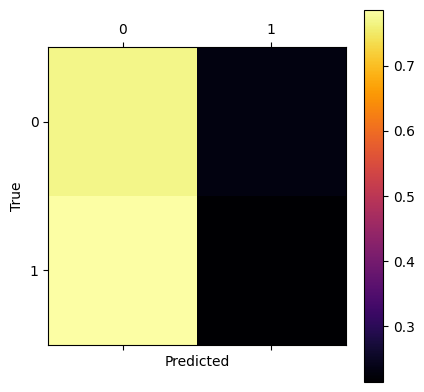

For feature space:  15  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.46990740740740744
[[0.34615385 0.65384615]
 [0.25       0.75      ]]


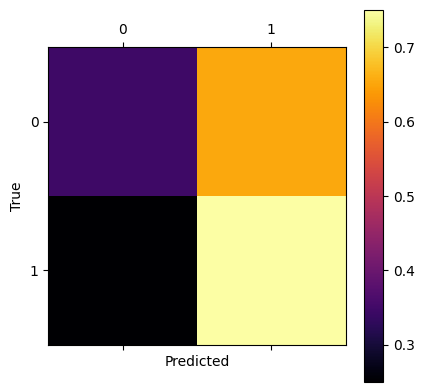

100%|██████████| 540/540 [01:20<00:00,  6.73it/s]


For feature space:  20  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6666666666666666
[[0.76923077 0.23076923]
 [0.39285714 0.60714286]]


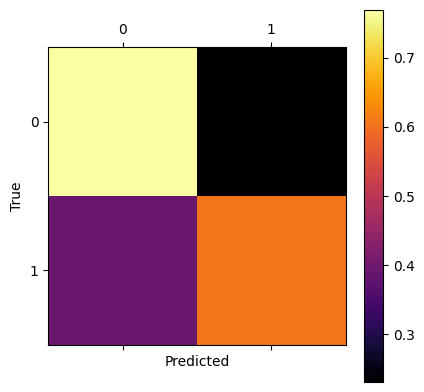

For feature space:  20  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.6296296296296297
[[0.76923077 0.23076923]
 [0.32142857 0.67857143]]


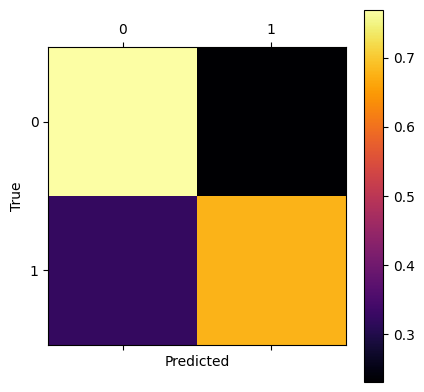

For feature space:  20  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.5833333333333334
[[0.80769231 0.19230769]
 [0.39285714 0.60714286]]


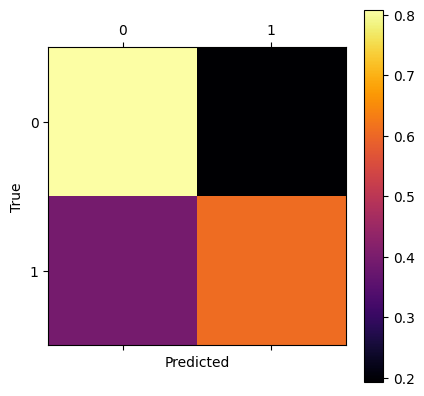

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.6875
[[0.80769231 0.19230769]
 [0.32142857 0.67857143]]


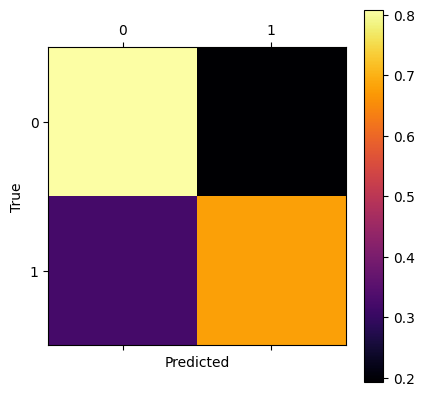

For feature space:  20  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.6828703703703703
[[0.80769231 0.19230769]
 [0.32142857 0.67857143]]


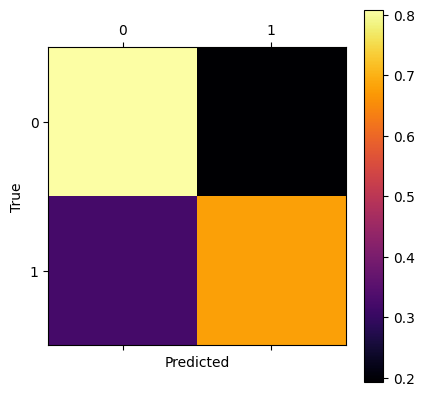

100%|██████████| 540/540 [01:21<00:00,  6.62it/s]


For feature space:  20  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.5138888888888888
[[0.38461538 0.61538462]
 [0.39285714 0.60714286]]


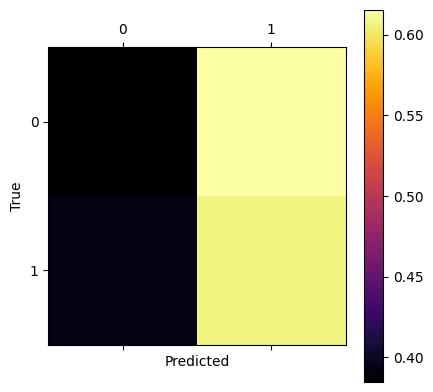

For feature space:  20  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5833333333333334
Accuracy on training set:	 0.48611111111111116
[[0.73076923 0.26923077]
 [0.46428571 0.53571429]]


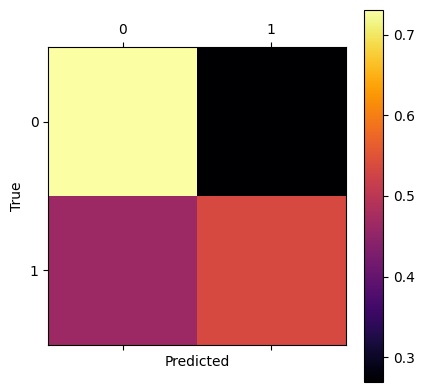

For feature space:  20  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5740740740740741
Accuracy on training set:	 0.5138888888888888
[[0.61538462 0.38461538]
 [0.60714286 0.39285714]]


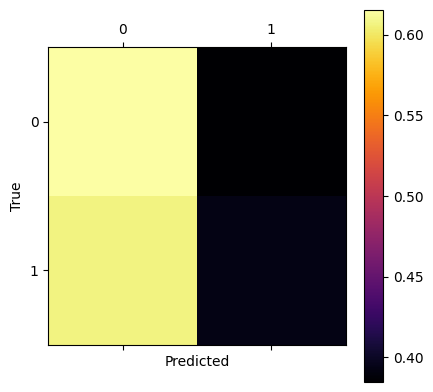

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.5555555555555556
[[0.57692308 0.42307692]
 [0.57142857 0.42857143]]


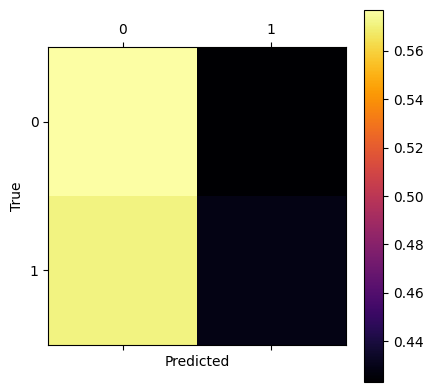

For feature space:  20  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.5717592592592592
[[0.65384615 0.34615385]
 [0.53571429 0.46428571]]


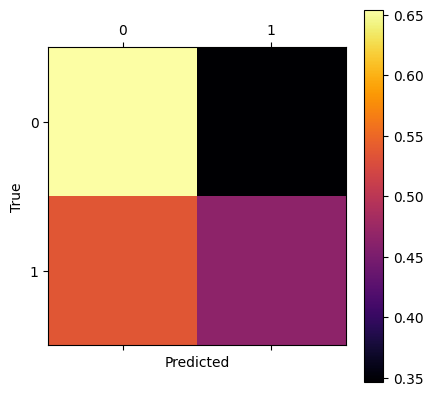

100%|██████████| 540/540 [01:20<00:00,  6.74it/s]


For feature space:  20  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.49074074074074076
Accuracy on training set:	 0.5
[[0.19230769 0.80769231]
 [0.28571429 0.71428571]]


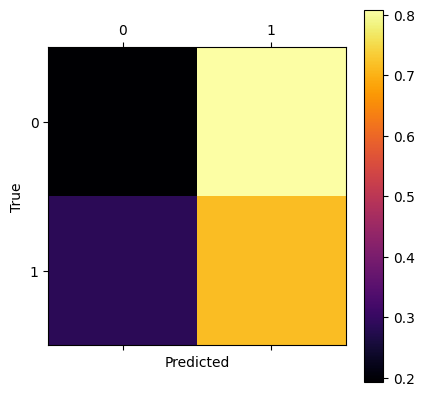

For feature space:  20  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.49074074074074076
Accuracy on training set:	 0.4444444444444444
[[0.80769231 0.19230769]
 [0.60714286 0.39285714]]


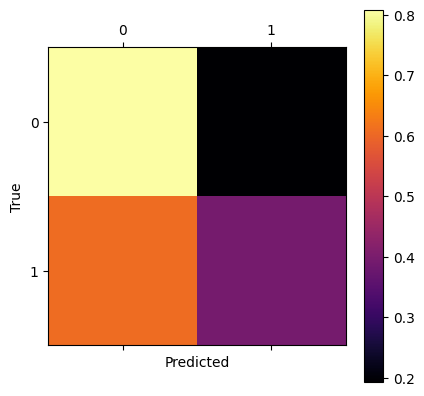

For feature space:  20  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.46296296296296297
Accuracy on training set:	 0.4699074074074074
[[0.53846154 0.46153846]
 [0.53571429 0.46428571]]


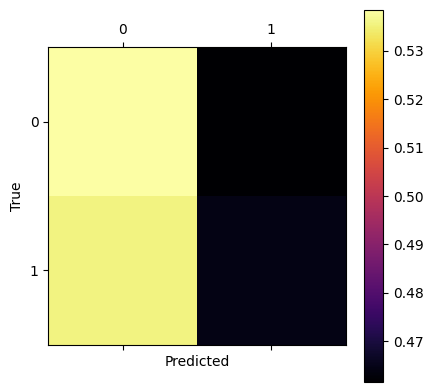

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.4421296296296296
[[0.46153846 0.53846154]
 [0.42857143 0.57142857]]


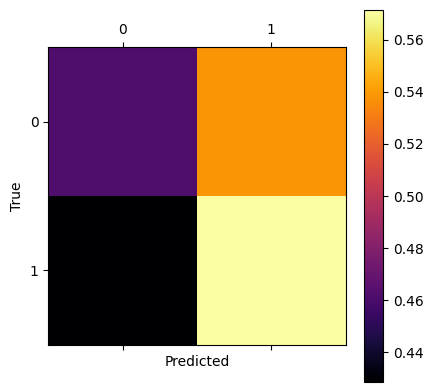

For feature space:  20  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.46296296296296297
[[0.5        0.5       ]
 [0.57142857 0.42857143]]


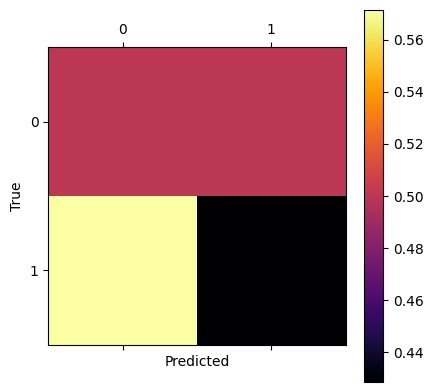

100%|██████████| 540/540 [01:18<00:00,  6.89it/s]


For feature space:  30  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.6388888888888888
Accuracy on training set:	 0.6064814814814815
[[0.69230769 0.30769231]
 [0.35714286 0.64285714]]


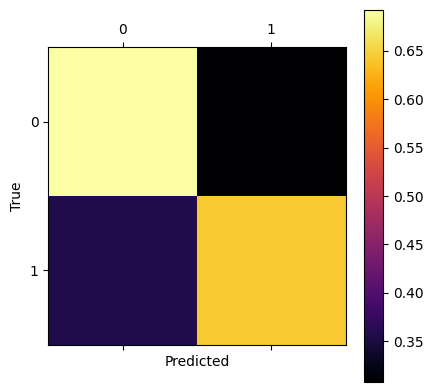

For feature space:  30  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5925925925925926
Accuracy on training set:	 0.625
[[0.80769231 0.19230769]
 [0.42857143 0.57142857]]


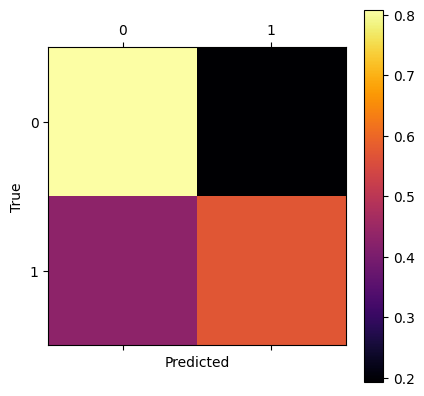

For feature space:  30  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6759259259259259
Accuracy on training set:	 0.6481481481481483
[[0.73076923 0.26923077]
 [0.39285714 0.60714286]]


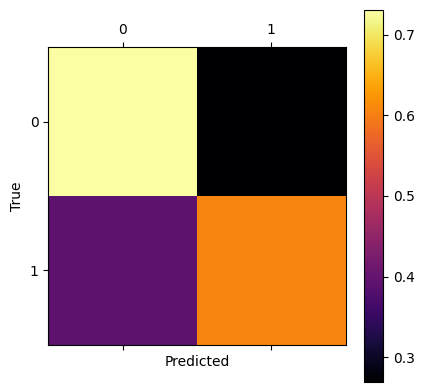

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.5717592592592593
[[0.42307692 0.57692308]
 [0.28571429 0.71428571]]


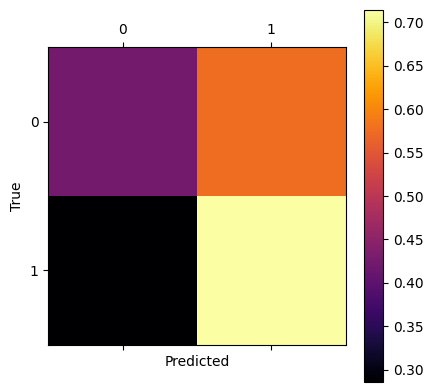

For feature space:  30  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6111111111111112
Accuracy on training set:	 0.6018518518518519
[[0.53846154 0.46153846]
 [0.17857143 0.82142857]]


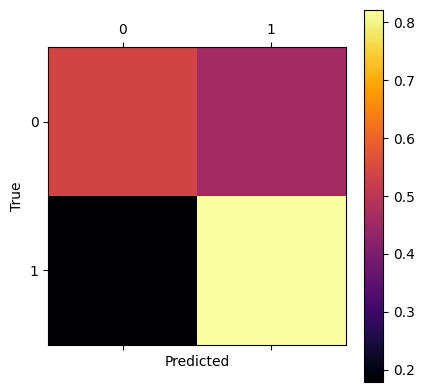

100%|██████████| 540/540 [01:17<00:00,  6.96it/s]


For feature space:  30  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.49074074074074076
Accuracy on training set:	 0.5277777777777778
[[0.5        0.5       ]
 [0.39285714 0.60714286]]


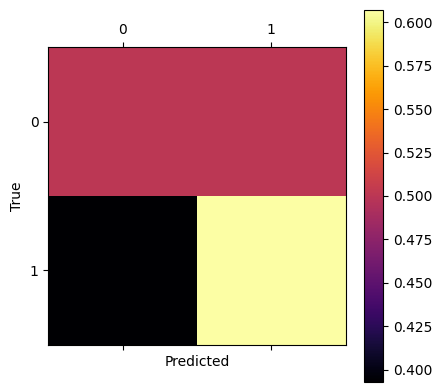

For feature space:  30  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.5555555555555556
Accuracy on training set:	 0.5138888888888888
[[0.61538462 0.38461538]
 [0.5        0.5       ]]


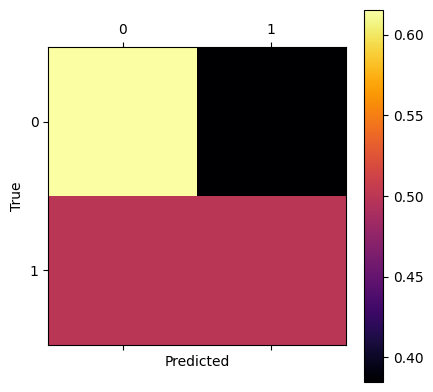

For feature space:  30  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.47453703703703703
[[0.61538462 0.38461538]
 [0.46428571 0.53571429]]


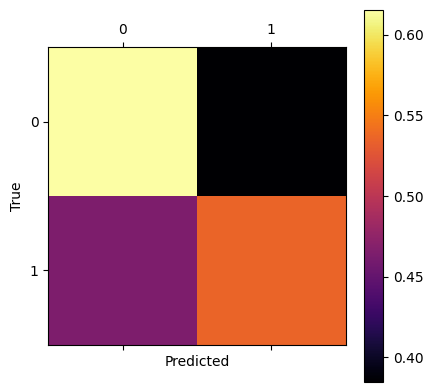

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.5254629629629629
[[0.26923077 0.73076923]
 [0.39285714 0.60714286]]


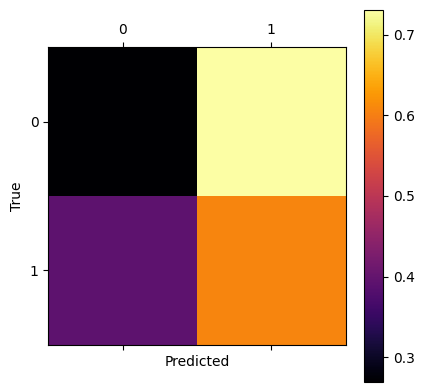

For feature space:  30  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5648148148148148
Accuracy on training set:	 0.513888888888889
[[0.38461538 0.61538462]
 [0.32142857 0.67857143]]


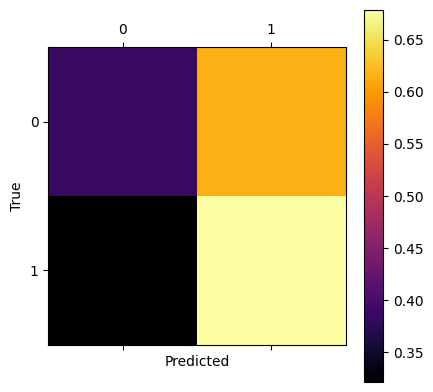

100%|██████████| 540/540 [01:17<00:00,  6.96it/s]


For feature space:  30  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.47453703703703703
[[0.42307692 0.57692308]
 [0.46428571 0.53571429]]


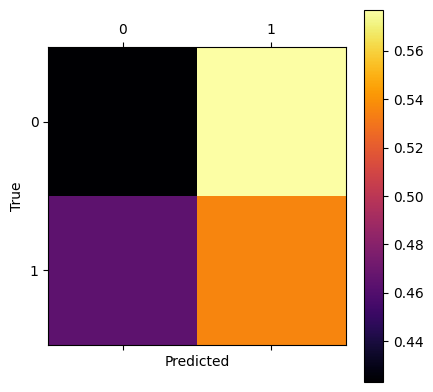

For feature space:  30  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.5023148148148148
[[0.61538462 0.38461538]
 [0.39285714 0.60714286]]


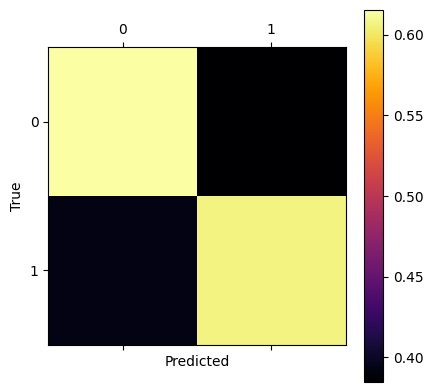

For feature space:  30  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.4259259259259259
[[0.61538462 0.38461538]
 [0.71428571 0.28571429]]


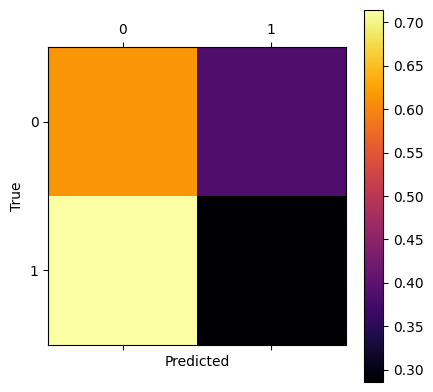

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5277777777777778
Accuracy on training set:	 0.46759259259259256
[[0.26923077 0.73076923]
 [0.35714286 0.64285714]]


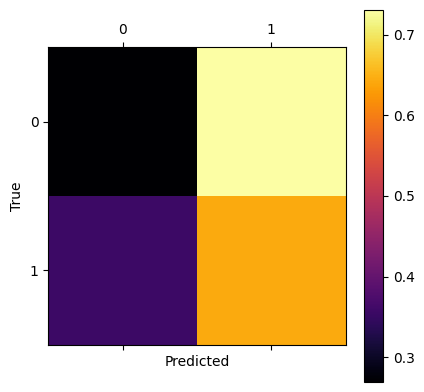

For feature space:  30  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.46527777777777785
[[0.69230769 0.30769231]
 [0.75       0.25      ]]


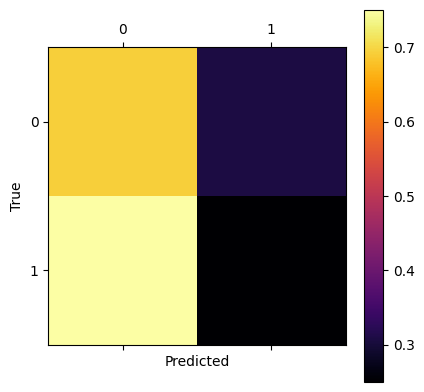

100%|██████████| 540/540 [01:19<00:00,  6.82it/s]


For feature space:  50  and cutoff:  40000000.0  and structure:  (30,)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.6273148148148148
[[0.57692308 0.42307692]
 [0.42857143 0.57142857]]


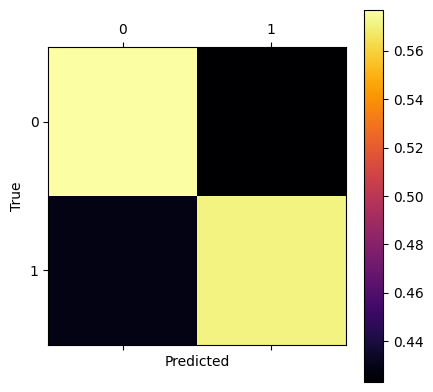

For feature space:  50  and cutoff:  40000000.0  and structure:  (40,)
Accuracy on test set:		 0.5
Accuracy on training set:	 0.6342592592592592
[[0.65384615 0.34615385]
 [0.21428571 0.78571429]]


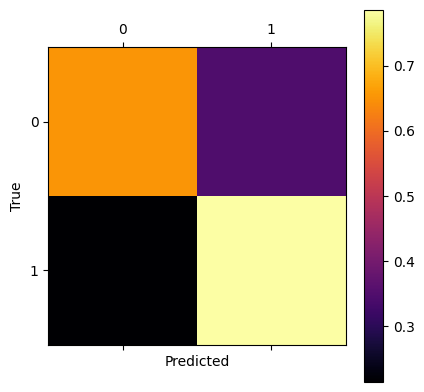

For feature space:  50  and cutoff:  40000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.6666666666666666
Accuracy on training set:	 0.6157407407407406
[[0.69230769 0.30769231]
 [0.39285714 0.60714286]]


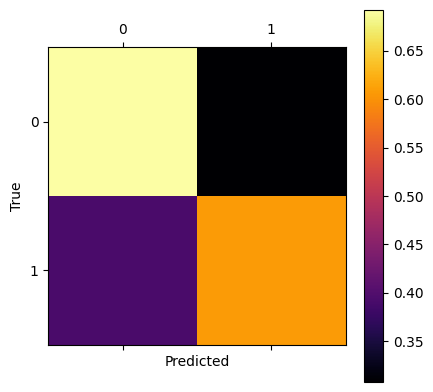

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.6296296296296297
Accuracy on training set:	 0.47453703703703703
[[0.92307692 0.07692308]
 [0.57142857 0.42857143]]


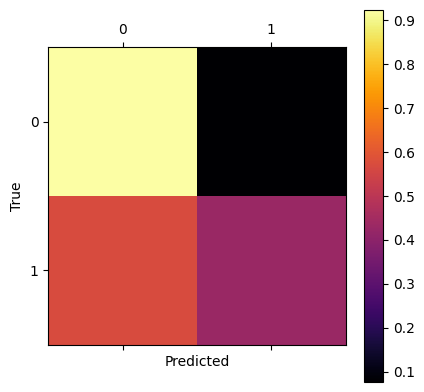

For feature space:  50  and cutoff:  40000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.6018518518518519
Accuracy on training set:	 0.4884259259259259
[[0.80769231 0.19230769]
 [0.57142857 0.42857143]]


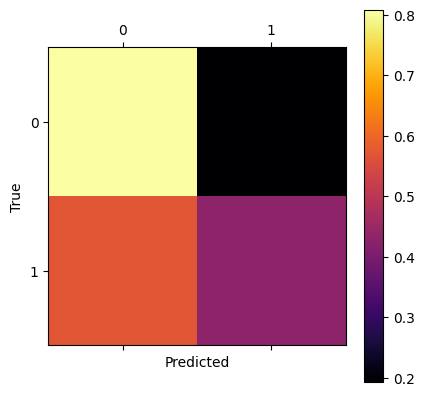

100%|██████████| 540/540 [01:16<00:00,  7.02it/s]


For feature space:  50  and cutoff:  80000000.0  and structure:  (30,)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.525462962962963
[[0.38461538 0.61538462]
 [0.25       0.75      ]]


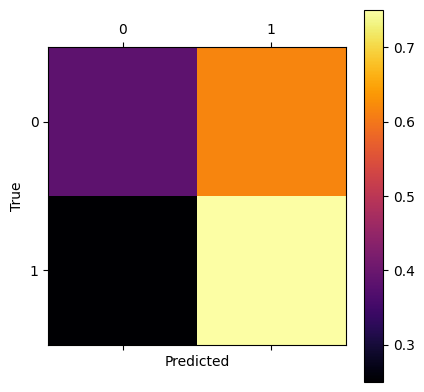

For feature space:  50  and cutoff:  80000000.0  and structure:  (40,)
Accuracy on test set:		 0.49074074074074076
Accuracy on training set:	 0.4976851851851851
[[0.65384615 0.34615385]
 [0.17857143 0.82142857]]


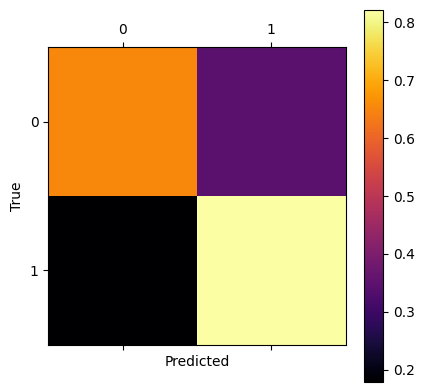

For feature space:  50  and cutoff:  80000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5439814814814815
[[0.30769231 0.69230769]
 [0.25       0.75      ]]


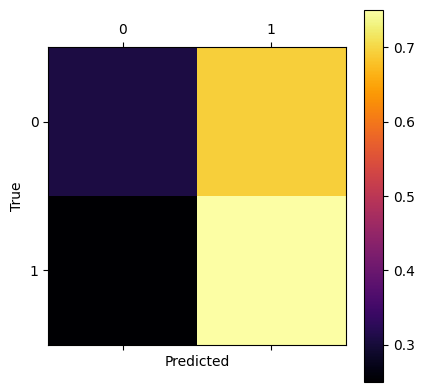

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.4791666666666667
[[0.73076923 0.26923077]
 [0.53571429 0.46428571]]


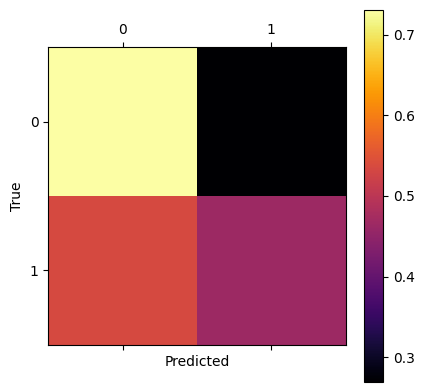

For feature space:  50  and cutoff:  80000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.4722222222222222
Accuracy on training set:	 0.4953703703703704
[[0.76923077 0.23076923]
 [0.67857143 0.32142857]]


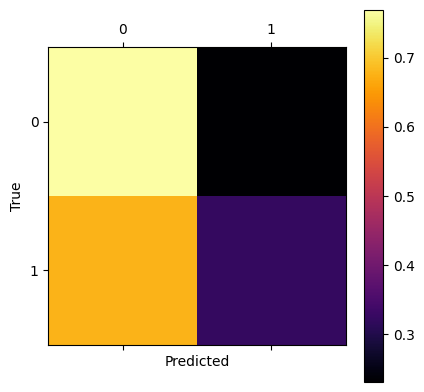

100%|██████████| 540/540 [01:17<00:00,  6.93it/s]


For feature space:  50  and cutoff:  120000000.0  and structure:  (30,)
Accuracy on test set:		 0.4537037037037037
Accuracy on training set:	 0.4837962962962963
[[0.42307692 0.57692308]
 [0.46428571 0.53571429]]


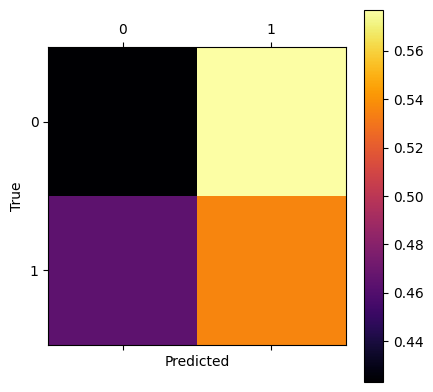

For feature space:  50  and cutoff:  120000000.0  and structure:  (40,)
Accuracy on test set:		 0.5185185185185185
Accuracy on training set:	 0.4953703703703704
[[0.5        0.5       ]
 [0.32142857 0.67857143]]


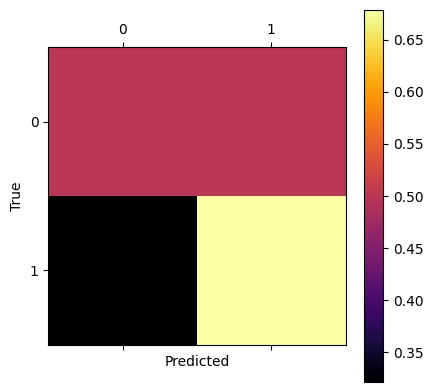

For feature space:  50  and cutoff:  120000000.0  and structure:  (20, 10)
Accuracy on test set:		 0.46296296296296297
Accuracy on training set:	 0.46527777777777785
[[0.57692308 0.42307692]
 [0.64285714 0.35714286]]


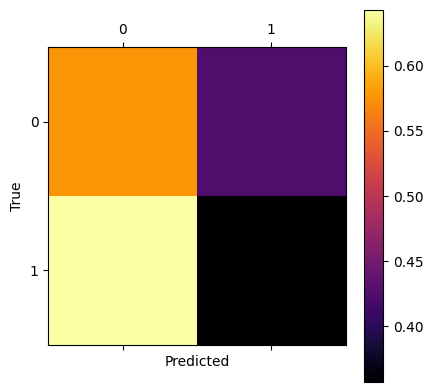

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 10)
Accuracy on test set:		 0.5370370370370371
Accuracy on training set:	 0.5162037037037037
[[0.65384615 0.34615385]
 [0.64285714 0.35714286]]


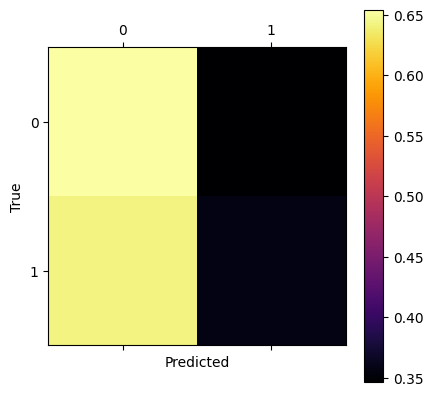

For feature space:  50  and cutoff:  120000000.0  and structure:  (10, 10, 5, 5)
Accuracy on test set:		 0.5092592592592593
Accuracy on training set:	 0.46527777777777773
[[0.69230769 0.30769231]
 [0.67857143 0.32142857]]


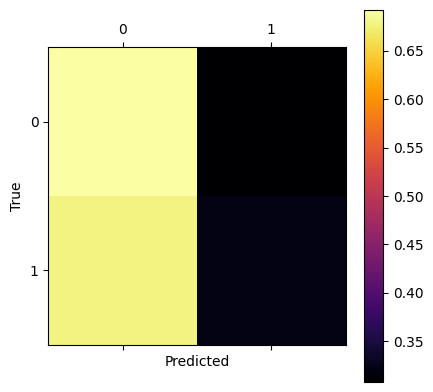

In [91]:
features = [15,20,30,50]
cutoff = [40e6, 80e6, 120e6]
structure = [(30,), (40,), (20,10), (10,10,10), (10,10,5,5) ]
acc = np.zeros((len(features), len(cutoff), len(structure)))
for i, f in enumerate(features):
    for j, c in enumerate(cutoff):
        lassi = speechClassifierBinary("./waveforms_r1p9_fast/", feature_space=f, cutoff=c, ch=0)
        for k, s in enumerate(structure):
            print("For feature space: ", f, " and cutoff: ", c, " and structure: ", s)
            acc[i,j, k], _ = lassi.clf(layers=s)
            lassi.confmat(struct=s)

In [92]:
# Find the 5 highest accuracies
acc_temp = acc.copy()
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])
acc_temp[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)] = 0
print(np.unravel_index(np.argmax(acc_temp), acc_temp.shape), np.max(acc_temp), features[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[0]], cutoff[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[1]], structure[np.unravel_index(np.argmax(acc_temp), acc_temp.shape)[2]])

(0, 0, 0) 0.6851851851851852 15 40000000.0 (30,)
(0, 0, 4) 0.6851851851851852 15 40000000.0 (10, 10, 5, 5)
(0, 0, 3) 0.6759259259259259 15 40000000.0 (10, 10, 10)
(1, 0, 0) 0.6759259259259259 20 40000000.0 (30,)
(2, 0, 2) 0.6759259259259259 30 40000000.0 (20, 10)


## Binary classification with feature selection

In [69]:
binaryboy = speechClassifierBinary("./waveforms_r6p9_fast/", feature_space=200, cutoff=40e6, ch=0)

100%|██████████| 540/540 [00:59<00:00,  9.06it/s]


In [70]:
binres = binaryboy.clf(layers=(20,10,10))

Accuracy on test set:		 0.5462962962962963
Accuracy on training set:	 0.5995370370370371


[[0.46153846 0.53846154]
 [0.46428571 0.53571429]]


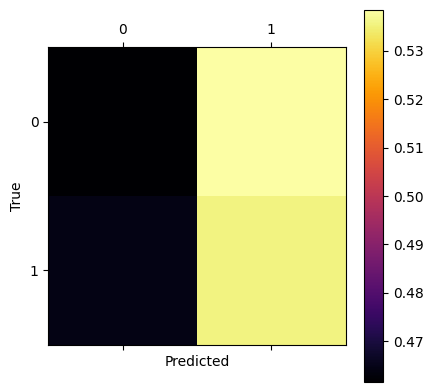

In [71]:
binaryboy.confmat(struct=(20,10,10))

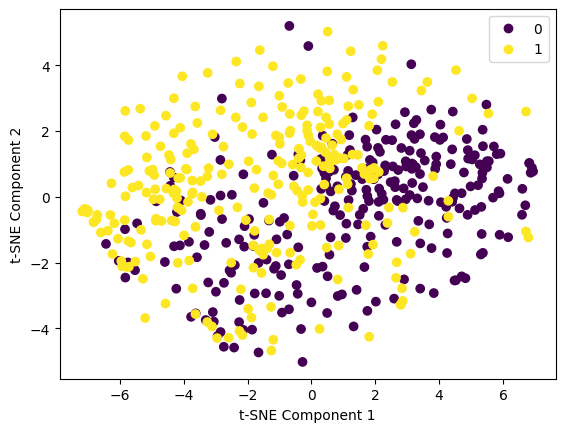

In [72]:
binaryboy.tSNE()

## ARBS vs. MTJ


In [6]:
# Implementing both small and large networks were we will compare the performance. 

# Choose cutoff and feaures
feature = 20
cutoff = 40e6
with open(f'Pickles/waveforms_r6p8_fast/features{feature}cutoff{cutoff}.pkl', 'rb') as f:
    classimtj = pickle.load(f)

path = "waveforms_r6p8_fast/"
classiarb_40 = speechClassifierLab(path, feature_space=20, cutoff=40e6, ch=1)
classiarb_0 = speechClassifierLab(path, feature_space=20, cutoff=0, ch=1)


  0%|          | 0/2995 [00:00<?, ?it/s]

100%|██████████| 2995/2995 [16:13<00:00,  3.08it/s]


In [11]:
structs = [(10,), (20,), (40,), (80,), (100,), (200,),
           (10, 10), (20, 10), (10, 20), (20, 20), (30, 30), (50, 50),
           (10, 10, 10), (50, 50, 50), (80, 40, 20)]

results = np.zeros((len(structs), 6))

for i, s in enumerate(structs):
    test, train = classimtj.clf(layers=s)
    results[i,0] = test
    results[i,1] = train
    test, train = classiarb_40.clf(layers=s)
    results[i,2] = test
    results[i,3] = train
    test, train = classiarb_0.clf(layers=s)
    results[i,4] = test
    results[i,5] = train

Accuracy on test set:		 0.15333333333333332
Accuracy on training set:	 0.18292328438841143
Accuracy on test set:		 0.16333333333333333
Accuracy on training set:	 0.1105823264817049
Accuracy on test set:		 0.14666666666666667
Accuracy on training set:	 0.11688149746521954
Accuracy on test set:		 0.10666666666666667
Accuracy on training set:	 0.14434581688967285
Accuracy on test set:		 0.12
Accuracy on training set:	 0.13320706914306335
Accuracy on test set:		 0.11
Accuracy on training set:	 0.12430127345982873
Accuracy on test set:		 0.16333333333333333
Accuracy on training set:	 0.20780038531635828
Accuracy on test set:		 0.13666666666666666
Accuracy on training set:	 0.1744006579941583
Accuracy on test set:		 0.16333333333333333
Accuracy on training set:	 0.14508449130560805
Accuracy on test set:		 0.21666666666666667
Accuracy on training set:	 0.20779749503077327
Accuracy on test set:		 0.13
Accuracy on training set:	 0.1740166629092954
Accuracy on test set:		 0.15
Accuracy on traini

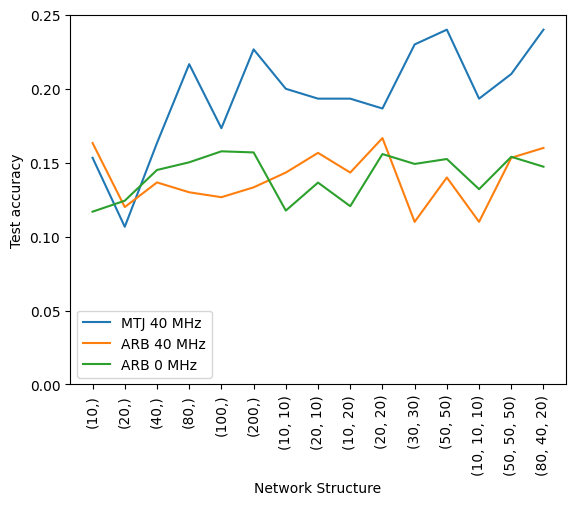

In [13]:
plt.plot(results[:,0], label="MTJ 40 MHz")
#plt.plot(results[:,1], label="MTJ 40 MHz (Training)")
plt.plot(results[:,2], label="ARB 40 MHz")
plt.plot(results[:,5], label="ARB 0 MHz")
plt.ylim([0,0.25])
plt.xlabel("Network Structure")
plt.ylabel("Test accuracy")
plt.xticks(range(len(structs)), labels=[str(s) for s in structs], rotation=90)
plt.legend()

## Plotting Waveforms


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from RSRTxReadBin.RTxReadBin import RTxReadBin

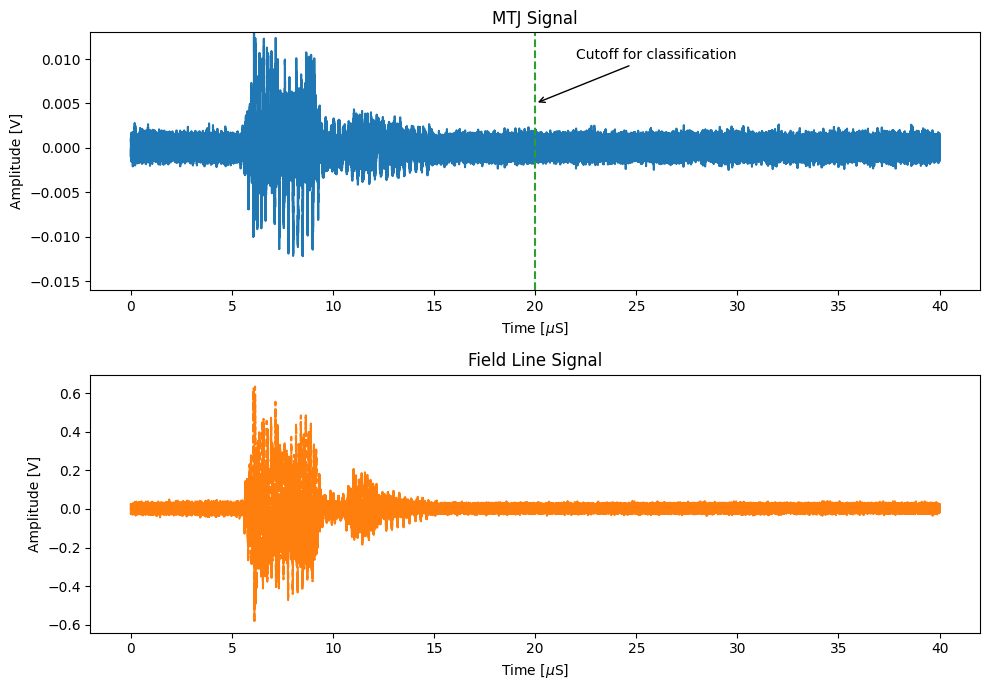

In [2]:
# Load the data
data_file = "waveforms_r6p8_fast/7_theo_10.Wfm.bin"
wfm_data, b, meta_data = RTxReadBin(data_file, nNofChannels=2)
wfm_data_mtj  = np.array(wfm_data[:,0,0])
wfm_data_arb  = np.array(wfm_data[:,0,1])
t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Plot data in the first subplot
ax1.plot(t*1e6, wfm_data_mtj)
ax1.set_title("MTJ Signal")
ax1.set_ylabel("Amplitude [V]")
ax1.set_xlabel("Time [$\mu$S]")
ax1.set_ylim((-0.016, 0.013))
ax1.axvline(x=t[int(len(t)/2)]*1e6, color="C2", ls="--", lw=1.5, label="Switching Time")
ax1.annotate("Cutoff for classification", xy=(t[int(len(t)/2)]*1e6, 0.005), xytext=(t[int(len(t)/2)]*1e6+2, 0.01), arrowprops=dict(arrowstyle="->"))

# Plot data in the second subplot with a dashed line and orange color
ax2.plot(t*1e6, wfm_data_arb, ls="--", c="tab:orange")
ax2.set_title("Field Line Signal")
ax2.set_ylabel("Amplitude [V]")
ax2.set_xlabel("Time [$\mu$S]")

# Display the plot
plt.tight_layout()
#plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/applied_signal.pdf")
plt.show()

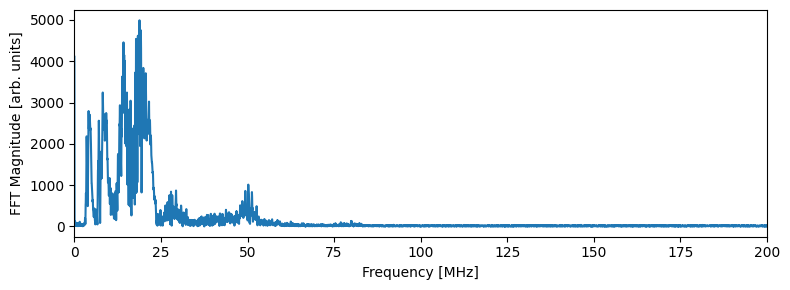

In [6]:
# Plot the FFT of the ARB
from scipy.fft import rfft, rfftfreq
import numpy as np

arb_fft = np.abs(rfft(wfm_data_arb))
freq = rfftfreq(len(wfm_data_arb), meta_data["Resolution"])
plt.figure(figsize=(8,3))
plt.plot(freq/1e6, (arb_fft))
plt.xlim(0,200)
plt.xlabel("Frequency [MHz]")
plt.ylabel("FFT Magnitude [arb. units]")
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/arb_7_theo_fft.pdf")
plt.show()


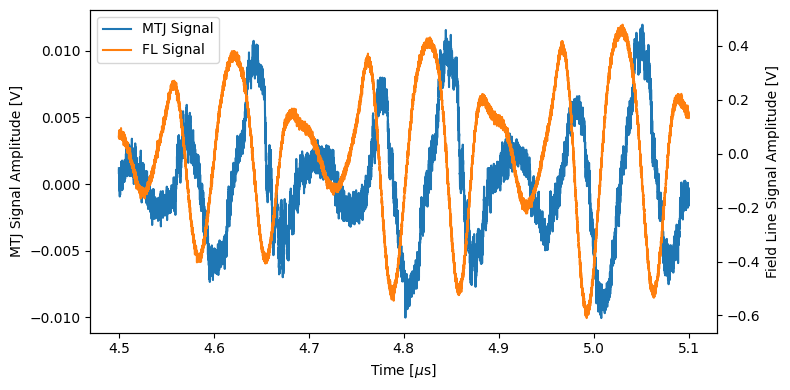

In [47]:
# Zoomed in version
start = 150000
stop = 170000
fig, ax1 = plt.subplots(figsize=(8, 4))

line1, = ax1.plot(t[start:stop] * 1e6, wfm_data_mtj[start:stop], c="tab:blue", label="MTJ Signal")
ax1.set_ylabel("MTJ Signal Amplitude [V]")
ax1.set_xlabel("Time [$\mu$s]")

ax2 = ax1.twinx()
line2, = ax2.plot(t[start:stop] * 1e6, wfm_data_arb[start:stop], c="tab:orange", label="FL Signal")
ax2.set_ylabel("Field Line Signal Amplitude [V]")

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/applied_signal_zoom.pdf")
plt.show()


## Final FC Sweep

In [7]:
# Helper functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from RSRTxReadBin.RTxReadBin import RTxReadBin
import pickle

# Signal Processing
from scipy.fft import fft, fftfreq, fftshift
from scipy.fft import rfft, rfftfreq
from scipy.signal import stft


## Learning 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Load the test data
def load_test_data(data_folder, cutoff, ch, n_features):
    files = []
    for f in os.listdir(data_folder):
        if f.endswith("Wfm.bin") and (f.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))):
            files.append(f)      
   
    features = np.zeros((len(files), n_features))
    classes = []
            
    for n, file in tqdm(enumerate(files), total=len(files)):
        wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
        wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch])/2)] # Take only first half of the data to remove most of empty part
        t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
        #append class from filename
        classes.append(int(file[0]))
    
        for i,(ti,wfmi) in enumerate(zip(np.array_split(t, n_features), np.array_split(wfm_data, n_features))):
            features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
    
    return features, classes


# Load the training data:
def load_train_data(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
        


## get fmax helper function
def get_f_max(t, my, cutoff = 200e6, zeropad = False, no_dc = True):

    zero_pad_N = 100000

    dt = t[1]-t[0]
    
    N = len(t)
    if zeropad:
        # FFT code
        extra = np.zeros((zero_pad_N))
        mye = np.concatenate((my,extra))
        freq = rfft(mye-np.mean(mye))
        f = rfftfreq(N+zero_pad_N, dt)
    else:
        # FFT code
        freq = rfft(my-np.mean(my))
        f = rfftfreq(N, dt)
    #plt.plot(f,freq)
    
    idx = [i for i,v in enumerate(f) if v > cutoff]

    freq = freq[idx]
    f = f[idx]

    f_max = f[np.argmax(np.abs(freq))]

    #if f_max < 2e9:
    #    plt.plot(f[:50],freq[:50])
    return f_max

## Classifier class and plotting functions
class speechClassifierLab():
    def __init__(self, data_folder, feature_space = 20, cutoff = 200e6, processing = True, ch=0):
        ## Ch=0 == MTJ, Ch=1 == ARB
        files = []
        for f in os.listdir(data_folder):
            if f.endswith("Wfm.bin") and (f.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))):
                files.append(f)
                
        ### Generate smaller dataset for testing ###
        #files = files[::2]
        
        self.feature_space = feature_space
        self.features = np.zeros((len(files), feature_space))
        self.classes = []
                
      
        for n, file in tqdm(enumerate(files), total=len(files)):
            wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
            wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch]))] # Take only first half of the data to remove most of empty part
            t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
            #append class from filename
            self.classes.append(int(file[0]))
        
            for i,(ti,wfmi) in enumerate(zip(np.array_split(t,feature_space), np.array_split(wfm_data,feature_space))):
                self.features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
        
    def clf(self, layers = (10,10)):
        
        # Create a train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        crossval = kf.split(X_train, y_train)

        # Create an MLPClassifier    
        clf = MLPClassifier(hidden_layer_sizes=layers, max_iter=100000, random_state=42,activation="tanh")
        
        # Train the model
        scores = cross_val_score(clf, X_train, y_train, cv=crossval)

        # Make predictions
        predictions = cross_val_predict(clf, X_test, y_test, cv=3)

        # Print accuracy
        test_acc = np.mean(predictions == y_test)
        print("Accuracy on test set:\t\t", test_acc)
        print("Accuracy on training set:\t", scores.mean())
        return test_acc, scores.mean()
    
    def PCA_plot(self, save=False, savepath = "pcs.pdf"):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.features)
        
        colors = ["tab:blue", "tab:orange"]
        # Plot the 2D representation
        #c=list(map(str, self.classes)), label=list(map(str, self.classes)), cmap=matplotlib.colors.ListedColormap(colors)
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=self.classes)
        plt.title(f'2D Projection of {self.feature_space}D Data using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig("pca.pdf")
        plt.legend(*scatter.legend_elements())
        if save:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()


    def tSNE(self, savefig = False, savepath = "tsne.pdf"):
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(self.features)
        scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=self.classes)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(*scatter.legend_elements())
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
    
    def confmat(self, savefig = False, savepath = "confmat.pdf", struct = (64,128,64)):
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=struct, max_iter=100000, random_state=42,activation="tanh")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        plt.matshow(cm)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return


In [2]:
# Train the model MTJ r1p9
cut = [40e6, 80e6, 120e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/MTJ/waveforms_r1p9_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r1p9_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=0, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [00:50<00:00,  5.91it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[19.33 20.67 13.67 24.  ]]


100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.33 20.   18.33 18.33]]


 33%|███▎      | 1/3 [02:50<05:41, 170.81s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features20cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.   11.33  9.33 13.  ]]


100%|██████████| 300/300 [00:47<00:00,  6.28it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.33 18.33 13.33 14.67]]


100%|██████████| 300/300 [00:51<00:00,  5.81it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 8.67 13.33  7.33 12.33]]


 67%|██████▋   | 2/3 [05:38<02:48, 168.93s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features50cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 8.33  7.67 11.33  9.  ]]


100%|██████████| 300/300 [00:54<00:00,  5.54it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.67 20.33 14.67 18.  ]]


100%|██████████| 300/300 [00:53<00:00,  5.56it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.33 11.   15.   11.33]]


100%|██████████| 3/3 [08:39<00:00, 173.05s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r1p9_fast/features64cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 8.67 11.33 13.33 11.67]]


In [4]:
# Train the model MTJ r2p3
cut = [40e6, 80e6, 120e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/MTJ/waveforms_r2p3_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r2p3_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=0, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [01:07<00:00,  4.46it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[22.   22.   15.67 23.  ]]


100%|██████████| 300/300 [00:57<00:00,  5.21it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.67 12.67 10.67 14.  ]]


 33%|███▎      | 1/3 [03:08<06:17, 188.71s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features20cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.    9.67  9.67 10.  ]]


100%|██████████| 300/300 [00:50<00:00,  5.92it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.67 16.33 19.   20.33]]


100%|██████████| 300/300 [01:00<00:00,  4.92it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.   13.67 12.   11.67]]


 67%|██████▋   | 2/3 [06:15<03:07, 187.60s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features50cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.33 11.33  8.    9.  ]]


100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.   19.   20.67 22.  ]]


100%|██████████| 300/300 [00:53<00:00,  5.57it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.67 11.    8.67 13.67]]


100%|██████████| 3/3 [09:14<00:00, 184.85s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r2p3_fast/features64cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 8.33  9.67 11.33  8.67]]


In [5]:
# Train the model MTJ r6p7
cut = [40e6, 80e6, 120e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/MTJ/waveforms_r6p7_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p7_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=0, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [00:38<00:00,  7.75it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[20. 21. 16. 20.]]


100%|██████████| 300/300 [00:27<00:00, 11.10it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[10.67 15.33 13.   15.67]]


 33%|███▎      | 1/3 [01:44<03:28, 104.37s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features20cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[10.67 16.33 13.67 16.33]]


100%|██████████| 300/300 [00:28<00:00, 10.68it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.   20.33 12.33 20.67]]


100%|██████████| 300/300 [00:29<00:00, 10.20it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.67 12.33 11.67 18.33]]


 67%|██████▋   | 2/3 [03:30<01:45, 105.15s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features50cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.   12.67 11.67 13.67]]


100%|██████████| 300/300 [00:43<00:00,  6.97it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.67 17.   21.   17.  ]]


100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.   15.67 11.33 13.33]]


100%|██████████| 3/3 [06:02<00:00, 120.72s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p7_fast/features64cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.67 17.67 13.33 14.67]]


In [6]:
# Train the model MTJ r6p8
cut = [40e6, 80e6, 120e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/MTJ/waveforms_r6p8_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p8_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=0, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [01:28<00:00,  3.37it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[20.   21.67 22.67 24.  ]]


100%|██████████| 300/300 [01:18<00:00,  3.83it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.67 19.   14.33 18.  ]]


 33%|███▎      | 1/3 [04:37<09:15, 277.94s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features20cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.   17.33 15.33 18.67]]


100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.   19.33 20.67 24.  ]]


100%|██████████| 300/300 [01:21<00:00,  3.70it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.67 20.   18.33 17.33]]


 67%|██████▋   | 2/3 [08:48<04:21, 261.68s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features50cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17. 21. 18. 18.]]


100%|██████████| 300/300 [01:16<00:00,  3.90it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.33 23.67 15.67 22.33]]


100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.33 18.   14.67 19.67]]


100%|██████████| 3/3 [12:50<00:00, 256.82s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p8_fast/features64cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.67 15.67 12.   15.  ]]


In [7]:
# Train the model MTJ r6p9
cut = [40e6, 80e6, 120e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/MTJ/waveforms_r6p9_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p9_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=0, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [00:42<00:00,  7.11it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[21.   21.33 18.   25.33]]


100%|██████████| 300/300 [00:29<00:00, 10.30it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.   20.33 24.   25.  ]]


 33%|███▎      | 1/3 [01:53<03:47, 113.67s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features20cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[21.33 21.33 21.   29.33]]


100%|██████████| 300/300 [00:30<00:00,  9.73it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.33 17.   16.   22.  ]]


100%|██████████| 300/300 [00:30<00:00,  9.99it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[19.33 20.67 17.   20.  ]]


 67%|██████▋   | 2/3 [03:44<01:51, 111.83s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features50cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.67 17.   15.33 18.67]]


100%|██████████| 300/300 [00:34<00:00,  8.65it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.33 16.33 14.67 20.33]]


100%|██████████| 300/300 [00:32<00:00,  9.28it/s]


Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.   14.33 18.   18.67]]


100%|██████████| 3/3 [05:42<00:00, 114.15s/it]

Accuracy for: ./Pickles_new/MTJ/waveforms_r6p9_fast/features64cutoff120000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.   16.67 11.33 19.  ]]


In [8]:
# Train the model ARB r1p9
cut = [0e6, 40e6, 80e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/waveforms_r1p9_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r1p9_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=1, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [01:03<00:00,  4.72it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features20cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.33 13.33 11.33 16.  ]]


100%|██████████| 300/300 [00:54<00:00,  5.47it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.33 15.67 13.67 22.33]]


 33%|███▎      | 1/3 [03:07<06:15, 187.57s/it]

Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.67 18.33 16.   19.33]]


100%|██████████| 300/300 [00:51<00:00,  5.87it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features50cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.33 10.   11.67 15.  ]]


100%|██████████| 300/300 [00:49<00:00,  6.05it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.33 17.67 13.67 15.33]]


 67%|██████▋   | 2/3 [05:57<02:57, 177.44s/it]

Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.33 18.33 11.33 20.  ]]


100%|██████████| 300/300 [00:57<00:00,  5.20it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features64cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.   13.33  8.   16.33]]


100%|██████████| 300/300 [00:52<00:00,  5.70it/s]


Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.67 15.   14.   11.33]]


100%|██████████| 3/3 [09:00<00:00, 180.33s/it]

Accuracy for: ./Pickles_new/waveforms_r1p9_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.   13.   14.67 16.  ]]


In [10]:
# Train the model ARB r2p3
cut = [0e6, 40e6, 80e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/waveforms_r2p3_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r2p3_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=1, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features20cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.33 18.67 12.   14.  ]]


100%|██████████| 300/300 [00:48<00:00,  6.19it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.33 20.   11.33 19.33]]


 33%|███▎      | 1/3 [03:01<06:03, 181.87s/it]

Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.33 16.33 13.33 17.67]]


100%|██████████| 300/300 [00:50<00:00,  5.96it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features50cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.33 13.67 13.67 17.33]]


100%|██████████| 300/300 [00:52<00:00,  5.71it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.67 20.67 14.   19.33]]


 67%|██████▋   | 2/3 [05:58<02:58, 178.93s/it]

Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.67 15.   17.   17.33]]


100%|██████████| 300/300 [00:59<00:00,  5.03it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features64cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.33 13.33 12.   12.67]]


100%|██████████| 300/300 [01:01<00:00,  4.88it/s]


Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.33 16.   15.   17.33]]


100%|██████████| 3/3 [09:20<00:00, 186.85s/it]

Accuracy for: ./Pickles_new/waveforms_r2p3_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.33 17.67 17.   21.  ]]


In [12]:
# Train the model ARB r6p7
cut = [0e6, 40e6, 80e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/waveforms_r6p7_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p7_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=1, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [00:35<00:00,  8.50it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features20cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.   14.33 13.67 15.33]]


100%|██████████| 300/300 [00:28<00:00, 10.42it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.   14.67 15.   17.  ]]


 33%|███▎      | 1/3 [01:50<03:40, 110.45s/it]

Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[22.67 16.67 14.33 16.67]]


100%|██████████| 300/300 [00:28<00:00, 10.57it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features50cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.33 15.67 10.67 16.67]]


100%|██████████| 300/300 [00:28<00:00, 10.43it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.33 13.   14.67 14.33]]


 67%|██████▋   | 2/3 [03:35<01:47, 107.28s/it]

Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.   14.67 14.33 16.33]]


100%|██████████| 300/300 [00:28<00:00, 10.62it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features64cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[14.33 13.33 14.   19.67]]


100%|██████████| 300/300 [00:32<00:00,  9.15it/s]


Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.   13.   15.   15.33]]


100%|██████████| 3/3 [05:25<00:00, 108.55s/it]

Accuracy for: ./Pickles_new/waveforms_r6p7_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.33 18.67 17.33 15.67]]


In [14]:
# Train the model ARB r6p8
cut = [0e6, 40e6, 80e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/waveforms_r6p8_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p8_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=1, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [01:11<00:00,  4.22it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features20cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.   12.67 14.   16.67]]


100%|██████████| 300/300 [00:51<00:00,  5.87it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.33 17.   15.33 20.  ]]


 33%|███▎      | 1/3 [03:09<06:18, 189.02s/it]

Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.   17.33 17.33 22.  ]]


100%|██████████| 300/300 [00:48<00:00,  6.18it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features50cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[ 9.67 14.   15.   16.67]]


100%|██████████| 300/300 [00:48<00:00,  6.24it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[10.33 13.33 10.67 16.  ]]


 67%|██████▋   | 2/3 [05:54<02:54, 174.88s/it]

Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.67 17.   15.67 21.  ]]


100%|██████████| 300/300 [00:53<00:00,  5.60it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features64cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.   15.   13.   16.33]]


100%|██████████| 300/300 [00:52<00:00,  5.77it/s]


Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.   14.67 10.67 17.33]]


100%|██████████| 3/3 [08:50<00:00, 176.92s/it]

Accuracy for: ./Pickles_new/waveforms_r6p8_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.33 13.   15.67 18.  ]]


In [15]:
# Train the model ARB r6p9
cut = [0e6, 40e6, 80e6]
feat = [20, 50, 64]

for i, f in tqdm(enumerate(feat), total=len(feat)):
    for j, c in enumerate(cut):
        # Load the pickeled model
        path_train = f"./Pickles_new/waveforms_r6p9_fast/features{f}cutoff{c}.pkl"
        data = load_train_data(path_train)
        train_feature = data.features
        train_classes = data.classes

        # Prepare the test data
        path_test = "waveforms_r6p9_fast_test/"
        test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=c, ch=1, n_features=f)

        # Train the model and test accuracy
        layers = [(50,), (50,50), (20,10), (64,128,64)]
        acc = np.zeros((len(layers), 1))
        for i, l in enumerate(layers):
            mlp = MLPClassifier(hidden_layer_sizes=l, max_iter=100000, random_state=42,activation="tanh")
            mlp.fit(train_feature, train_classes)
            pred_classes = mlp.predict(test_feature)
            acc[i] = np.mean(test_classes==pred_classes)*100

        acc = np.round(acc,decimals=2)
        print("Accuracy for:", path_train, "\n", layers, "\n", acc.T)

100%|██████████| 300/300 [00:33<00:00,  9.09it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features20cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.33 13.   11.67 16.67]]


100%|██████████| 300/300 [00:27<00:00, 11.04it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features20cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[16.   20.33 12.33 19.  ]]


 33%|███▎      | 1/3 [01:43<03:27, 103.68s/it]

Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features20cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[15.33 19.33 17.   16.67]]


100%|██████████| 300/300 [00:28<00:00, 10.44it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features50cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.    9.   11.33 17.67]]


100%|██████████| 300/300 [00:28<00:00, 10.51it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features50cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[12.67 14.   17.33 15.33]]


 67%|██████▋   | 2/3 [03:29<01:44, 104.70s/it]

Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features50cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[13.67 17.67 17.67 20.  ]]


100%|██████████| 300/300 [00:28<00:00, 10.52it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features64cutoff0.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[11.33 14.67 10.67 16.67]]


100%|██████████| 300/300 [00:28<00:00, 10.40it/s]


Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features64cutoff40000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[17.   17.33 11.33 14.67]]


100%|██████████| 3/3 [05:13<00:00, 104.56s/it]

Accuracy for: ./Pickles_new/waveforms_r6p9_fast/features64cutoff80000000.0.pkl 
 [(50,), (50, 50), (20, 10), (64, 128, 64)] 
 [[18.67 19.33 20.   19.  ]]


## Confusion matrix


100%|██████████| 300/300 [00:35<00:00,  8.43it/s]


Acc: 29.33
[[0.46666667 0.03333333 0.06666667 0.06666667 0.06666667 0.03333333
  0.         0.         0.         0.26666667]
 [0.1        0.03333333 0.23333333 0.03333333 0.06666667 0.16666667
  0.13333333 0.03333333 0.16666667 0.03333333]
 [0.1        0.03333333 0.36666667 0.         0.06666667 0.03333333
  0.2        0.         0.13333333 0.06666667]
 [0.13333333 0.06666667 0.26666667 0.06666667 0.06666667 0.03333333
  0.13333333 0.         0.13333333 0.1       ]
 [0.03333333 0.03333333 0.2        0.03333333 0.23333333 0.16666667
  0.03333333 0.06666667 0.13333333 0.06666667]
 [0.06666667 0.03333333 0.2        0.13333333 0.1        0.2
  0.06666667 0.06666667 0.06666667 0.06666667]
 [0.         0.         0.03333333 0.06666667 0.         0.
  0.76666667 0.06666667 0.06666667 0.        ]
 [0.06666667 0.06666667 0.1        0.03333333 0.         0.16666667
  0.16666667 0.16666667 0.03333333 0.2       ]
 [0.         0.         0.2        0.1        0.1        0.03333333
  0.16666667 0. 

C:\Users\olive\AppData\Local\Temp\ipykernel_2468\907377645.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


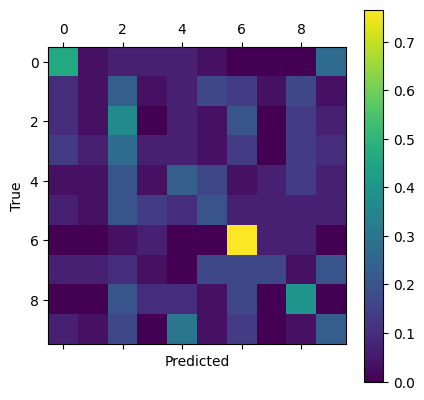

In [10]:
# Training data
path_train = f"./Pickles_new/MTJ/waveforms_r6p9_fast/features20cutoff{120e6}.pkl"
data = load_train_data(path_train)
train_feature = data.features
train_classes = data.classes

# Test data
path_test = "waveforms_r6p9_fast_test/"
test_feature, test_classes = load_test_data(data_folder=path_test, cutoff=120e6, ch=0, n_features=20)

clf = MLPClassifier(hidden_layer_sizes=(64,128,64), max_iter=100000, random_state=42,activation="tanh")
clf.fit(train_feature, train_classes)
y_pred = clf.predict(test_feature)
cm = confusion_matrix(test_classes, y_pred)
cm = cm/cm.sum(axis=1)[:, np.newaxis]

print("Acc:", np.round(np.mean(test_classes==y_pred)*100, decimals=2))


print(cm)
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
print("figure saved")
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/confmat_r6p8.pdf")
plt.show()

Acc: 29.33
[[0.46666667 0.03333333 0.06666667 0.06666667 0.06666667 0.03333333
  0.         0.         0.         0.26666667]
 [0.1        0.03333333 0.23333333 0.03333333 0.06666667 0.16666667
  0.13333333 0.03333333 0.16666667 0.03333333]
 [0.1        0.03333333 0.36666667 0.         0.06666667 0.03333333
  0.2        0.         0.13333333 0.06666667]
 [0.13333333 0.06666667 0.26666667 0.06666667 0.06666667 0.03333333
  0.13333333 0.         0.13333333 0.1       ]
 [0.03333333 0.03333333 0.2        0.03333333 0.23333333 0.16666667
  0.03333333 0.06666667 0.13333333 0.06666667]
 [0.06666667 0.03333333 0.2        0.13333333 0.1        0.2
  0.06666667 0.06666667 0.06666667 0.06666667]
 [0.         0.         0.03333333 0.06666667 0.         0.
  0.76666667 0.06666667 0.06666667 0.        ]
 [0.06666667 0.06666667 0.1        0.03333333 0.         0.16666667
  0.16666667 0.16666667 0.03333333 0.2       ]
 [0.         0.         0.2        0.1        0.1        0.03333333
  0.16666667 0. 

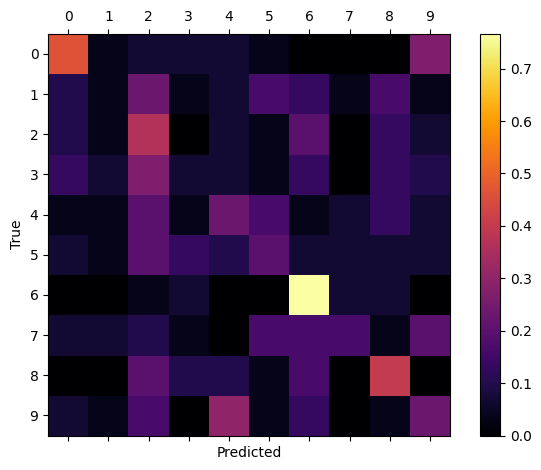

In [16]:
y_pred = clf.predict(test_feature)
cm = confusion_matrix(test_classes, y_pred)
cm = cm/cm.sum(axis=1)[:, np.newaxis]

print("Acc:", np.round(np.mean(test_classes==y_pred)*100, decimals=2))


print(cm)

plt.matshow(cm, fignum=0, cmap='inferno')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(10), labels=[str(i) for i in range(10)])
plt.yticks(range(10), labels=[str(i) for i in range(10)])
print("figure saved")
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/confmat_r6p8.pdf")
plt.show()

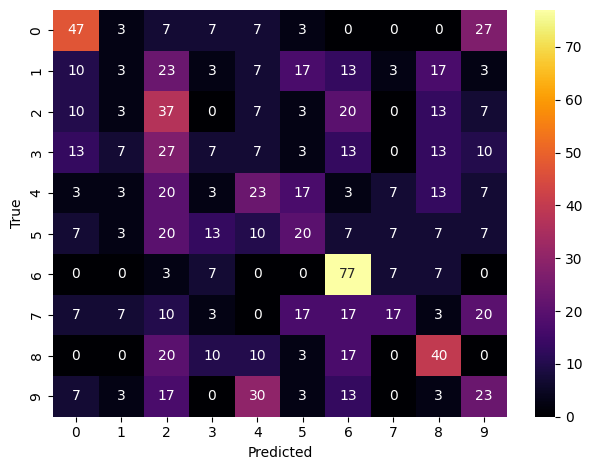

In [19]:
import seaborn as sns
cm = confusion_matrix(test_classes, y_pred=clf.predict(test_feature))
cm = np.round(cm/cm.sum(axis=1)[:, np.newaxis]*100, decimals=0).astype(int)
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter5_application/fig/confmat_r6p8.pdf")
plt.show()

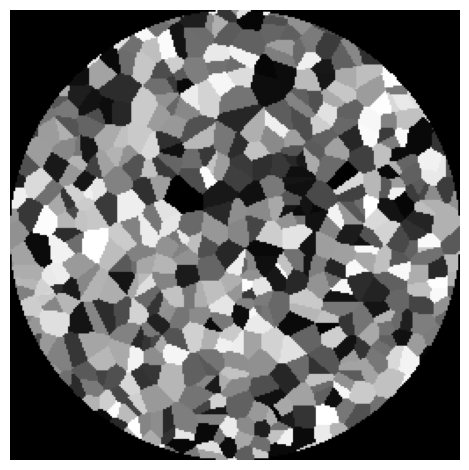

In [32]:
import numpy as np
import matplotlib.pyplot as plt
np.load("../../Simulations/regions_mumax.out/regions000000.npy")

# plot matrix without axis

plt.axis('off')
plt.imshow(np.load("../../Simulations/regions_mumax.out/regions000000.npy")[0,0,:,:], cmap='gray')
plt.tight_layout()
plt.savefig("../../Dropbox/Apps/Overleaf/Speciale/Chapter3_simulation/fig/regions.pdf")

In [28]:
np.min(np.load("../../Simulations/regions_mumax.out/regions000000.npy")[0,0,:,:])

0.0